# CRE/MF Mortgage Rate Model Demo

# Setup

In [10]:
# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

# ML libraries
import pandas as pd
import xgboost as xgb
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# ValidMind libraries 
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import validmind as vm
from validmind.vm_models.test_context import TestContext

# Plotting libraries 
import matplotlib.pyplot as plt
%matplotlib inline


# Load Data

In [11]:
df = pd.read_csv("../datasets/lending_club_loan_rates.csv", sep='\t')
df = df.rename(columns={'Unnamed: 0': 'Date'})
df = df.set_index(pd.to_datetime(df['Date']))
df.drop(["Date"], axis=1, inplace=True)

# Remove diff columns
columns_to_remove = [col for col in df.columns if col.startswith("diff")]
df = df.drop(columns=columns_to_remove)
df.head()

loan_rate_A  loan_rate_B  loan_rate_C  loan_rate_D  FEDFUNDS
Date                                                                    
2007-08-01     7.766667     9.497692    10.947500    12.267000      5.02
2007-09-01     7.841429     9.276667    10.829167    12.436667      4.94
2007-10-01     7.830000     9.433333    10.825926    12.737368      4.76
2007-11-01     7.779091     9.467778    10.967037    12.609444      4.49
2007-12-01     7.695833     9.387500    10.805000    12.478889      4.24

Visual Inspection.

# ValidMind Setup

Initialize ValidMind dataset.

In [12]:
vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "e22b89a6b9c2a27da47cb0a09febc001",
  api_secret = "a61be901b5596e3c528d94231e4a3c504ef0bb803d16815f8dfd6857fac03e57",
  project = "clgo0g0rt0000fjy6ozl9pb69"
)

True

In [13]:
target_variables = ["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]

vm_dataset = vm.init_dataset(
    dataset=df,
    target_column = target_variables   
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


Visualize existing test plans.

In [14]:
vm.test_plans.list_plans()

# 4. Model Development

# 4.1. Development Data and Platform

## 4.1.2. Data Quality and Relevance

## 4.1.3. Data Process, Adjustments and Treatment

### A. Missing Values Analysis

**Step 1: Calculate the percentage of missing values in each column**

**Step 2: Display the missing values percentage in a table format**

**Step 3: Visualize the missing values**

 ### B. Outliers Analysis

**Step 1: Visualize the dataset using box plots**

Visualize the data using box plots to get an initial sense of the presence of outliers.

**Step 2: Calculate Z-scores**

**Step 3: Set a threshold and identify outliers**

Set a threshold (e.g., 3) to identify data points with Z-scores higher than the threshold.

**Step 4: Analyze the outliers**

Analyze the outliers by looking at their frequency, index, and corresponding column.

 ### C. Stationarity Analysis

**Step 1: Run Unit Root Tests**

In [15]:
from validmind.test_plans.statsmodels_timeseries import UnitRoot 
test_context = TestContext(dataset=vm_dataset)
ur_test_plan = UnitRoot(test_context=test_context)
ur_test_plan.run()

Running Metric: kpss:  20%|██        | 1/5 [00:00<00:00, 89.93it/s]  The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



Unit Root Tests with Stationarity Decision.

In [16]:
# Question: Ideally we would like to show results of unit root test plan like this (results hardcoded)
unit_root_test_results = {
    'Series': ['loan_rate_A', 'loan_rate_A', 'loan_rate_A', 'loan_rate_A', 'loan_rate_A', 'loan_rate_B', 'loan_rate_B', 'loan_rate_B', 'loan_rate_B', 'loan_rate_B', 'loan_rate_C', 'loan_rate_C', 'loan_rate_C', 'loan_rate_C', 'loan_rate_C', 'loan_rate_D', 'loan_rate_D', 'loan_rate_D', 'loan_rate_D', 'loan_rate_D', 'FEDFUNDS', 'FEDFUNDS', 'FEDFUNDS', 'FEDFUNDS', 'FEDFUNDS'],
    'Test': ['ADF', 'KPSS', 'Phillips-Perron', 'Zivot-Andrews', 'DFGLS', 'ADF', 'KPSS', 'Phillips-Perron', 'Zivot-Andrews', 'DFGLS', 'ADF', 'KPSS', 'Phillips-Perron', 'Zivot-Andrews', 'DFGLS', 'ADF', 'KPSS', 'Phillips-Perron', 'Zivot-Andrews', 'DFGLS', 'ADF', 'KPSS', 'Phillips-Perron', 'Zivot-Andrews', 'DFGLS'],
    'p-value': [0.323972, 0.010000, 0.274663, 0.680477, 0.071277, 0.022424, 0.100000, 0.129150, 0.011857, 0.166778, 0.108190, 0.010000, 0.183507, 0.074135, 0.512549, 0.474219, 0.010000, 0.354187, 0.100013, 0.777909, 0.942169, 0.087609, 0.001572, 0.208163, 0.151094],
    'Threshold': [0.05] * 25,
    'Pass/Fail': ['Pass', 'Pass', 'Pass', 'Pass', 'Pass', 'Fail', 'Fail', 'Pass', 'Fail', 'Pass', 'Pass', 'Pass', 'Pass', 'Pass', 'Pass', 'Pass', 'Pass', 'Pass', 'Pass', 'Pass', 'Pass', 'Fail', 'Fail', 'Pass', 'Pass'],
    'Decision': ['non-stationary', 'stationary', 'non-stationary', 'non-stationary', 'non-stationary', 'stationary', 'non-stationary', 'non-stationary', 'stationary', 'non-stationary', 'non-stationary', 'stationary', 'non-stationary', 'non-stationary', 'non-stationary', 'non-stationary', 'stationary', 'non-stationary', 'non-stationary', 'non-stationary', 'non-stationary', 'non-stationary', 'stationary', 'non-stationary', 'non-stationary']
}

display(pd.DataFrame(unit_root_test_results))

Series             Test   p-value  Threshold Pass/Fail  \
0   loan_rate_A              ADF  0.323972       0.05      Pass   
1   loan_rate_A             KPSS  0.010000       0.05      Pass   
2   loan_rate_A  Phillips-Perron  0.274663       0.05      Pass   
3   loan_rate_A    Zivot-Andrews  0.680477       0.05      Pass   
4   loan_rate_A            DFGLS  0.071277       0.05      Pass   
5   loan_rate_B              ADF  0.022424       0.05      Fail   
6   loan_rate_B             KPSS  0.100000       0.05      Fail   
7   loan_rate_B  Phillips-Perron  0.129150       0.05      Pass   
8   loan_rate_B    Zivot-Andrews  0.011857       0.05      Fail   
9   loan_rate_B            DFGLS  0.166778       0.05      Pass   
10  loan_rate_C              ADF  0.108190       0.05      Pass   
11  loan_rate_C             KPSS  0.010000       0.05      Pass   
12  loan_rate_C  Phillips-Perron  0.183507       0.05      Pass   
13  loan_rate_C    Zivot-Andrews  0.074135       0.05      Pass   
14  loan_rate_C            DFGLS  0.512549       0.05      Pass   
15  loan_rate_D              ADF  0.474219       0.05      Pass   
16  loan_rate_D             KPSS  0.010000       0.05      Pass   
17  loan_rate_D  Phillips-Perron  0.354187       0.05      Pass   
18  loan_rate_D    Zivot-Andrews  0.100013       0.05      Pass   
19  loan_rate_D            DFGLS  0.777909       0.05      Pass   
20     FEDFUNDS              ADF  0.942169       0.05      Pass   
21     FEDFUNDS             KPSS  0.087609       0.05      Fail   
22     FEDFUNDS  Phillips-Perron  0.001572       0.05      Fail   
23     FEDFUNDS    Zivot-Andrews  0.208163       0.05      Pass   
24     FEDFUNDS            DFGLS  0.151094       0.05      Pass   

          Decision  
0   non-stationary  
1       stationary  
2   non-stationary  
3   non-stationary  
4   non-stationary  
5       stationary  
6   non-stationary  
7   non-stationary  
8       stationary  
9   non-stationary  
10  non-stationary  
11      stationary  
12  non-stationary  
13  non-stationary  
14  non-stationary  
15  non-stationary  
16      stationary  
17  non-stationary  
18  non-stationary  
19  non-stationary  
20  non-stationary  
21  non-stationary  
22      stationary  
23  non-stationary  
24  non-stationary

Interpretation of Unit Root Tests. 

**Step 2: Making Series Stationary**

Compute first difference. 

In [17]:
diff_df = df.diff().dropna()

Inspect time series.

**Step 3: Run Unit Root Tests**

In [19]:
# Pass first difference to VM dataset
# Question: I am now overwriting the df, can I log both raw and first diff dataset and use them as required later on? 
vm_dataset = vm.init_dataset(dataset=diff_df)
test_context = TestContext(dataset=vm_dataset)
ur_test_plan = UnitRoot(test_context=test_context)
ur_test_plan.run()

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


Running Metric: kpss:  20%|██        | 1/5 [00:00<00:00, 82.73it/s]  The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



Unit Root Tests with Stationarity Decision.

Interpretation of Unit Root Tests.

**Step 4: Decision**

Series is stationary after first difference. 

### D. Seasonality Analysis

**Step 1: Seasonal decomposition**

Perform seasonal decomposition on each time series.

In [8]:
from validmind.model_validation.statsmodels.metrics import SeasonalDecompose
test_context = TestContext(train_ds=vm_train_ds)
sd_metric = SeasonalDecompose(test_context=test_context)

NameError: name 'vm_train_ds' is not defined

**Step 2: Visualize seasonal decomposition**

Create plots for observed, trend, seasonal and residual components.

In [ ]:
sd_metric.run()
sd_metric.result.show()

Seasonality Detection using ACF and PACF.

In [ ]:
from validmind.model_validation.statsmodels.metrics import SeasonalityDetectionWithACFandPACF
test_context = TestContext(train_ds=vm_train_ds)
acf_metric = SeasonalityDetectionWithACFandPACF(test_context=test_context)
acf_metric.run()
acf_metric.result.show()

**Step 3: Residuals Analysis**

Residuals series, histogram, Q-Q and ACF plots.

In [10]:
# Comment: How do I pass the residuals of seasonal decomponsition done before using SeasonalDecomposeMetricWithFigure?
from validmind.model_validation.statsmodels.metrics import ResidualsVisualInspection
test_context = TestContext(train_ds=vm_train_ds)
rvi_metric = ResidualsVisualInspection(test_context=test_context)
rvi_metric.run()

In [11]:
rvi_metric.result.show()

Test if Residuals are Normaly Distributed.

In [12]:
# Comment: How do I pass the residuals of seasonal decomponsition done before using SeasonalDecomposeMetricWithFigure?
vm.run_test_plan("normality_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

Test if Residuals are Autocorrelated.

In [13]:
# Comment: How do I pass the residuals of seasonal decomponsition done before using SeasonalDecomposeMetricWithFigure?
vm.run_test_plan("autocorrelation_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

**Step 4: Test for seasonality using the Augmented Dickey-Fuller (ADF) test**

**Step 5: Analyze the seasonality test results**

**Step 6: Interpret the results**

**Step 7: Handle seasonality**

# 4.2. Methodology Selection and Development

## 4.2.4 Variable Analysis

 ## A. Feature Analysis

## A.1. Univariate Analysis

### Visual Inspection

## A.2 Multivariave Analysis

### Visual Inspection

## B. Variable Selection

### ARIMA Analysis

**Step 1: Identify the Integration order (Stationarity Analysis)**

Unit Root Tests. 

In [14]:
vm.run_test_plan("unit_root_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

**Step 2: Identify the AR order**

**Step 3: Identify the MA order**

In [15]:
vm.run_test_plan("normality_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

**Run `SeasonalDecomposeMetricWithFigure` Test**

In [16]:
# test_context = TestContext(train_ds=vm_train_ds)
# sd_metric = SeasonalDecomposeMetricWithFigure(test_context=test_context)
# sd_metric.run()

**Run `ResidualsVisualInspection` Test**

In [17]:
test_context = TestContext(train_ds=vm_train_ds, test_ds=vm_test_ds)
rvi_test = ResidualsVisualInspection(test_context=test_context)
rvi_test.run()

In [18]:
vm.run_test_plan("seasonality_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

Running Metric: time_series_univariate_inspection_raw: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]      


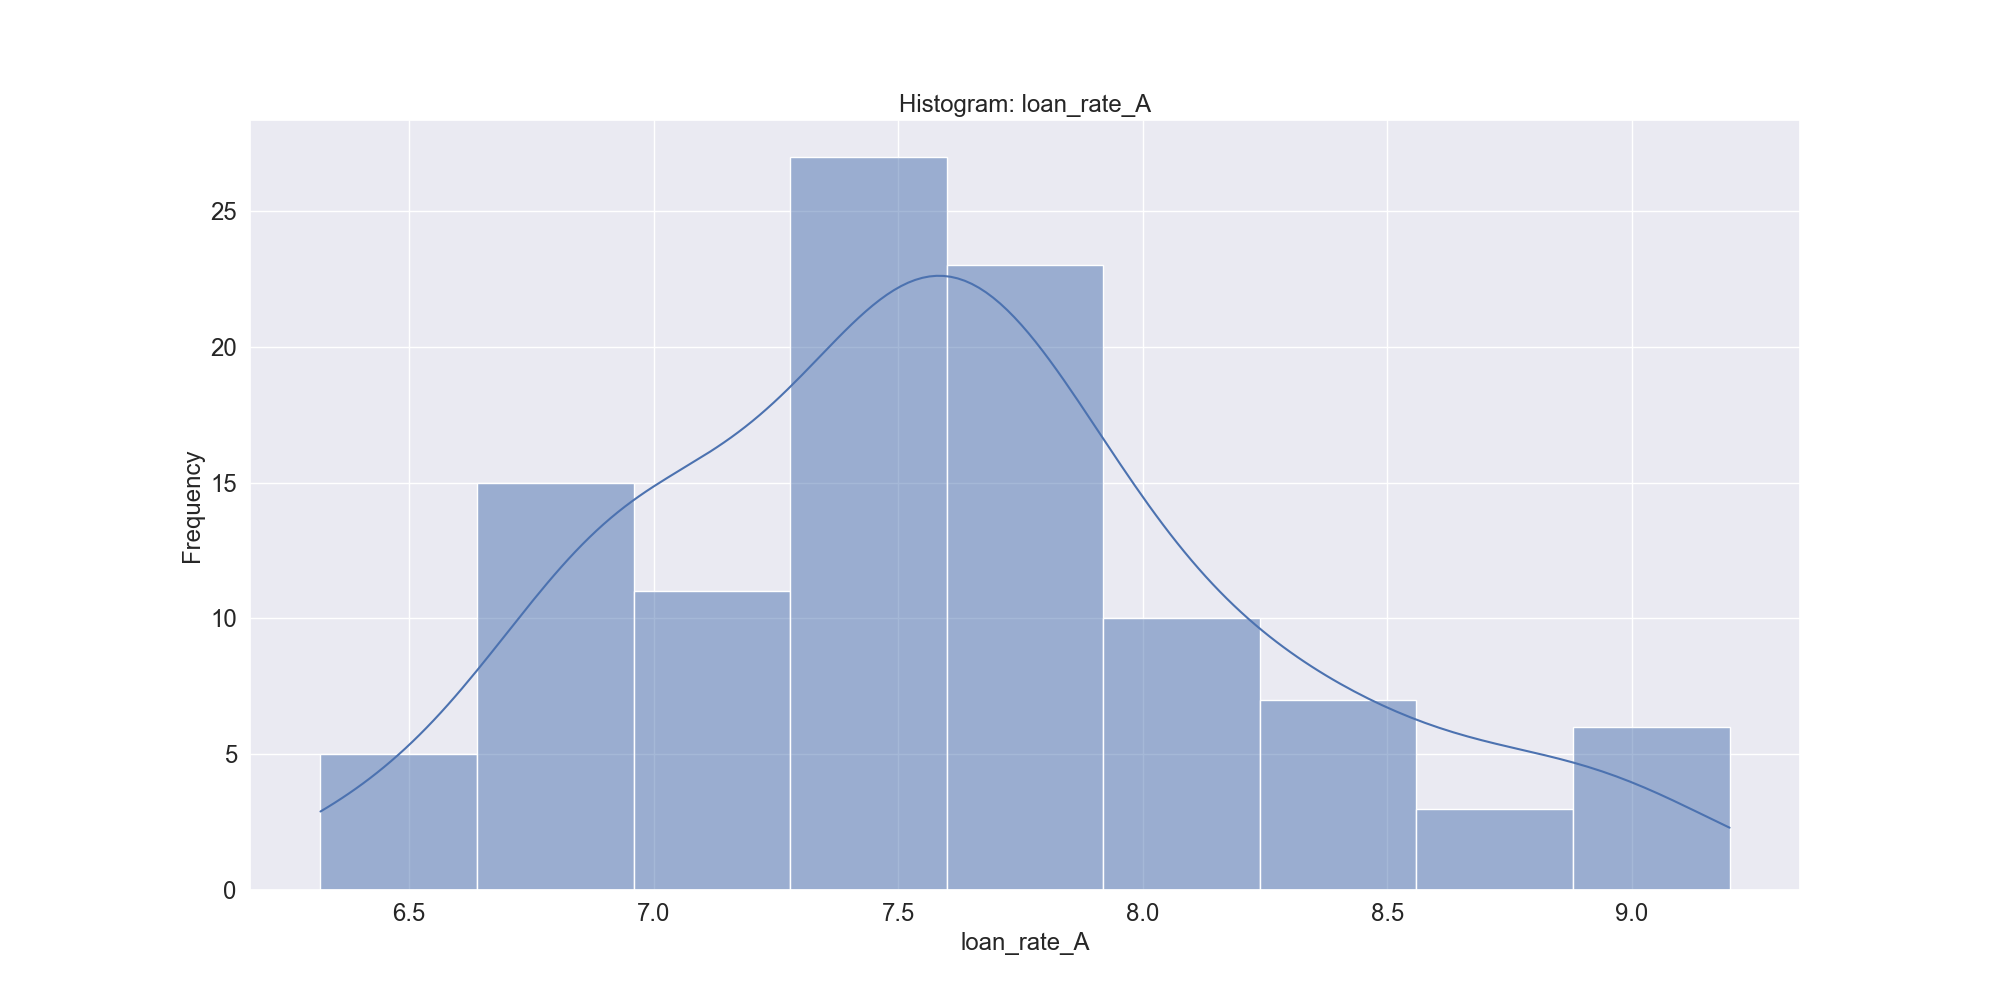
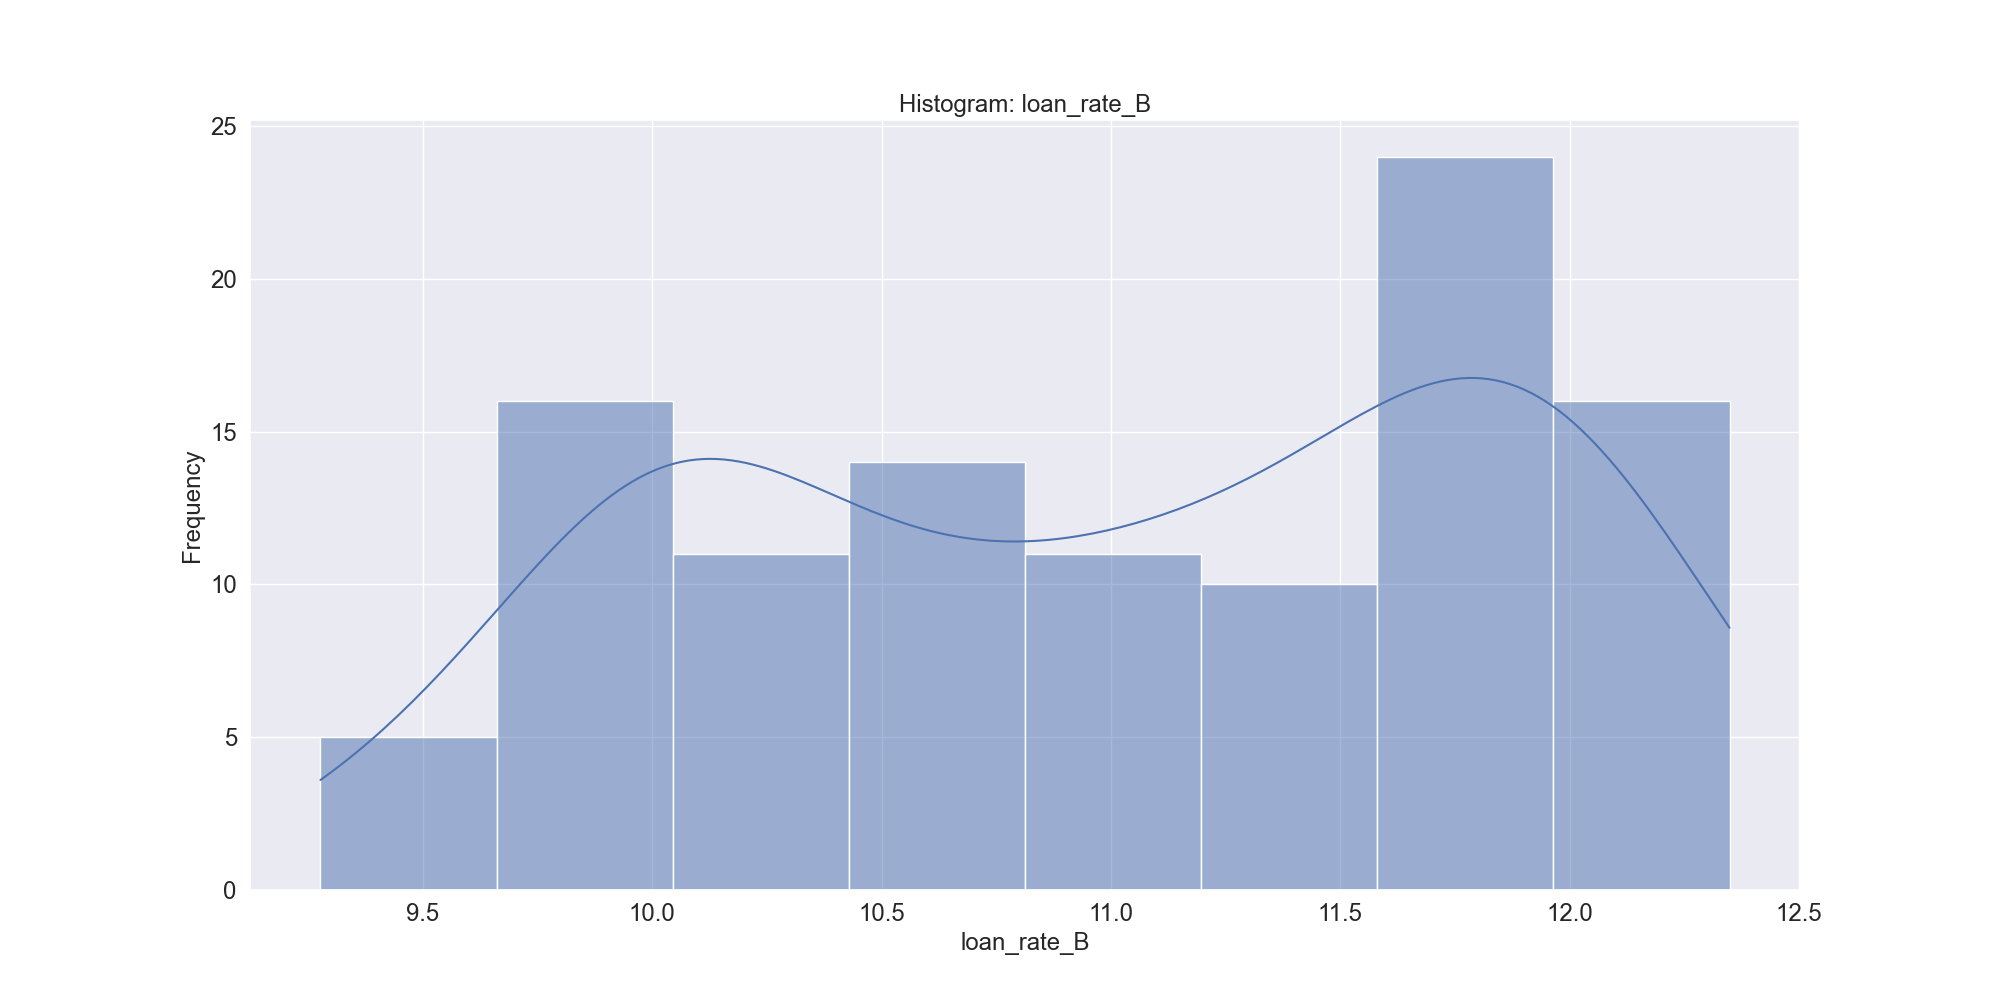
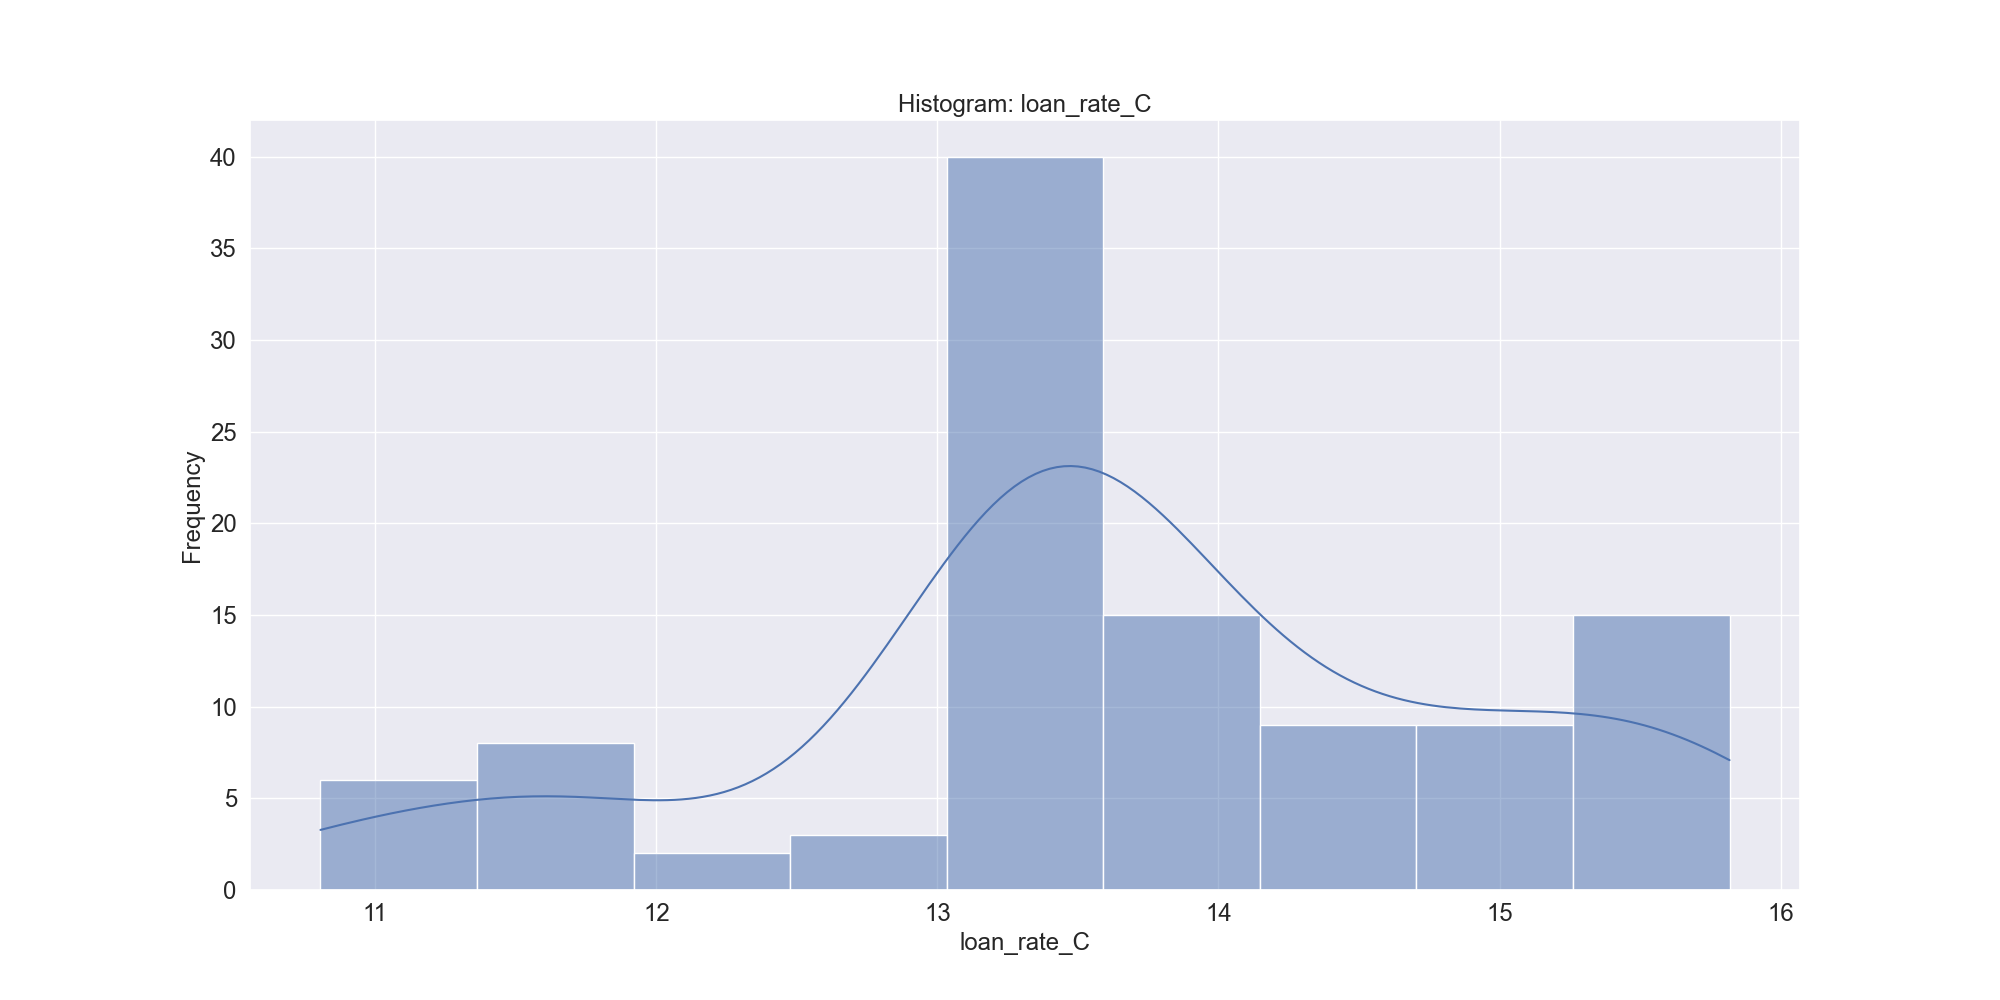
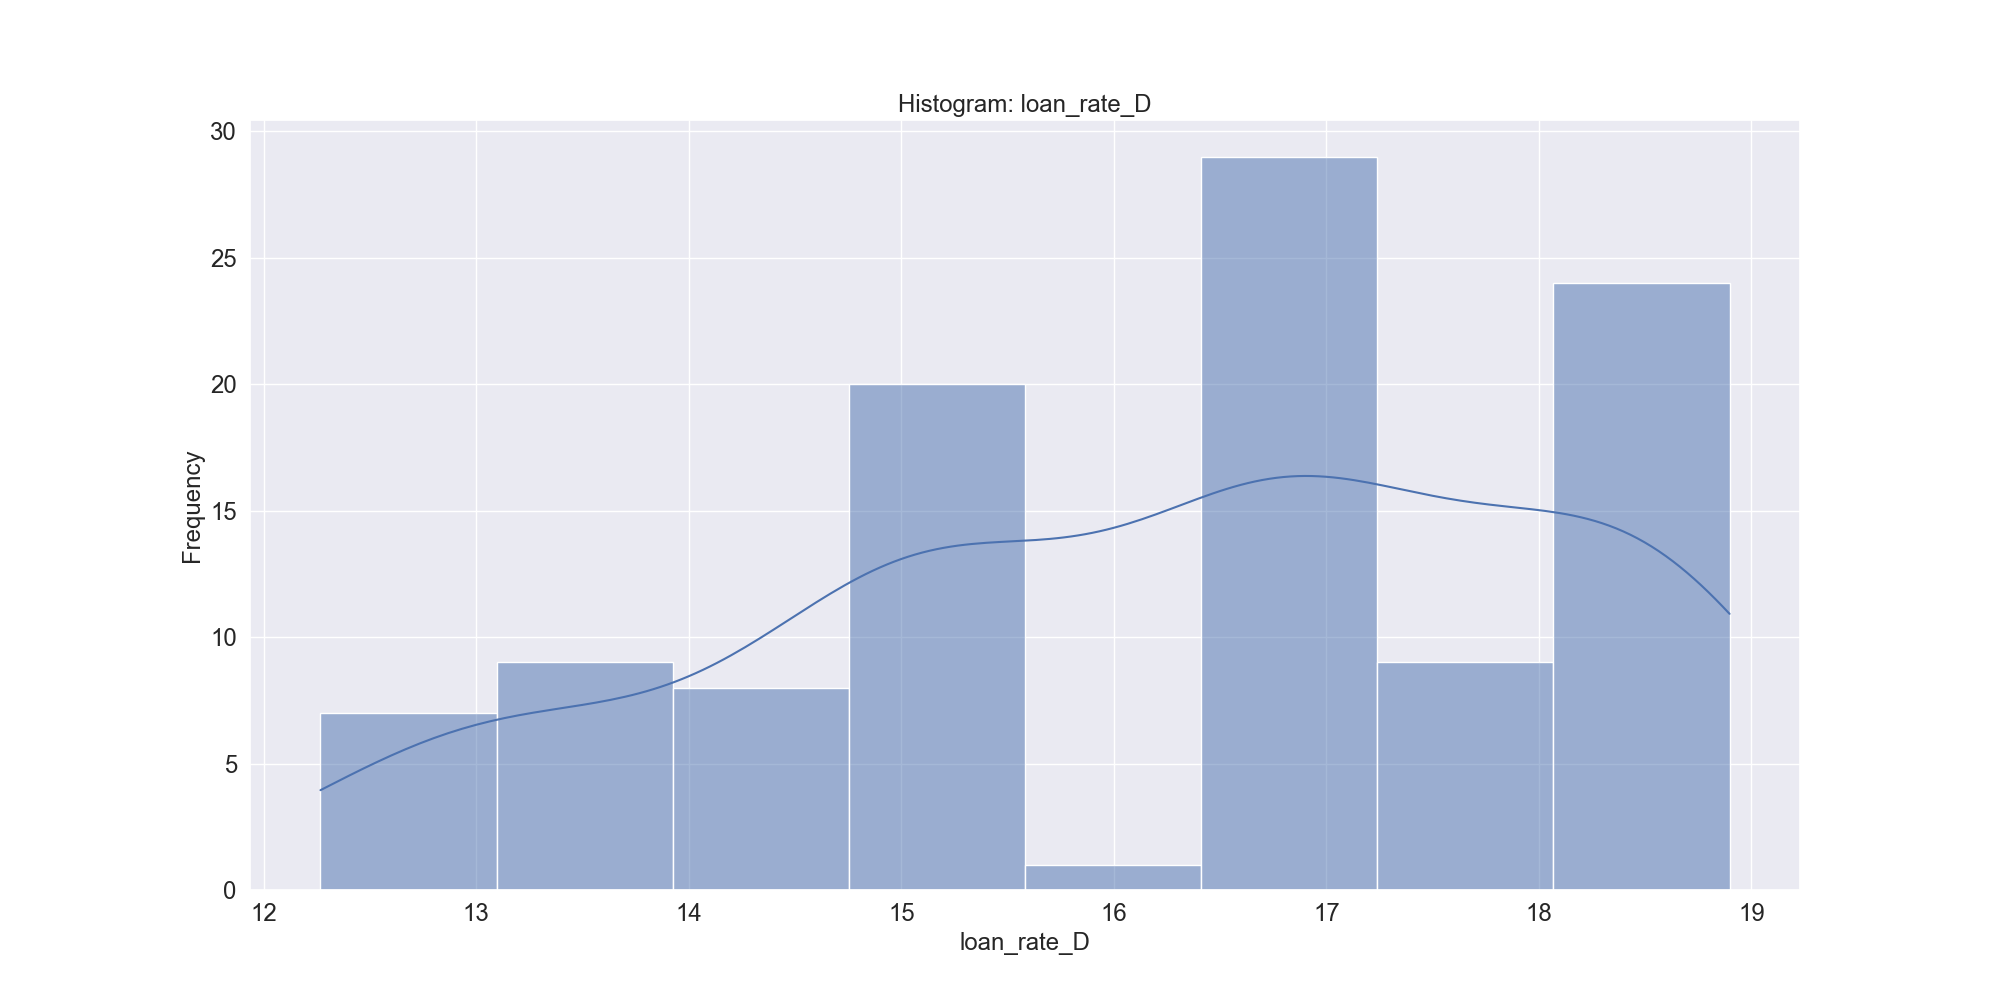
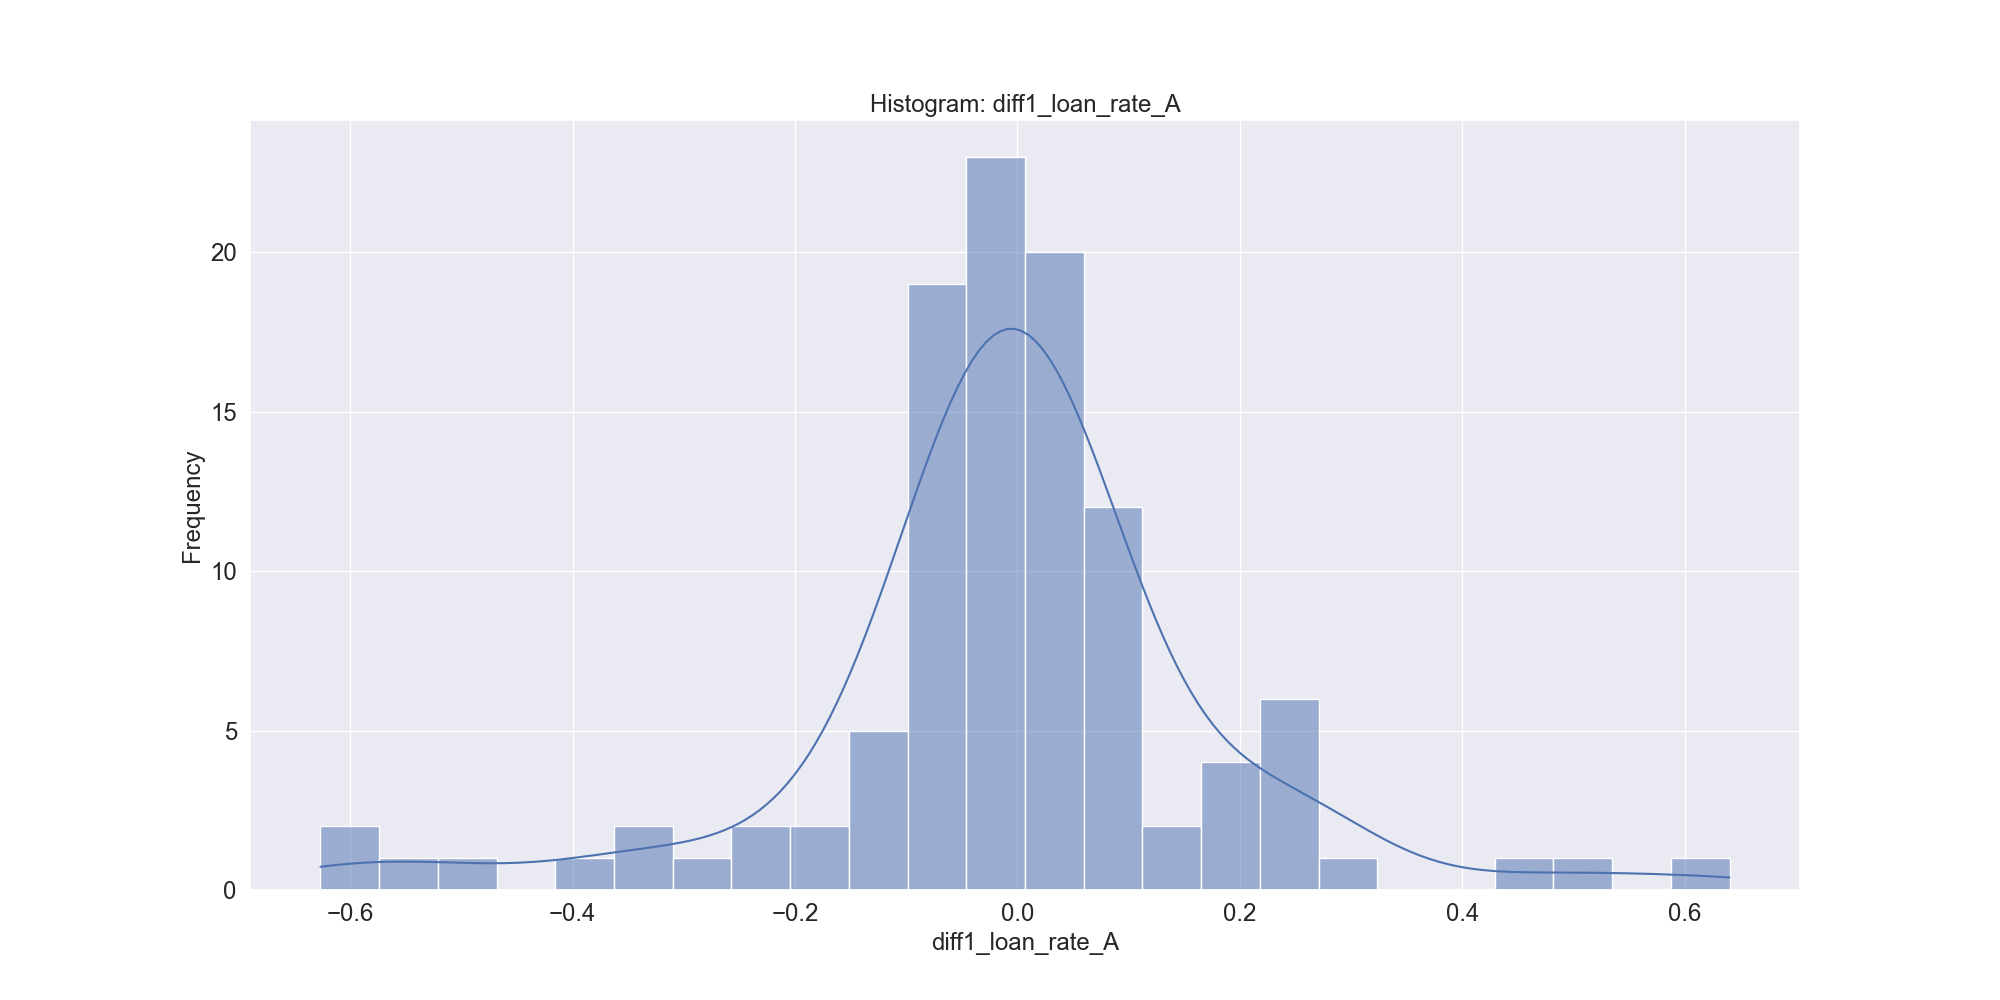
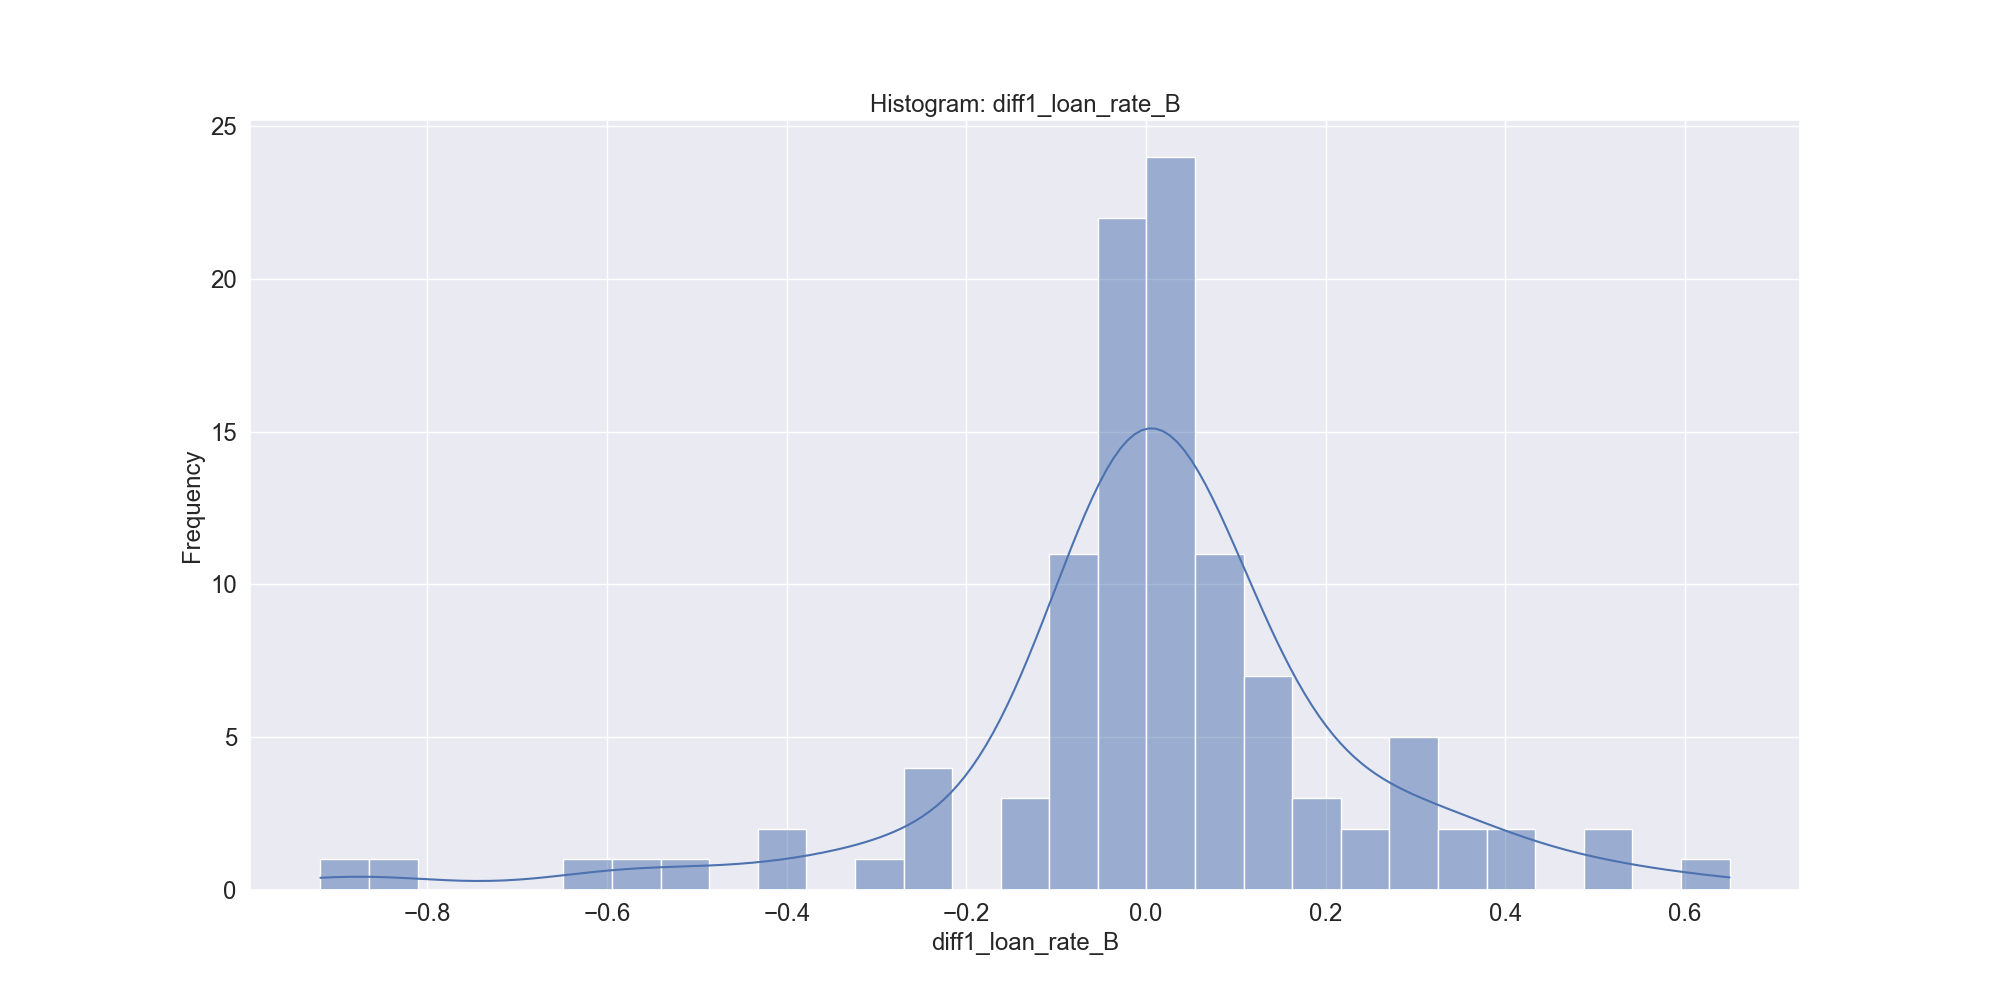
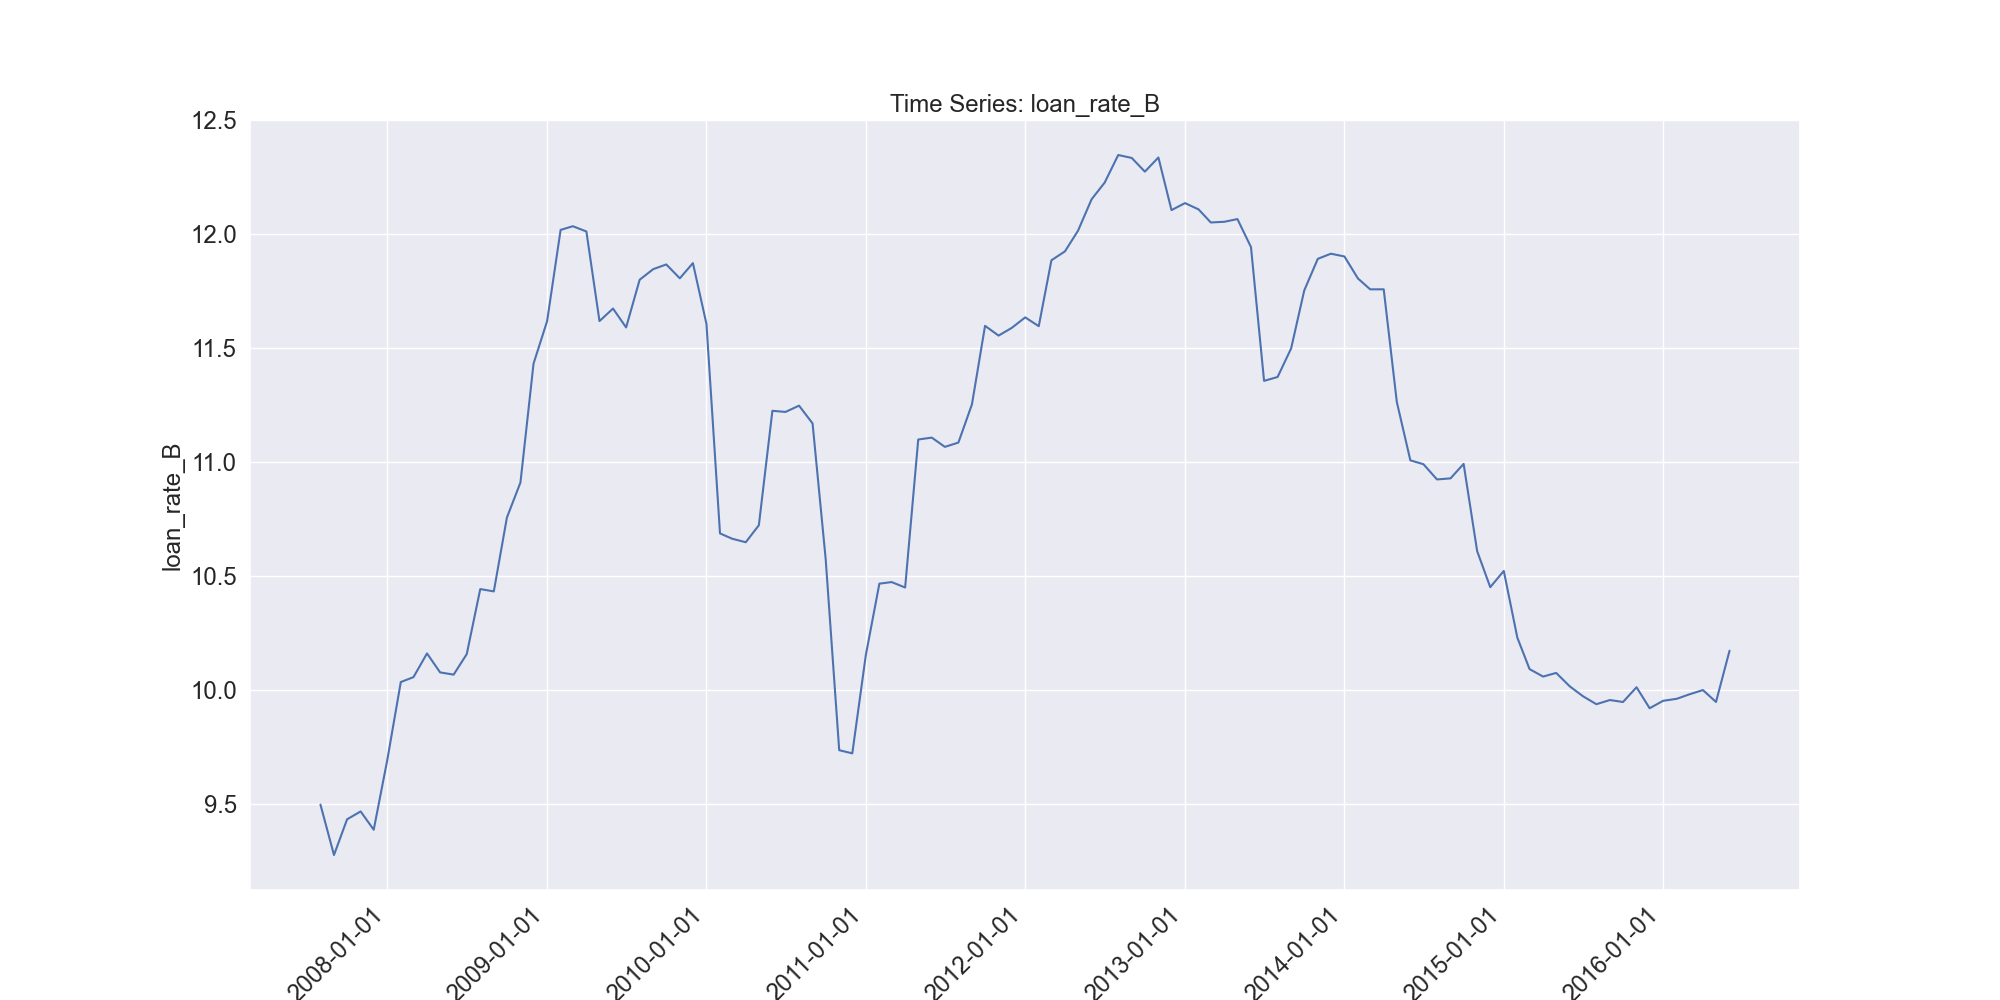
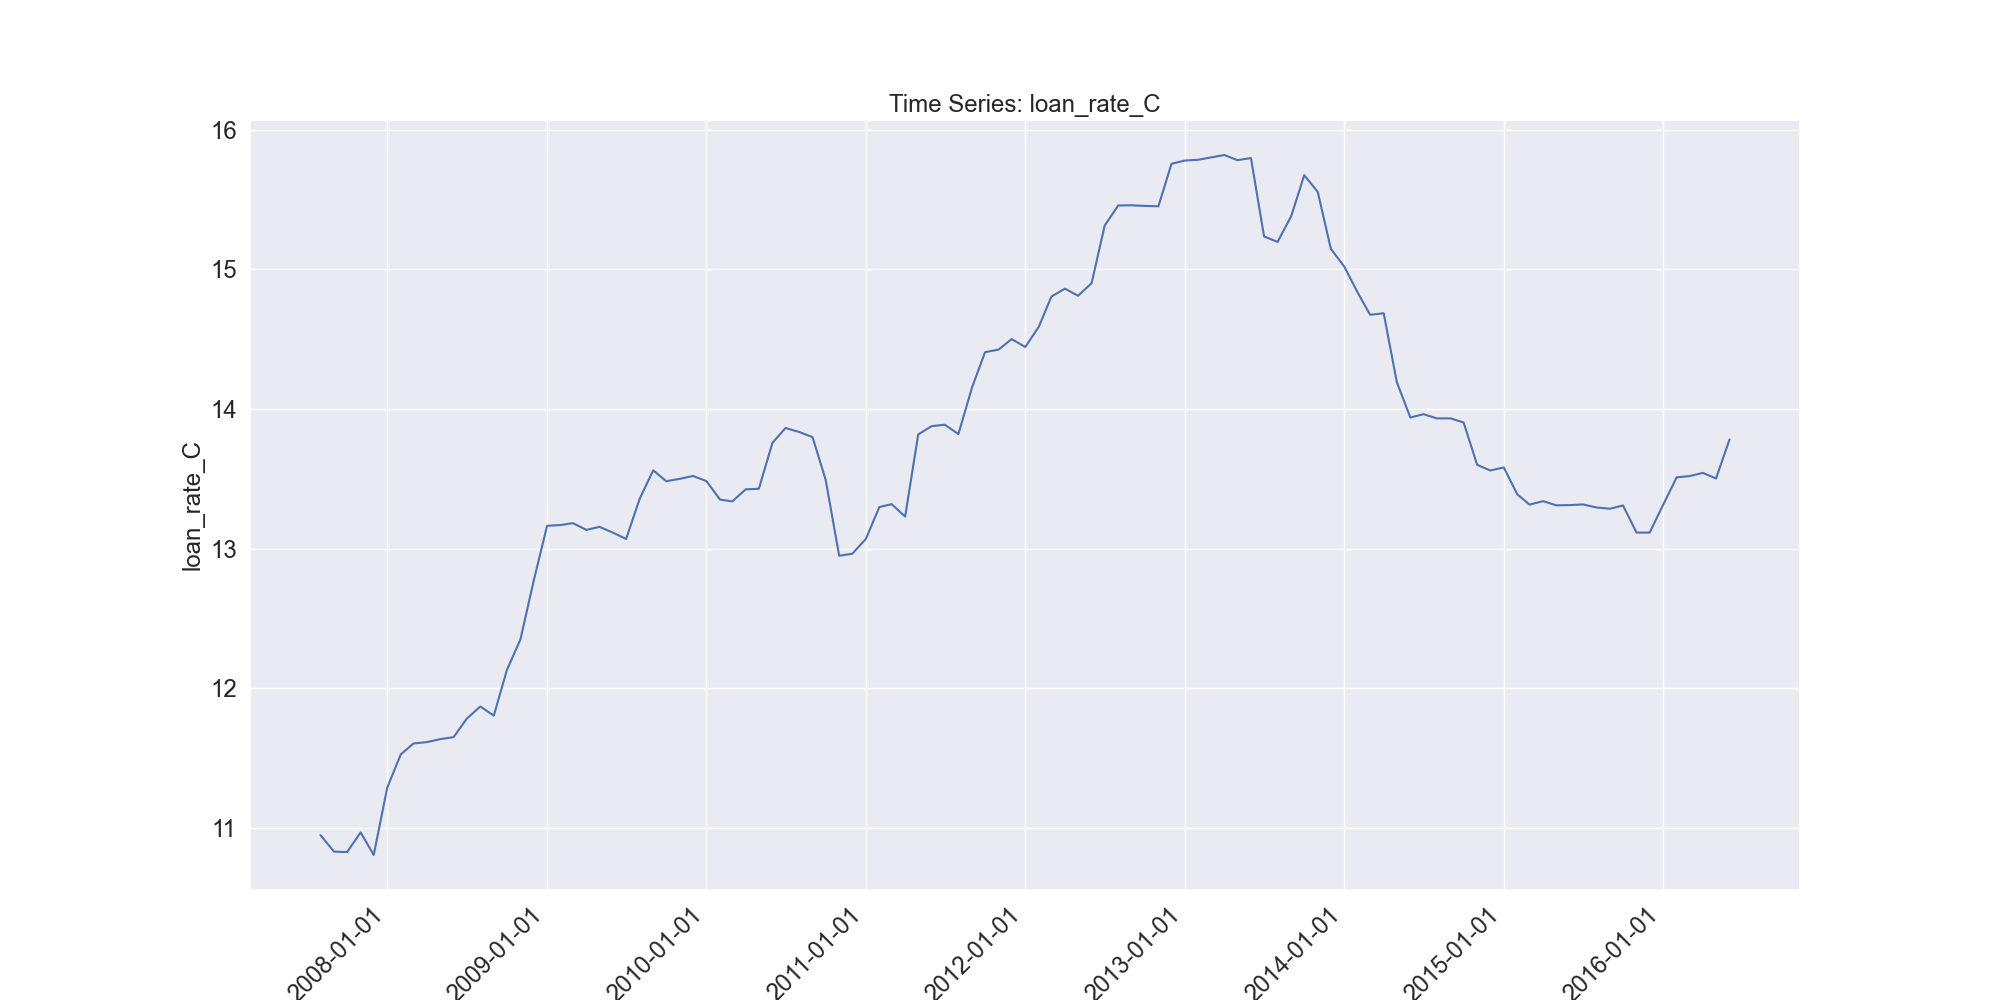
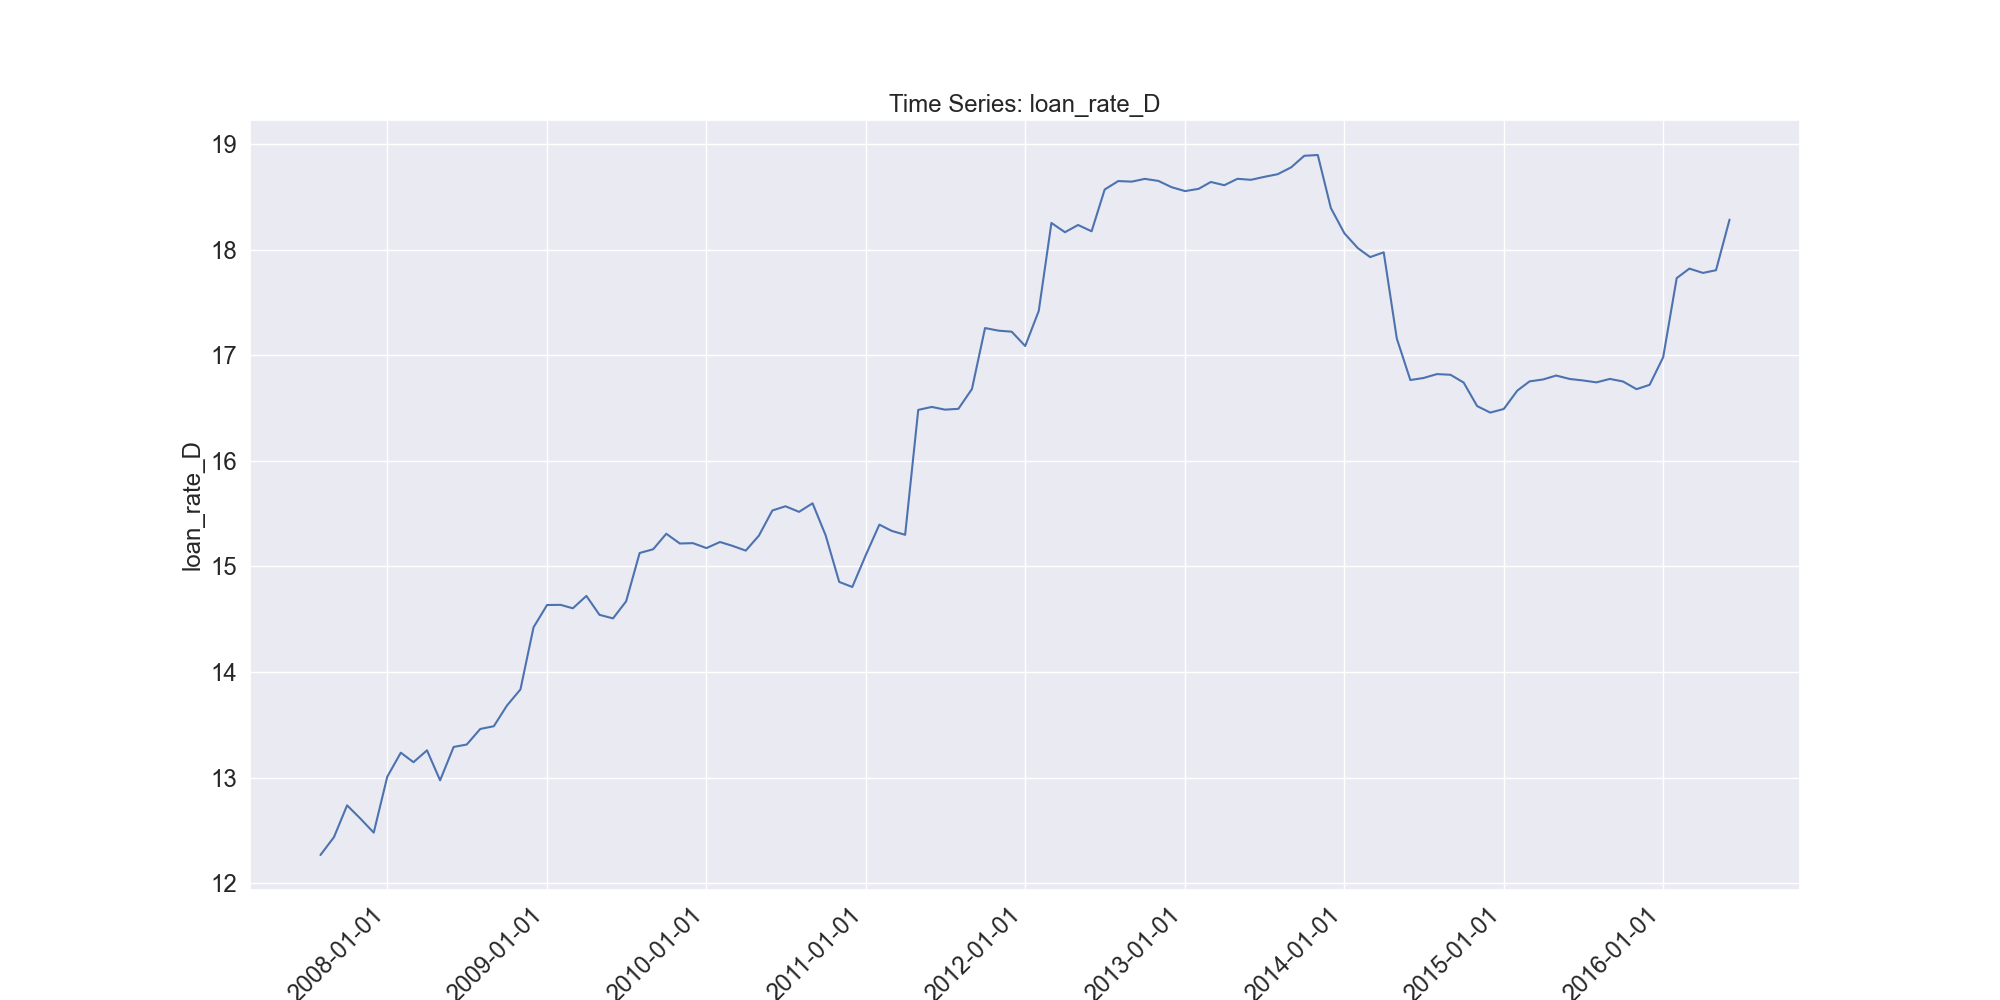
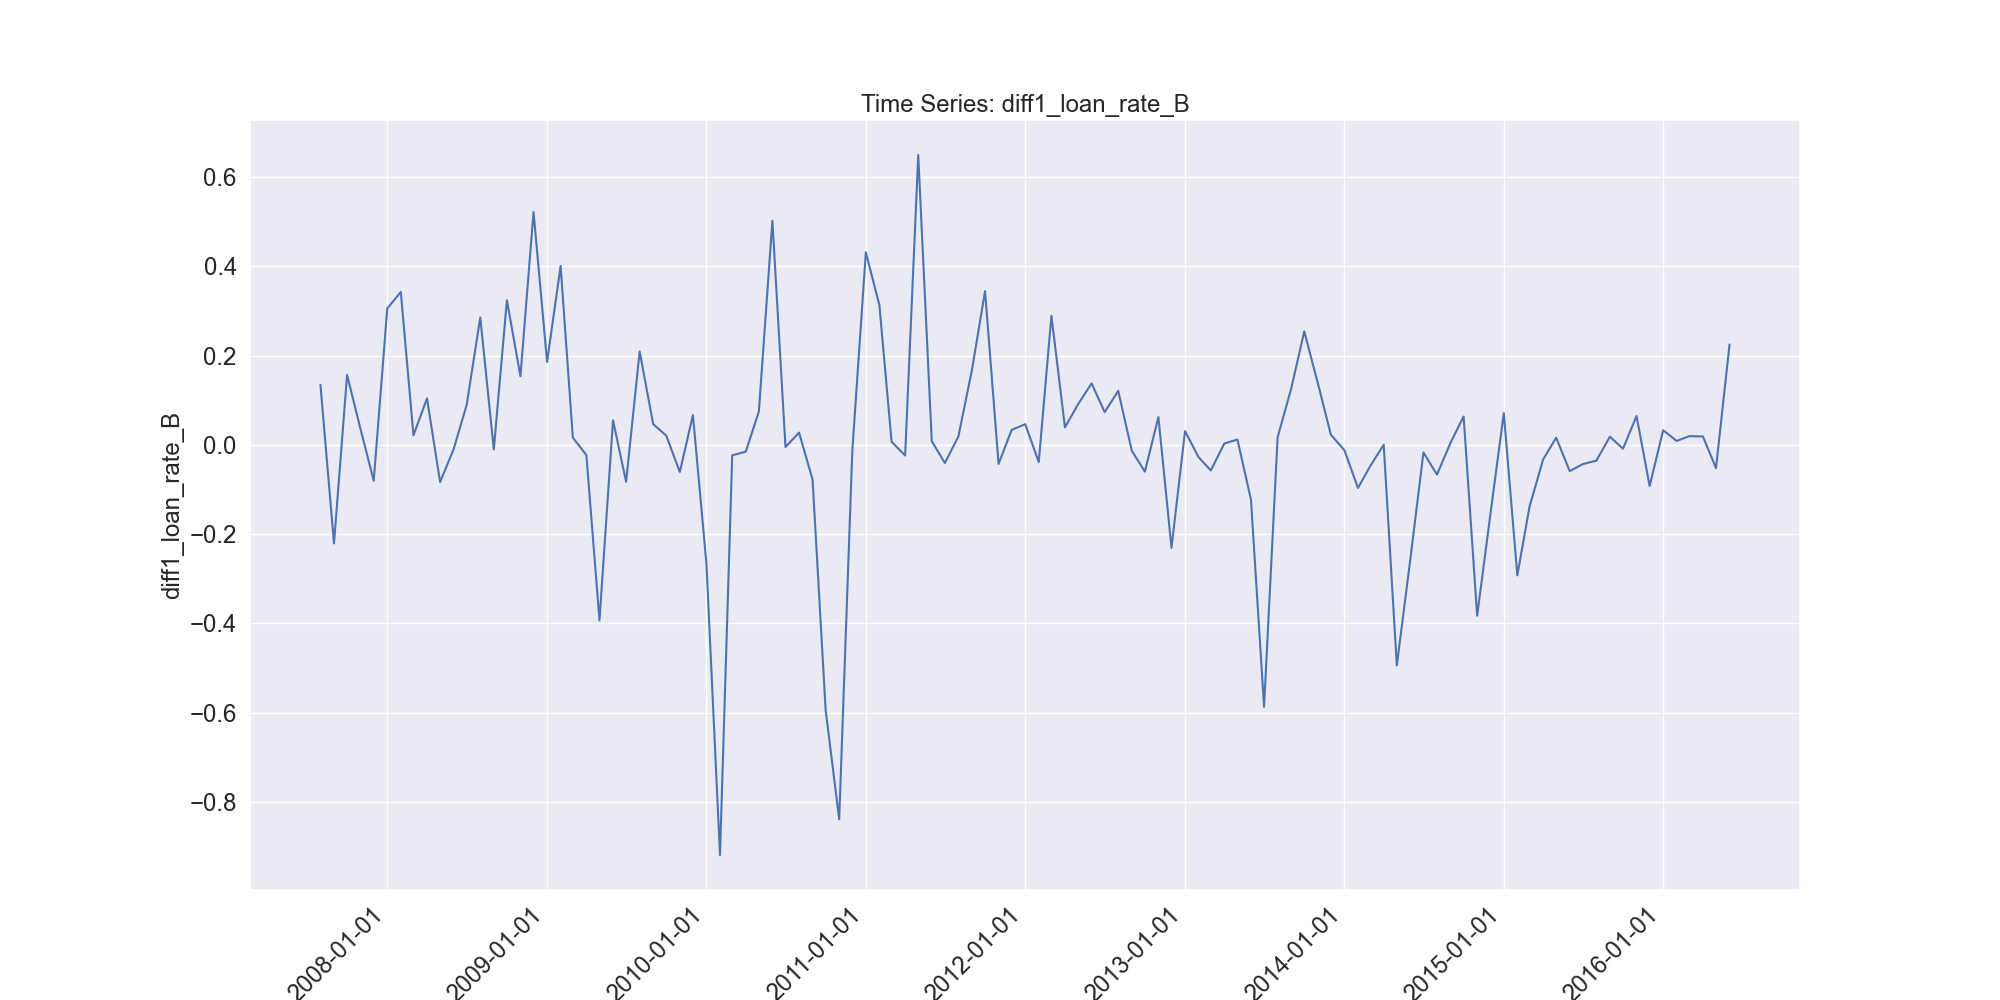

Running Metric: runs_test:  67%|██████▋   | 2/3 [00:00<00:00, 61.45it/s]                     

Running Metric: lilliefors_test:  75%|███████▌  | 3/4 [00:00<00:00, 157.22it/s]    


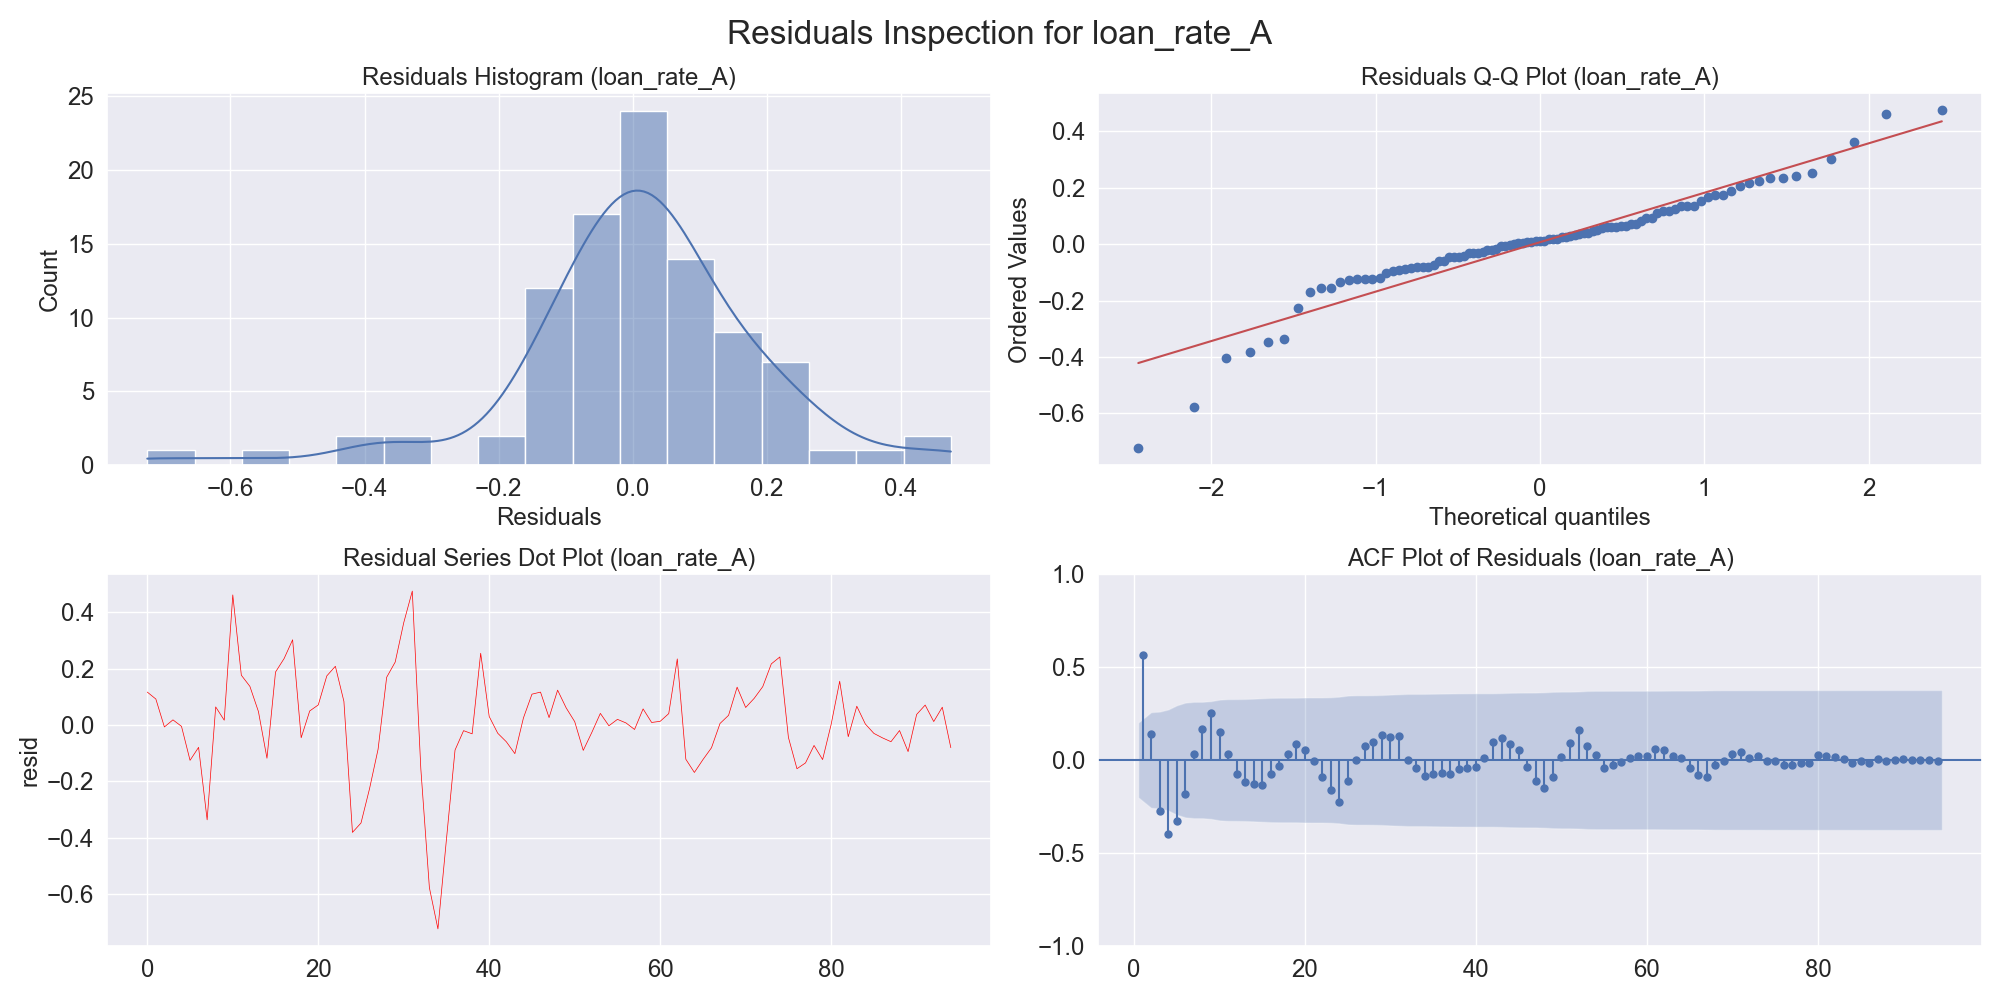
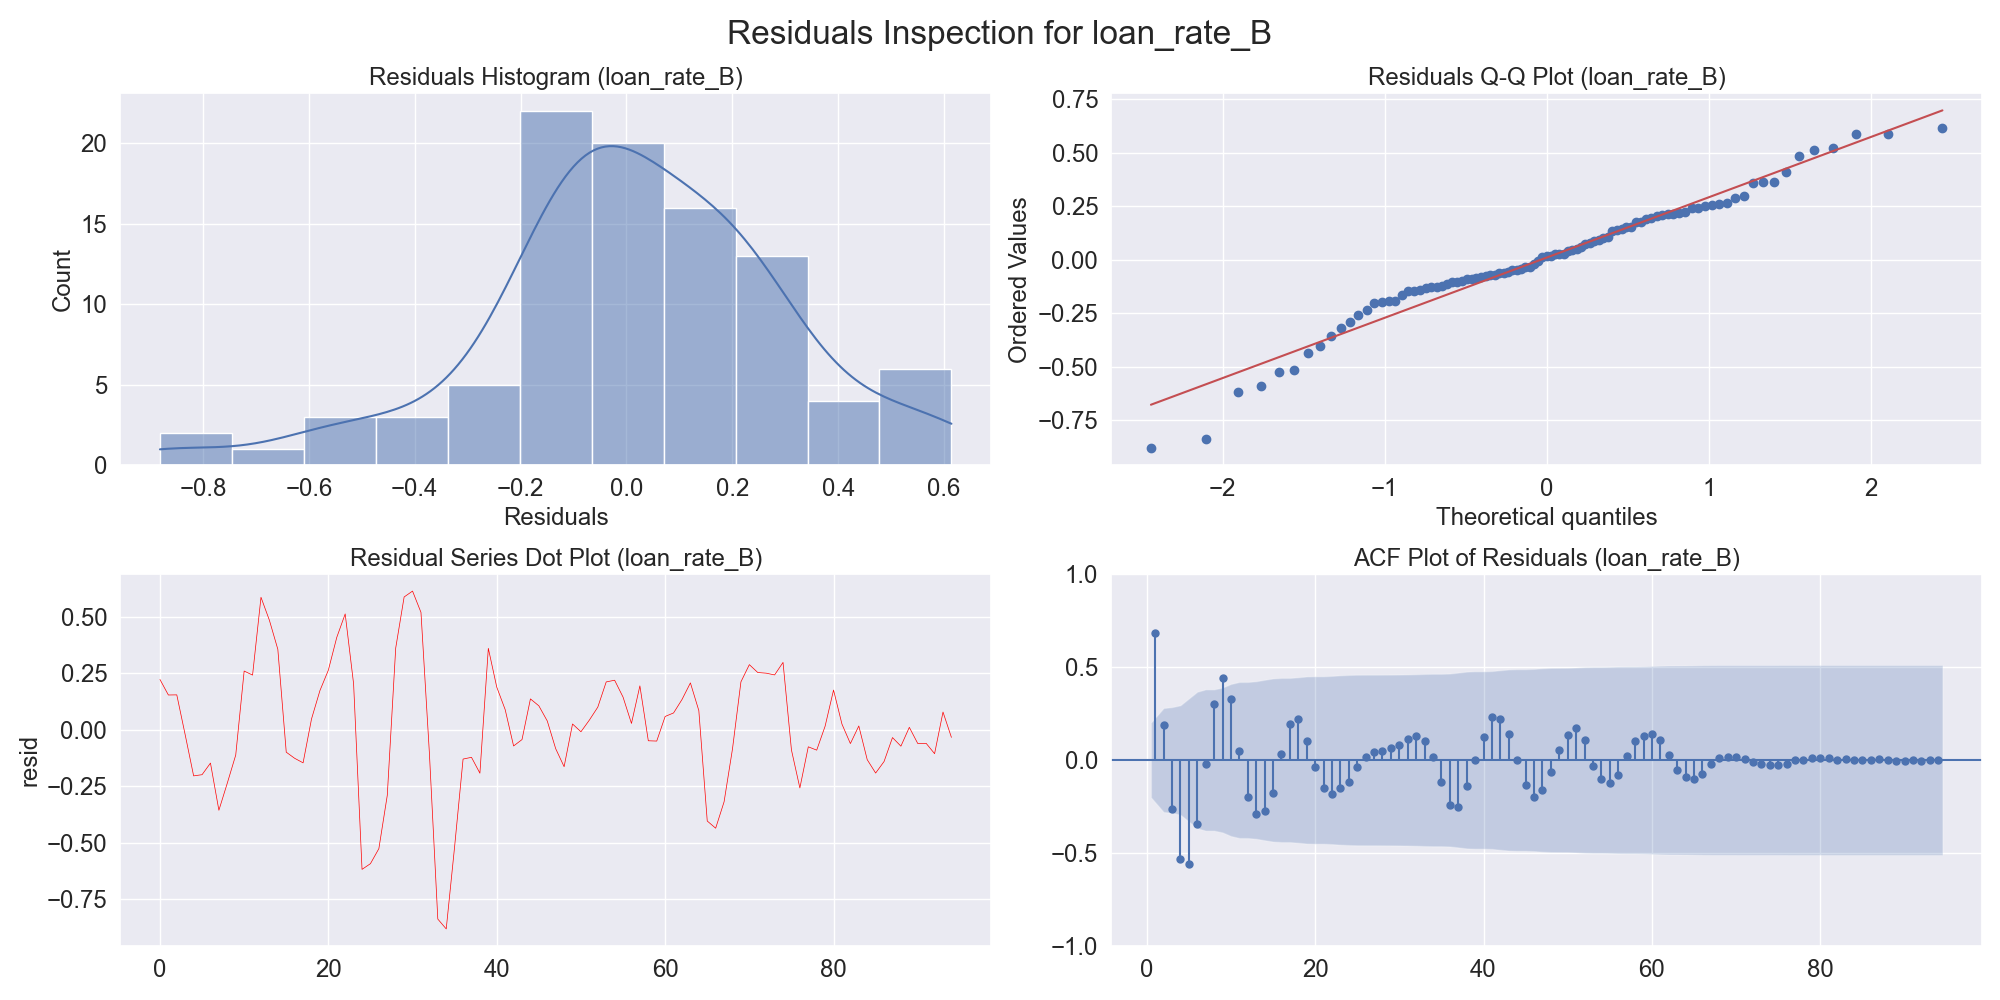
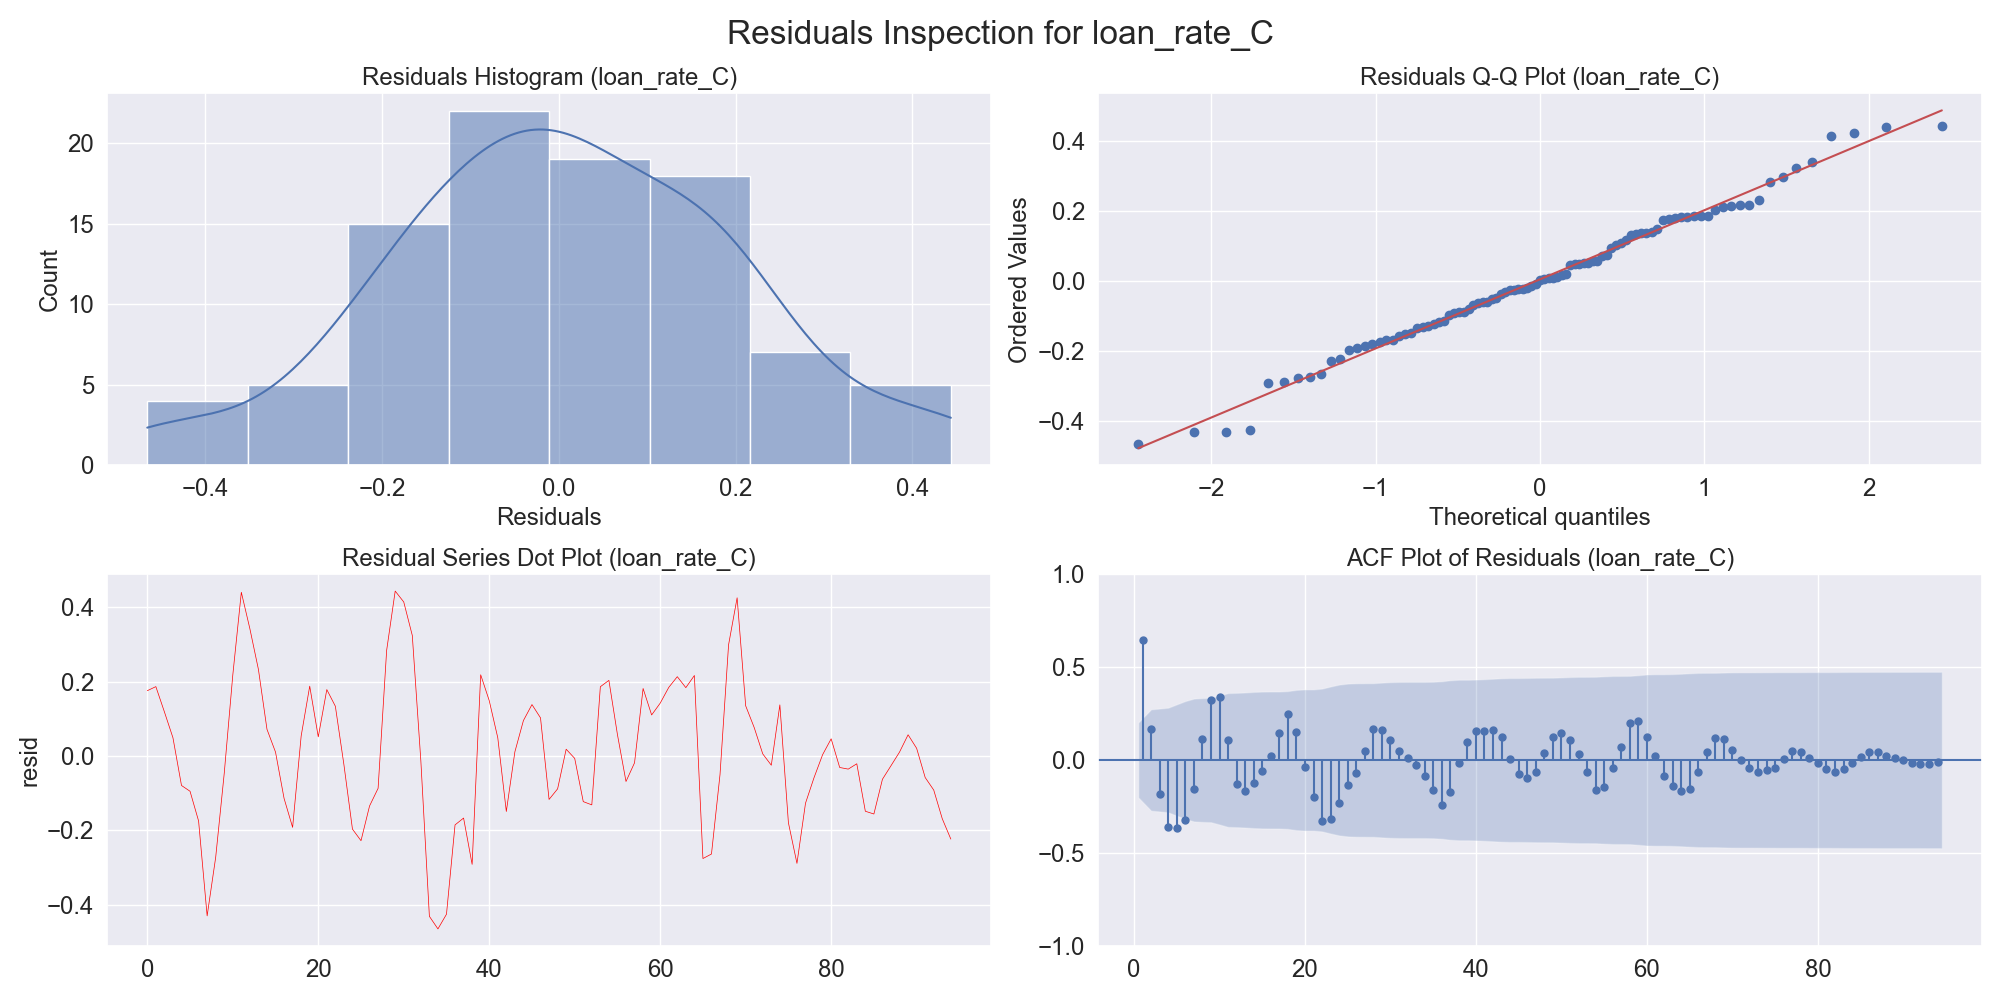
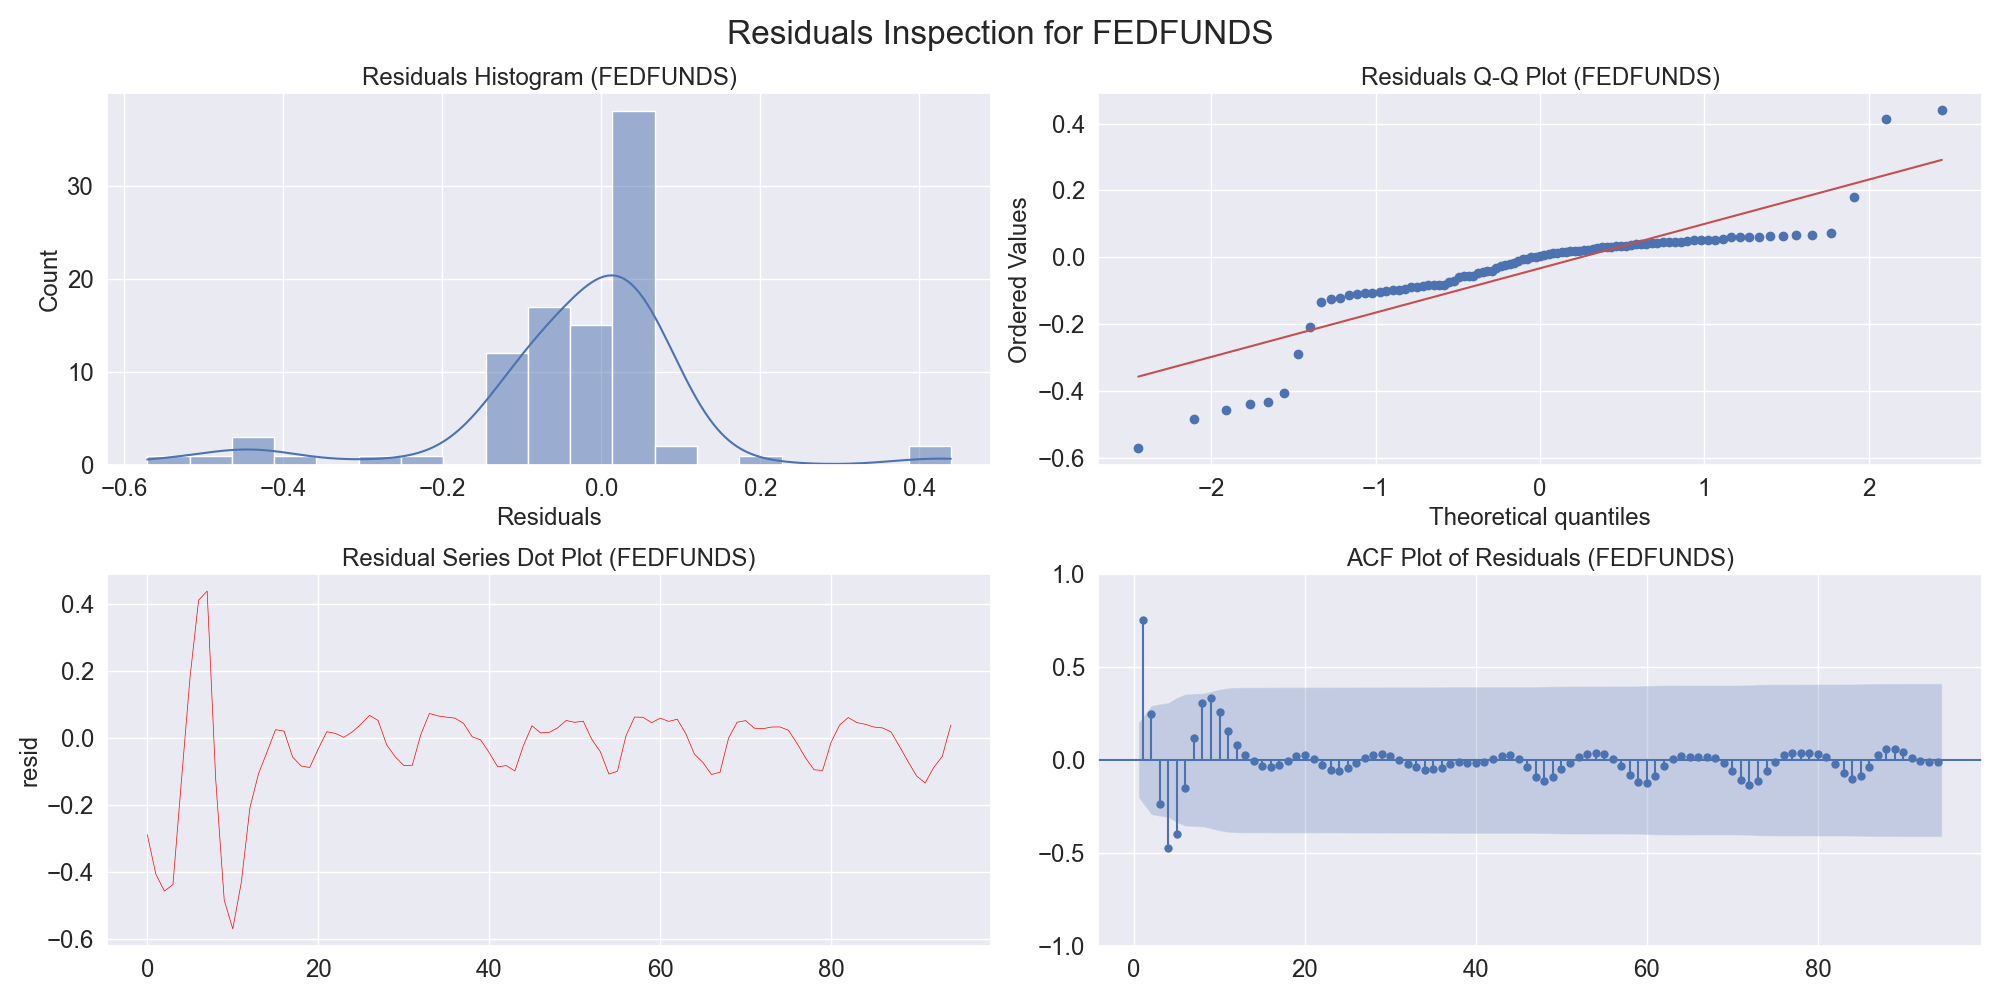
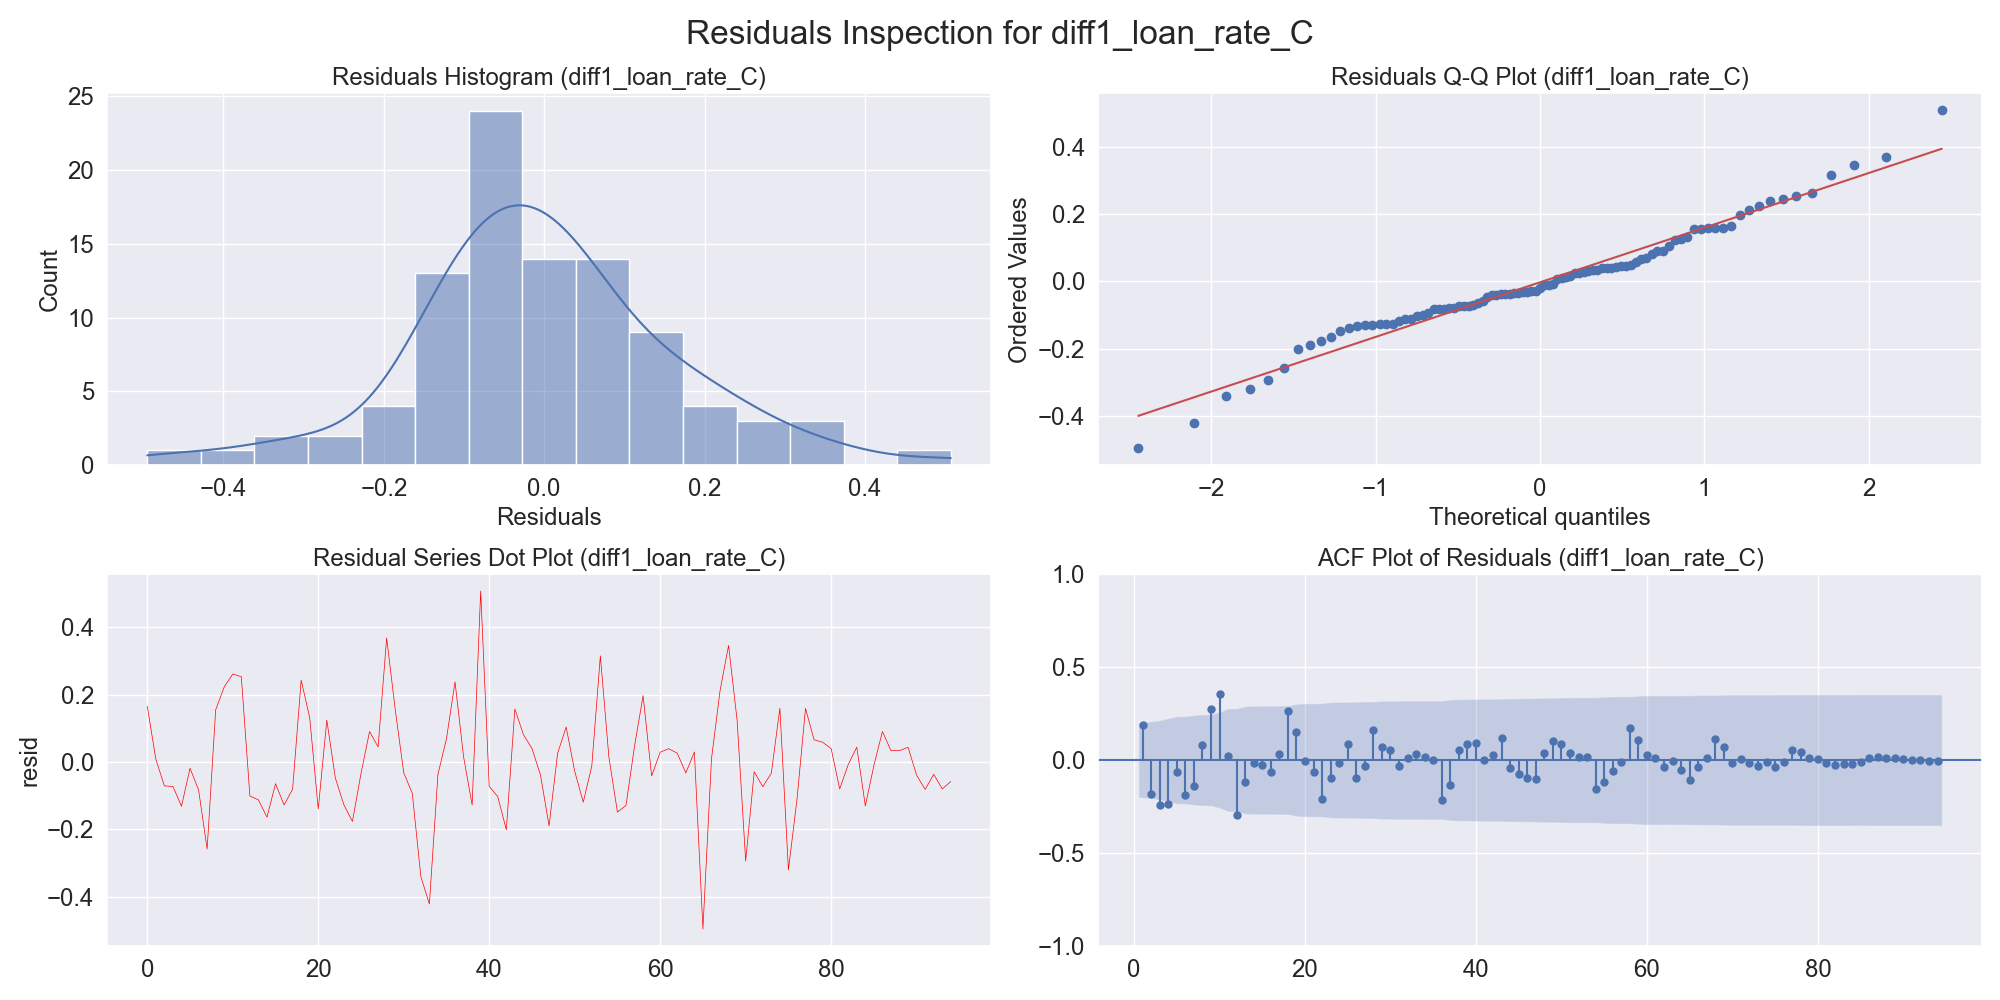
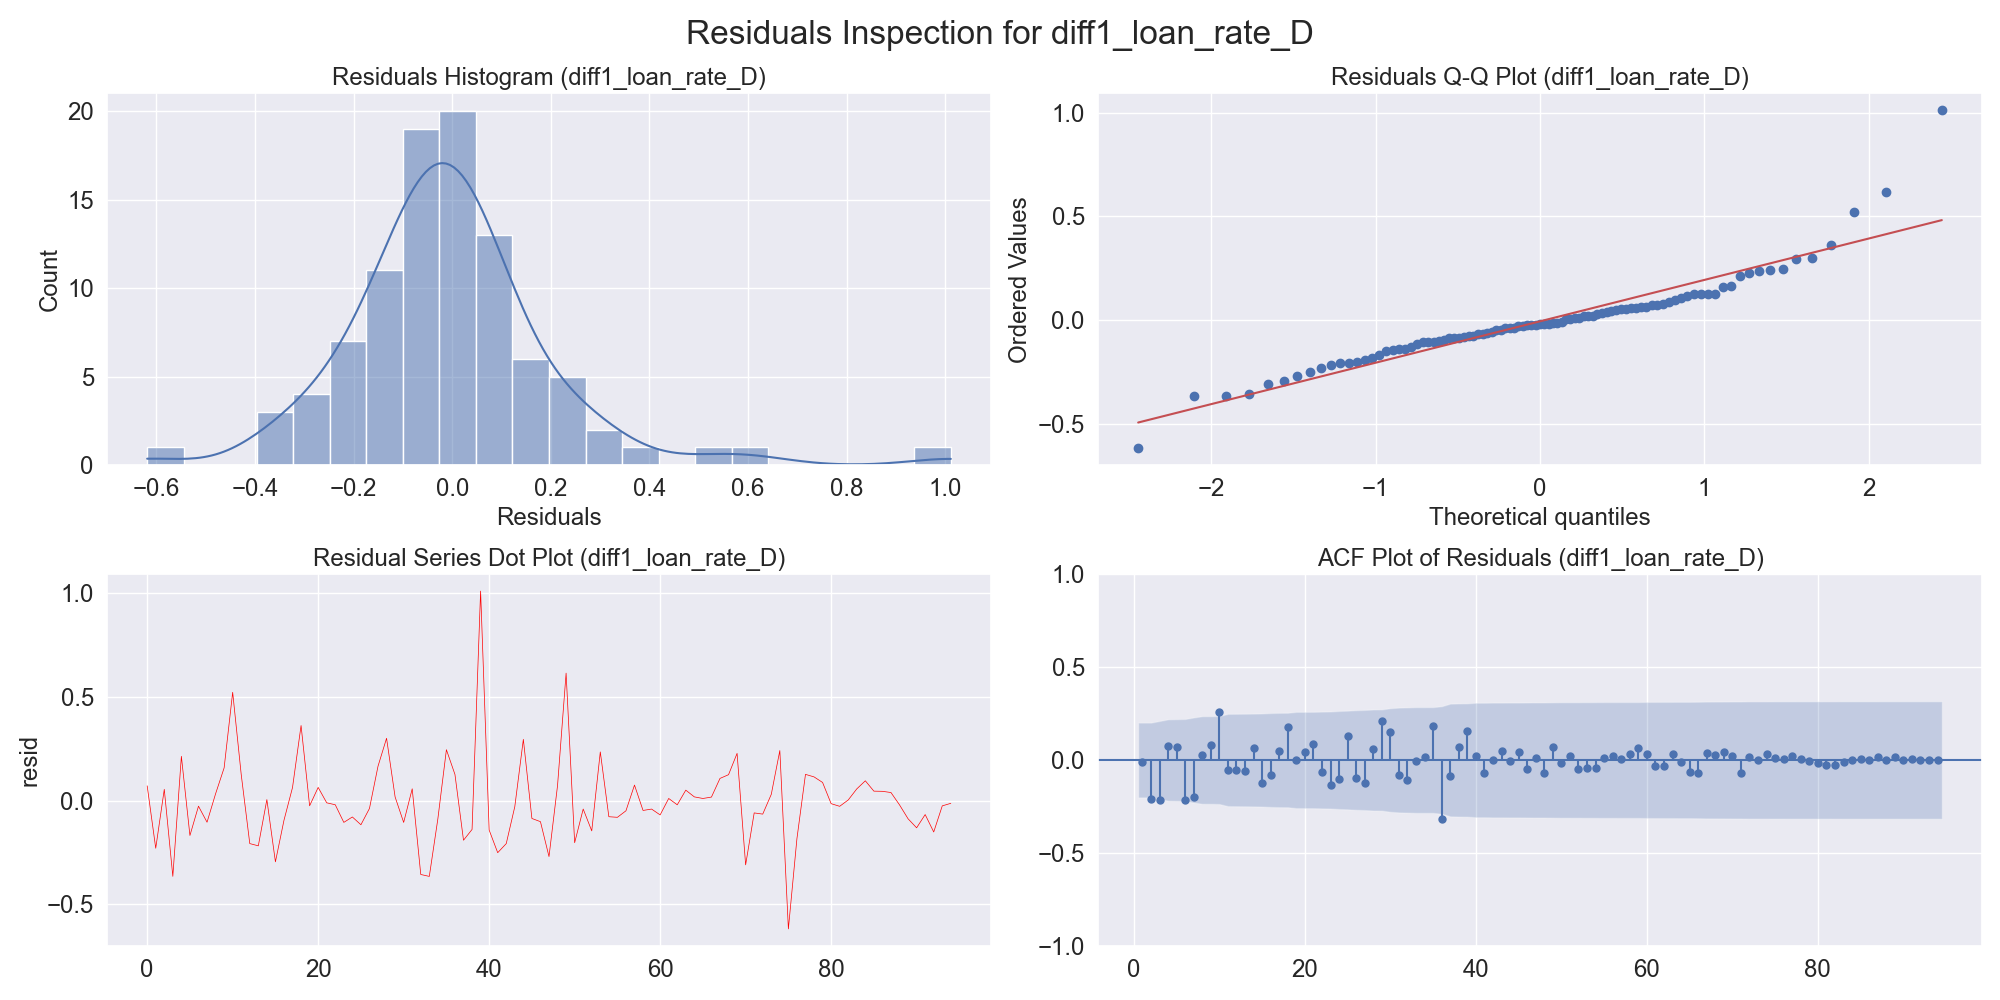
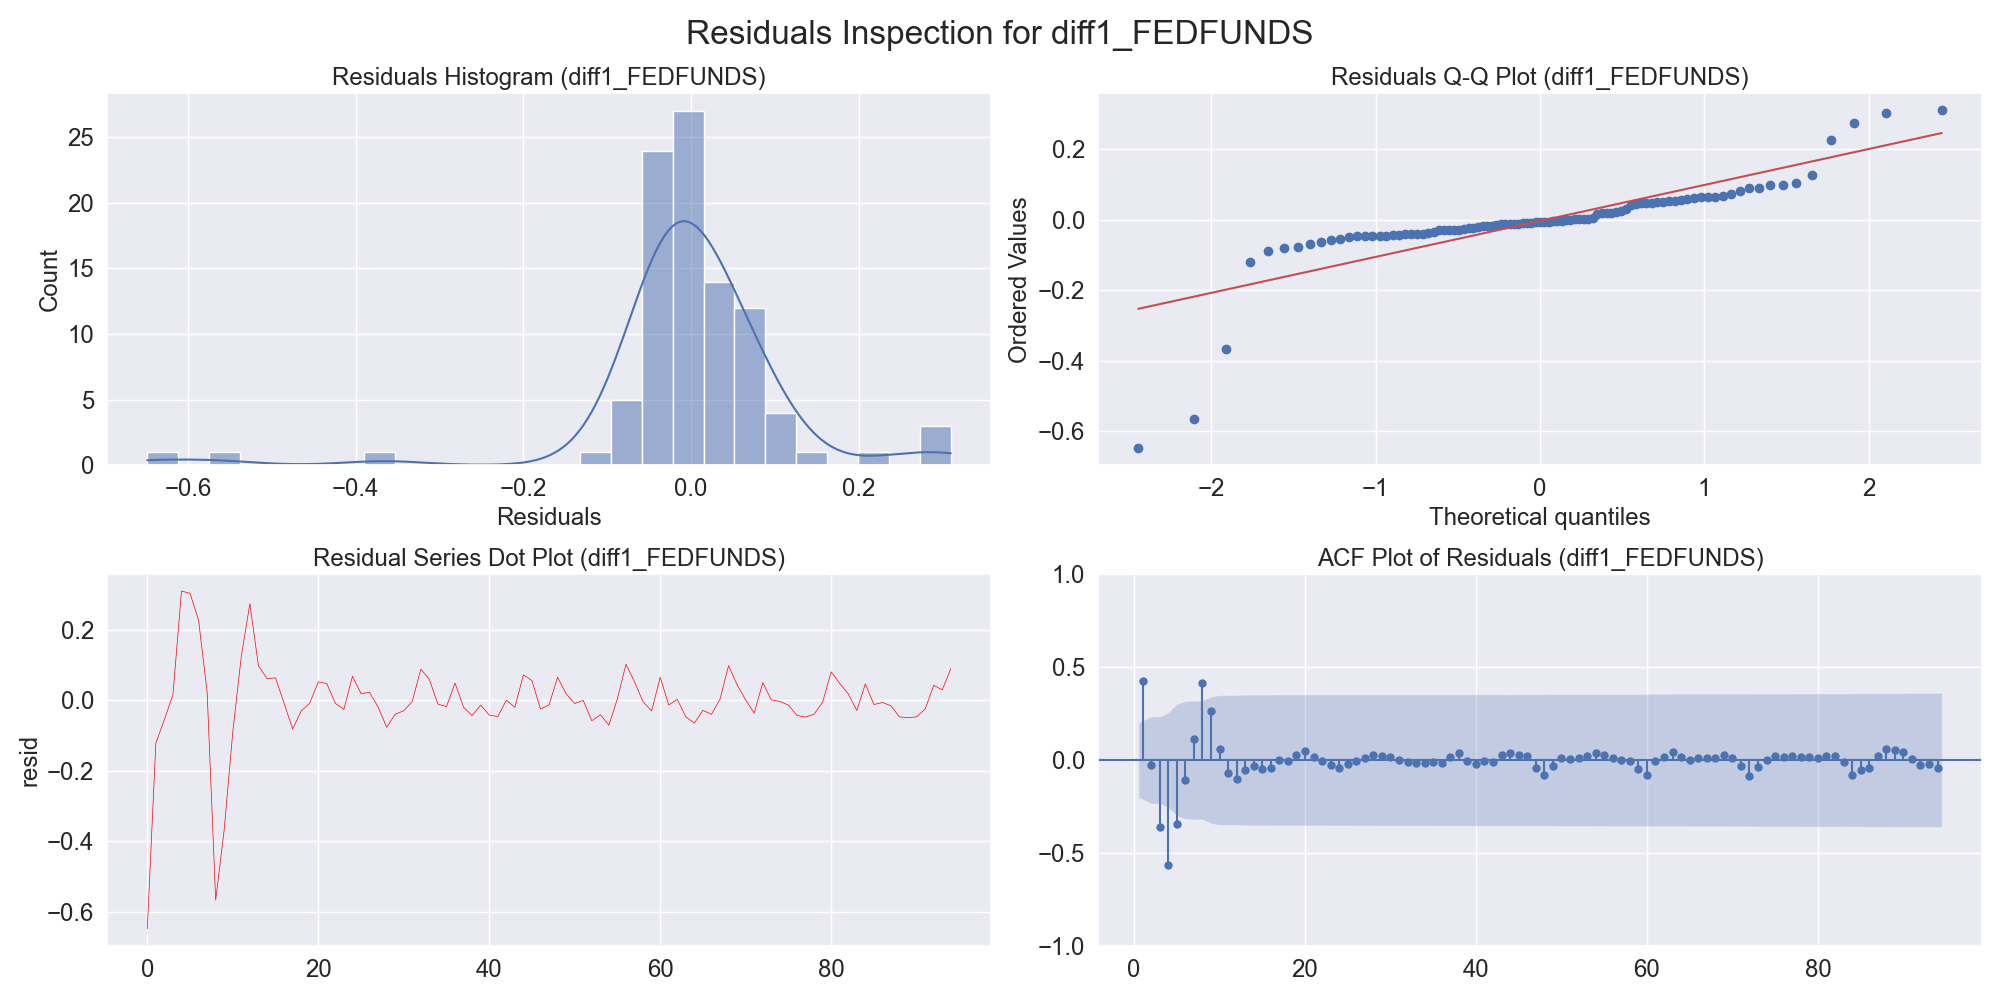
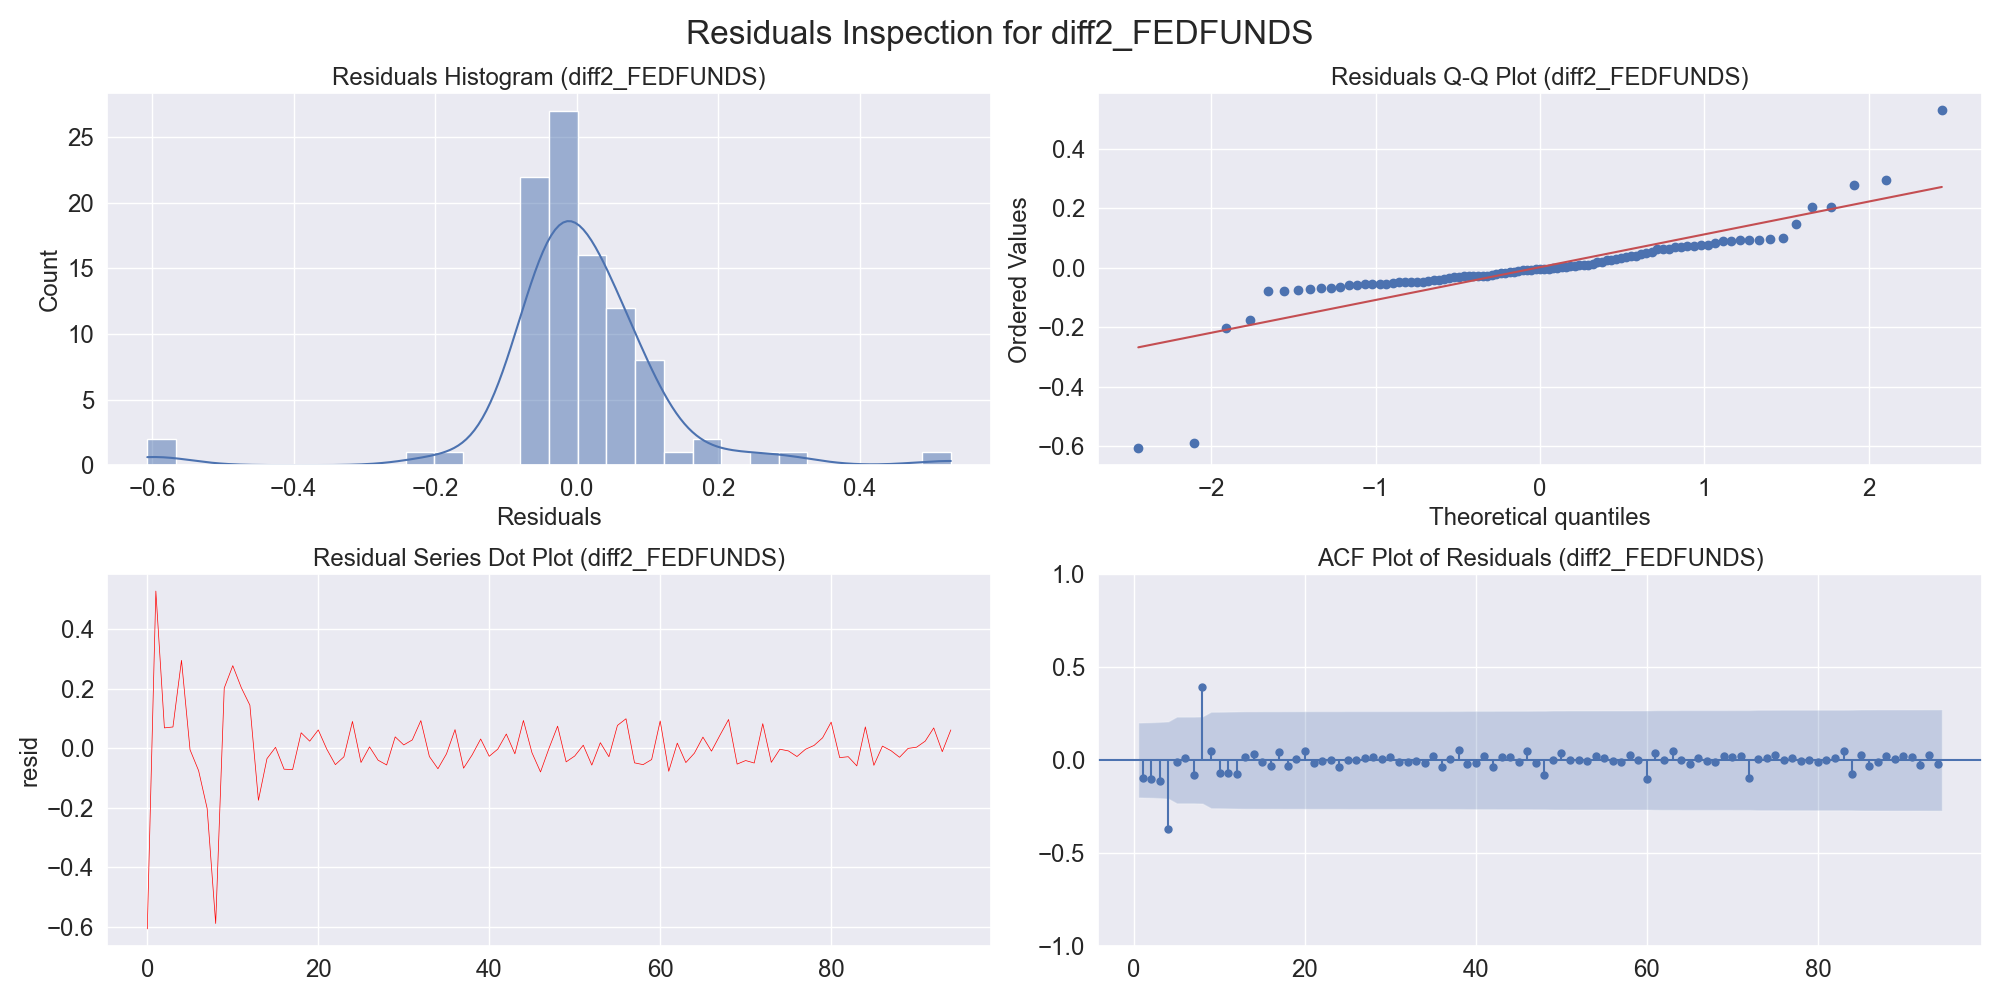


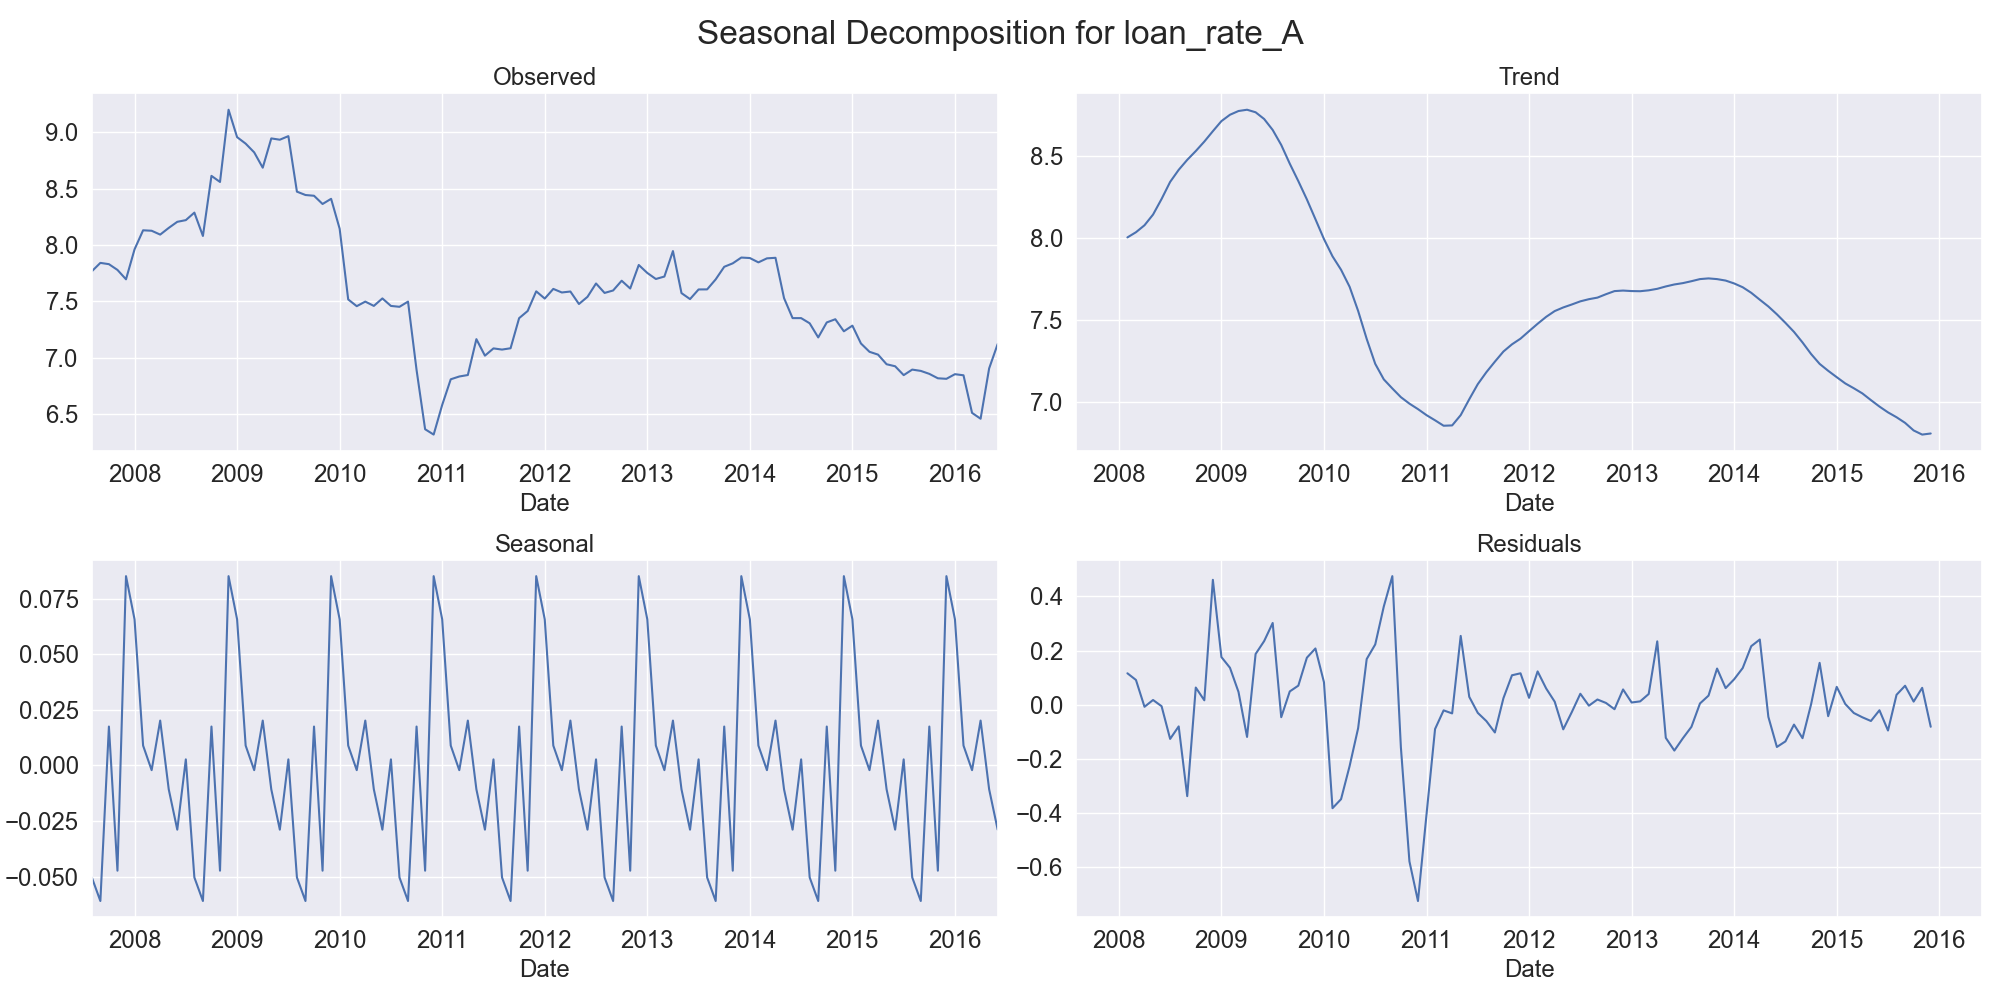
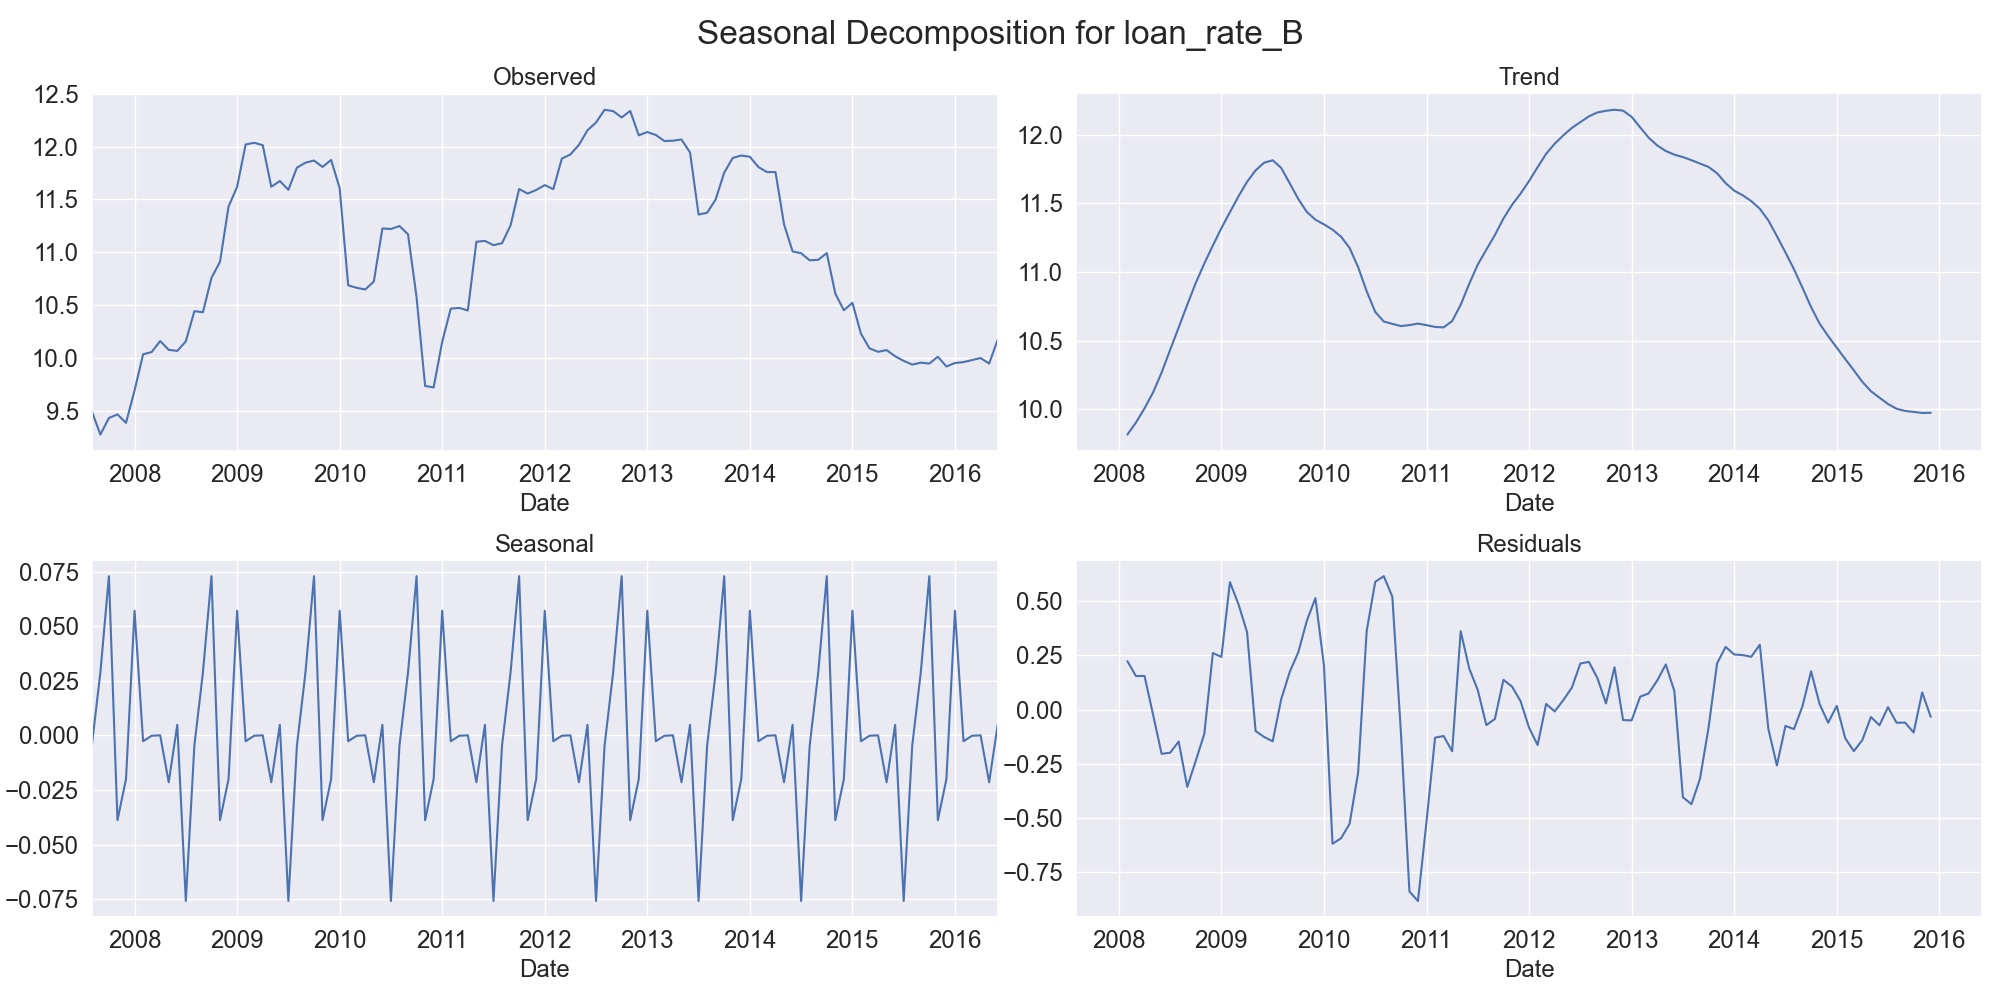
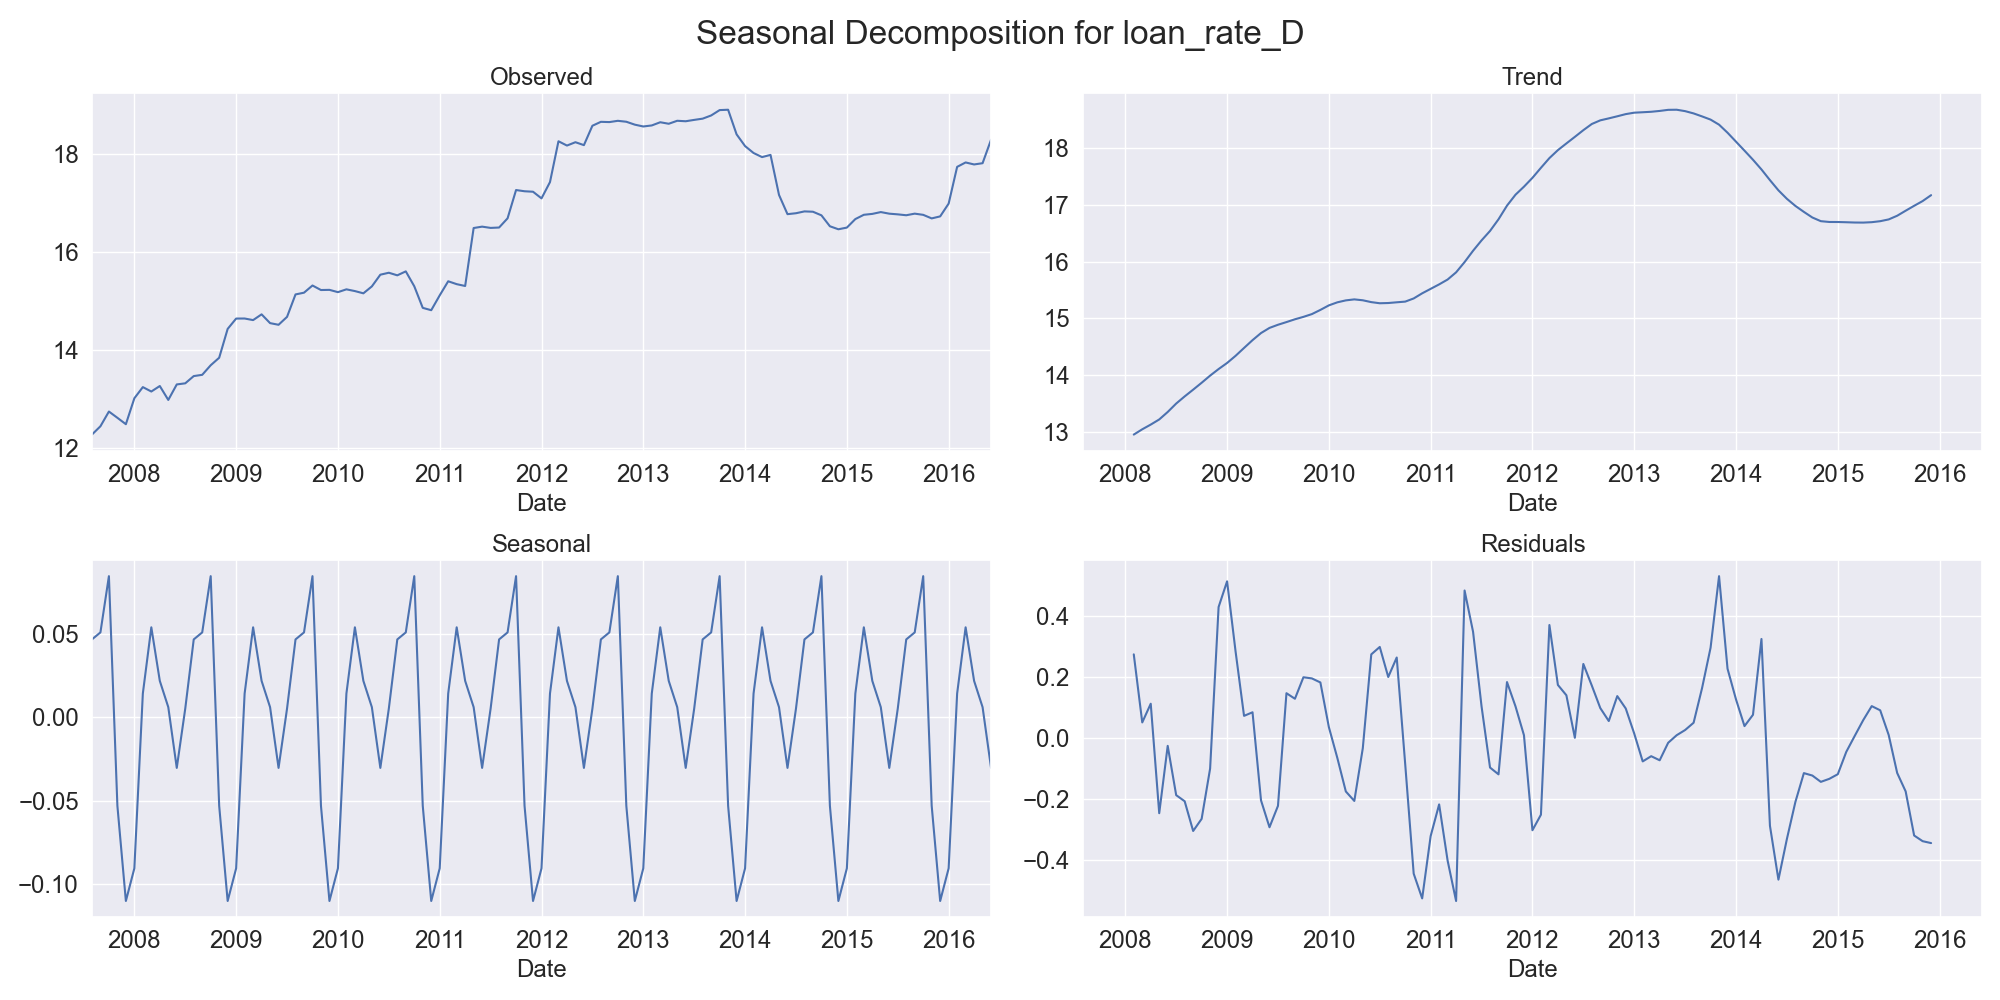
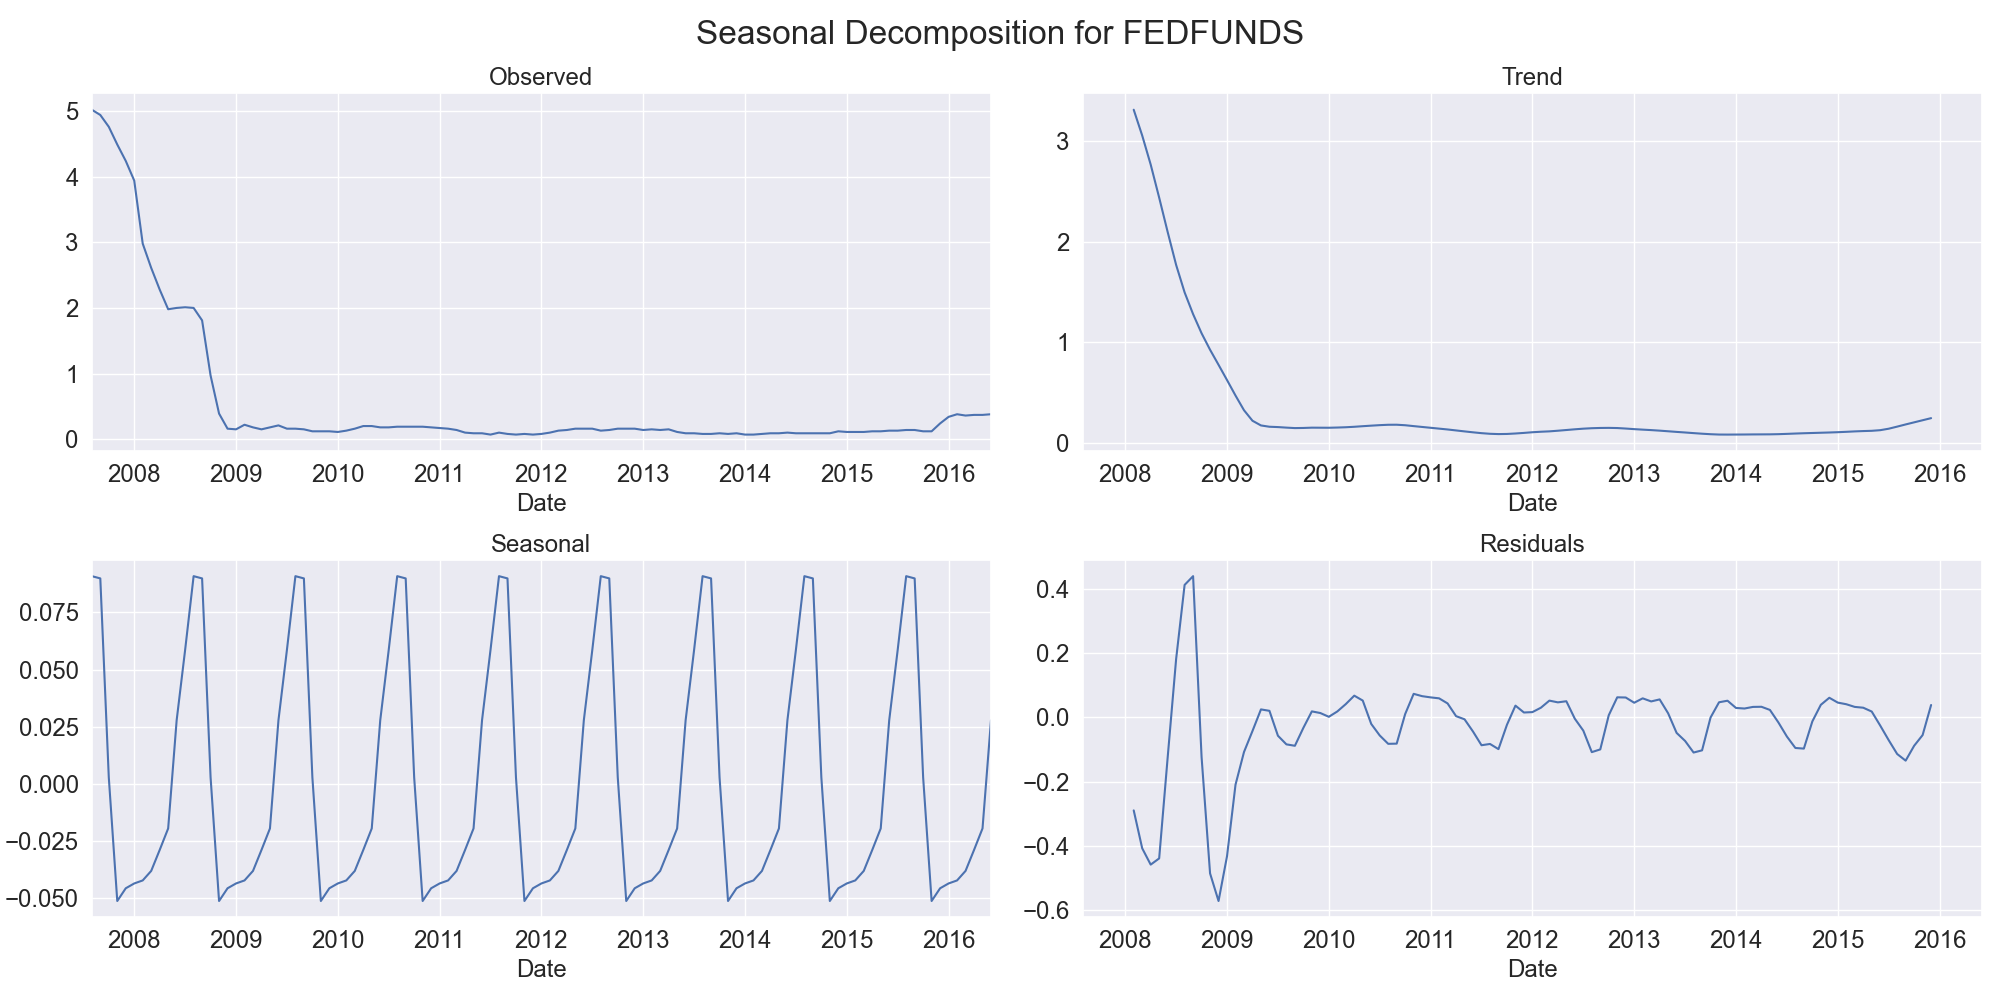
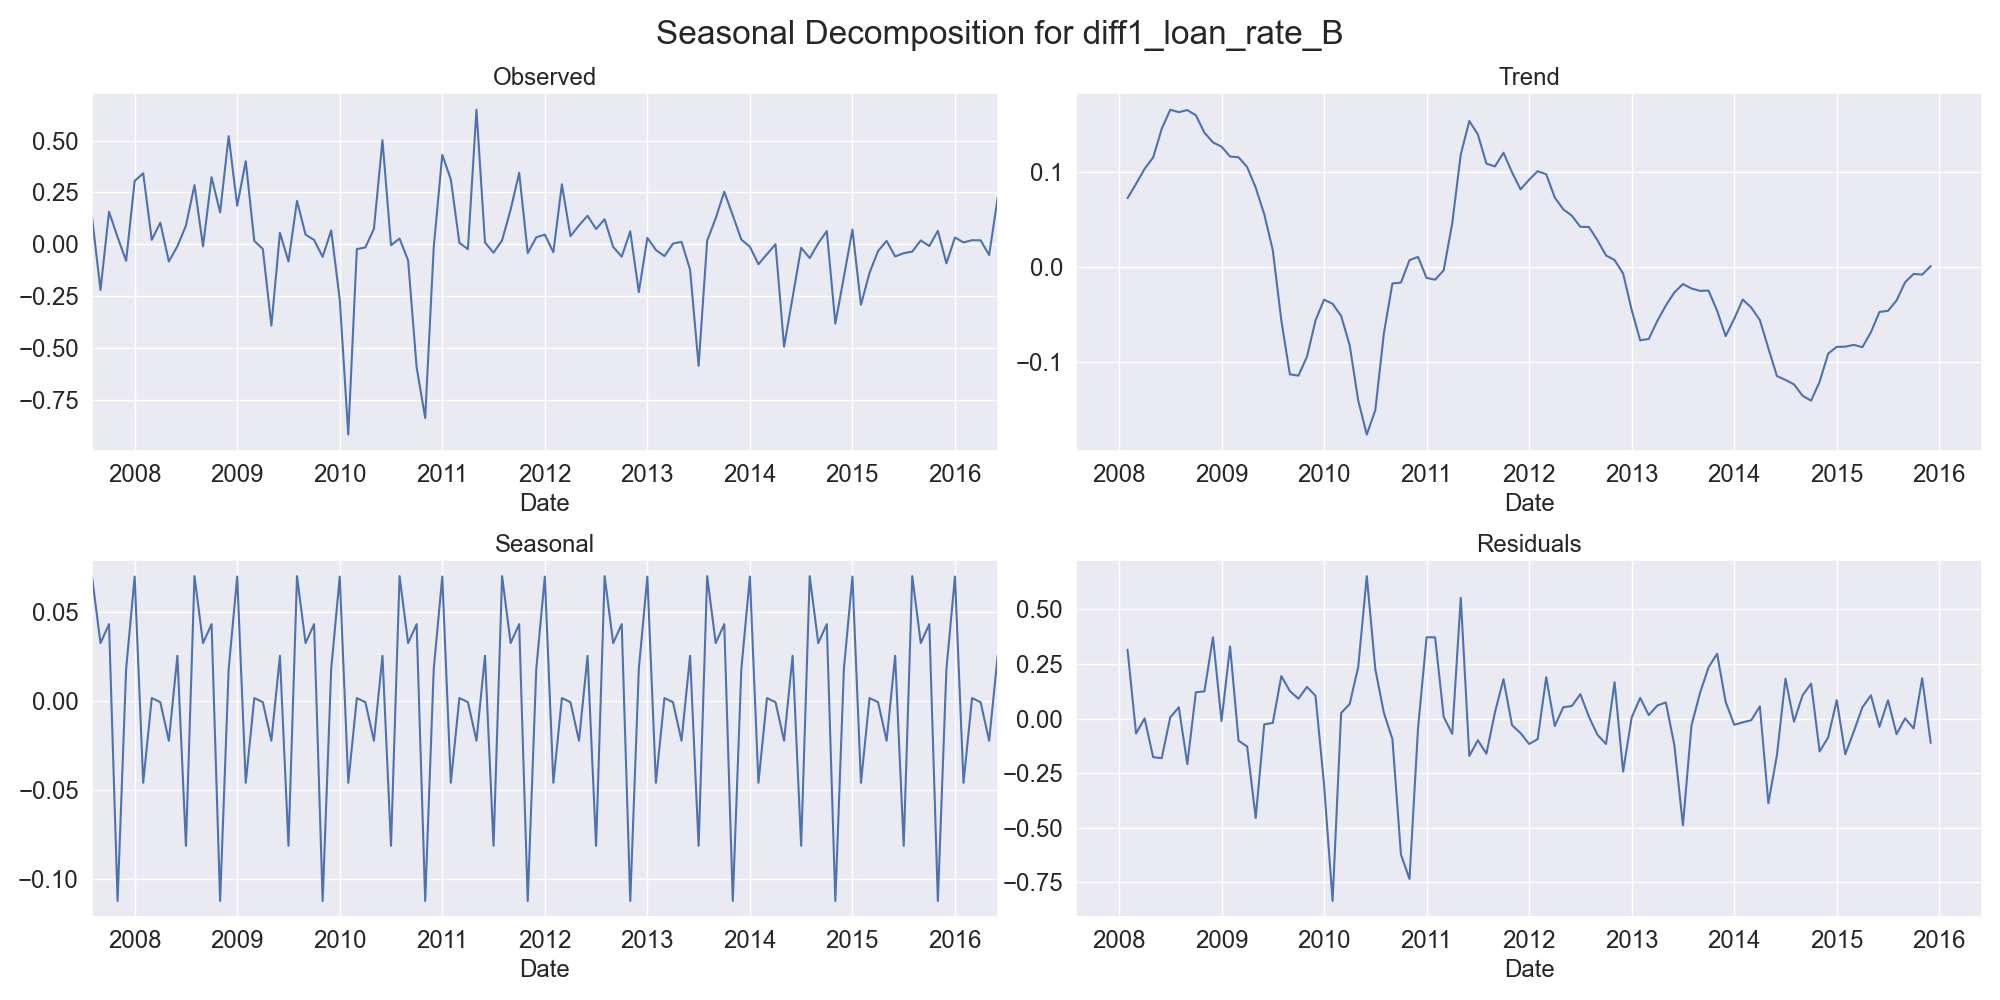
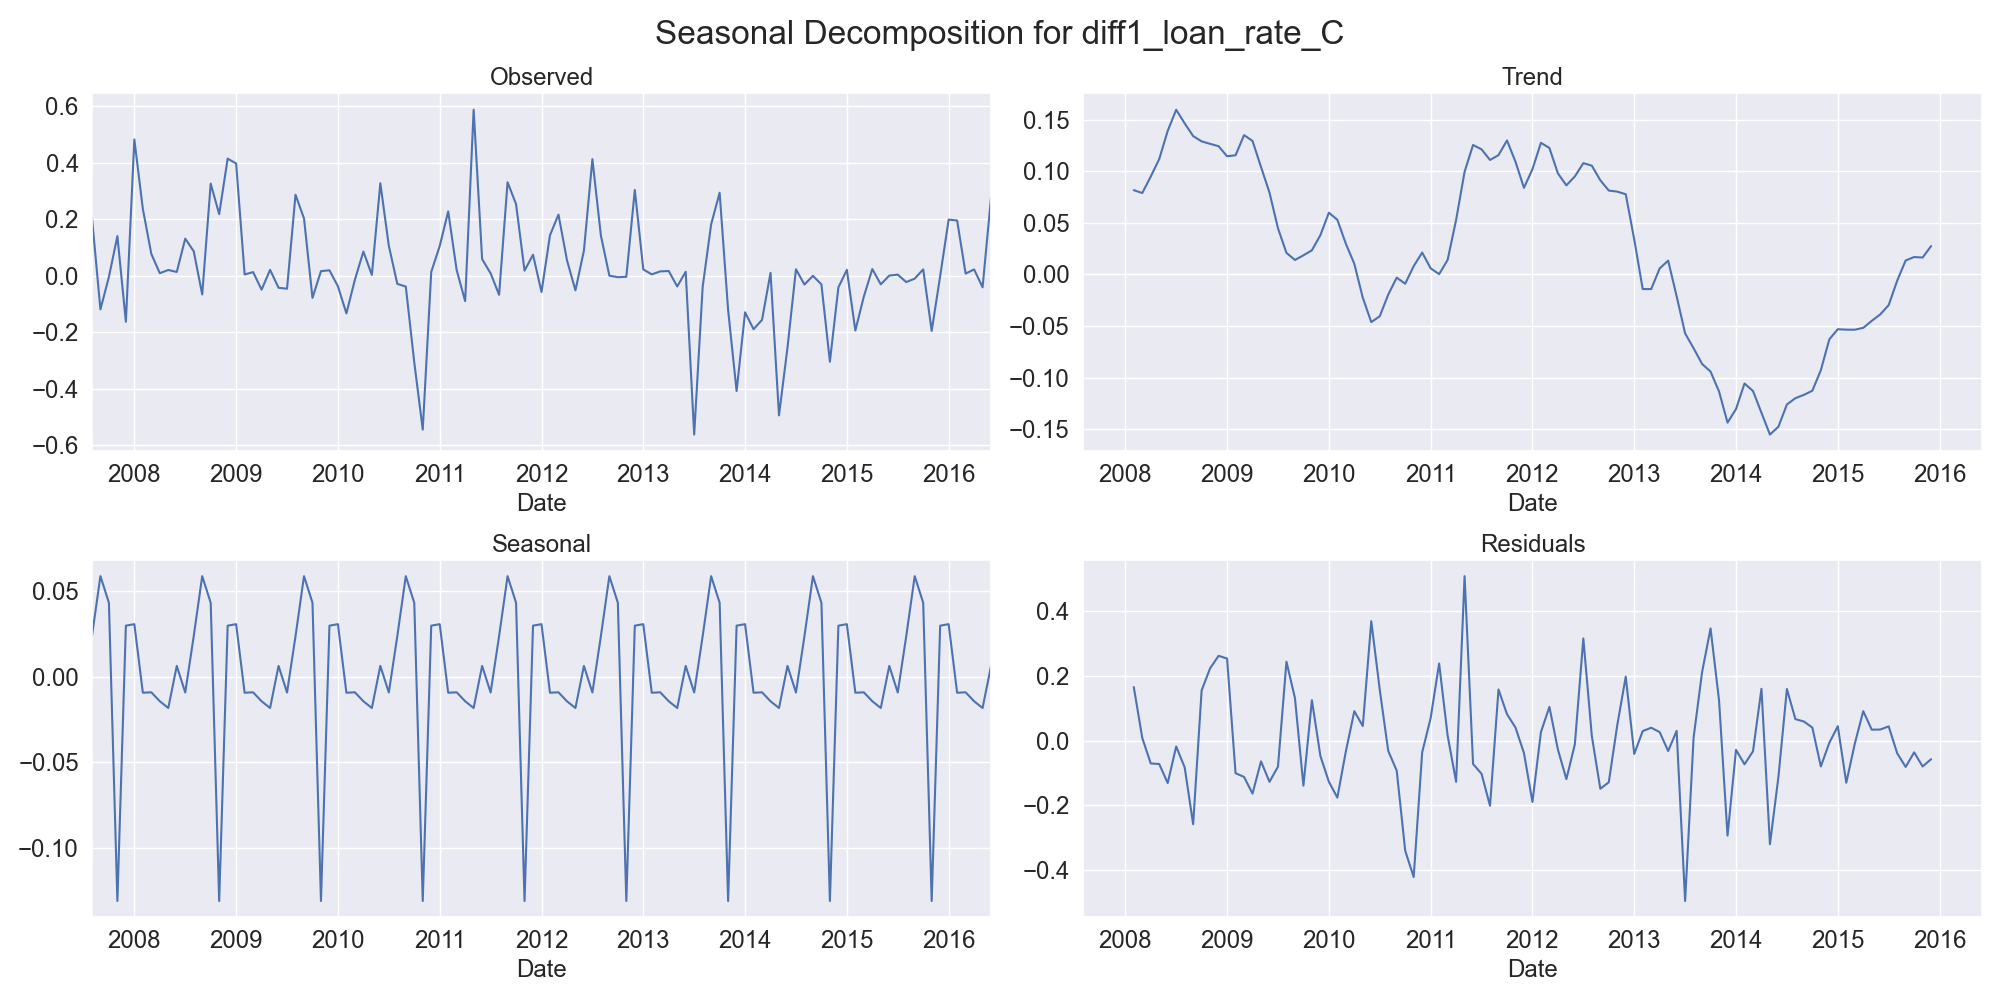
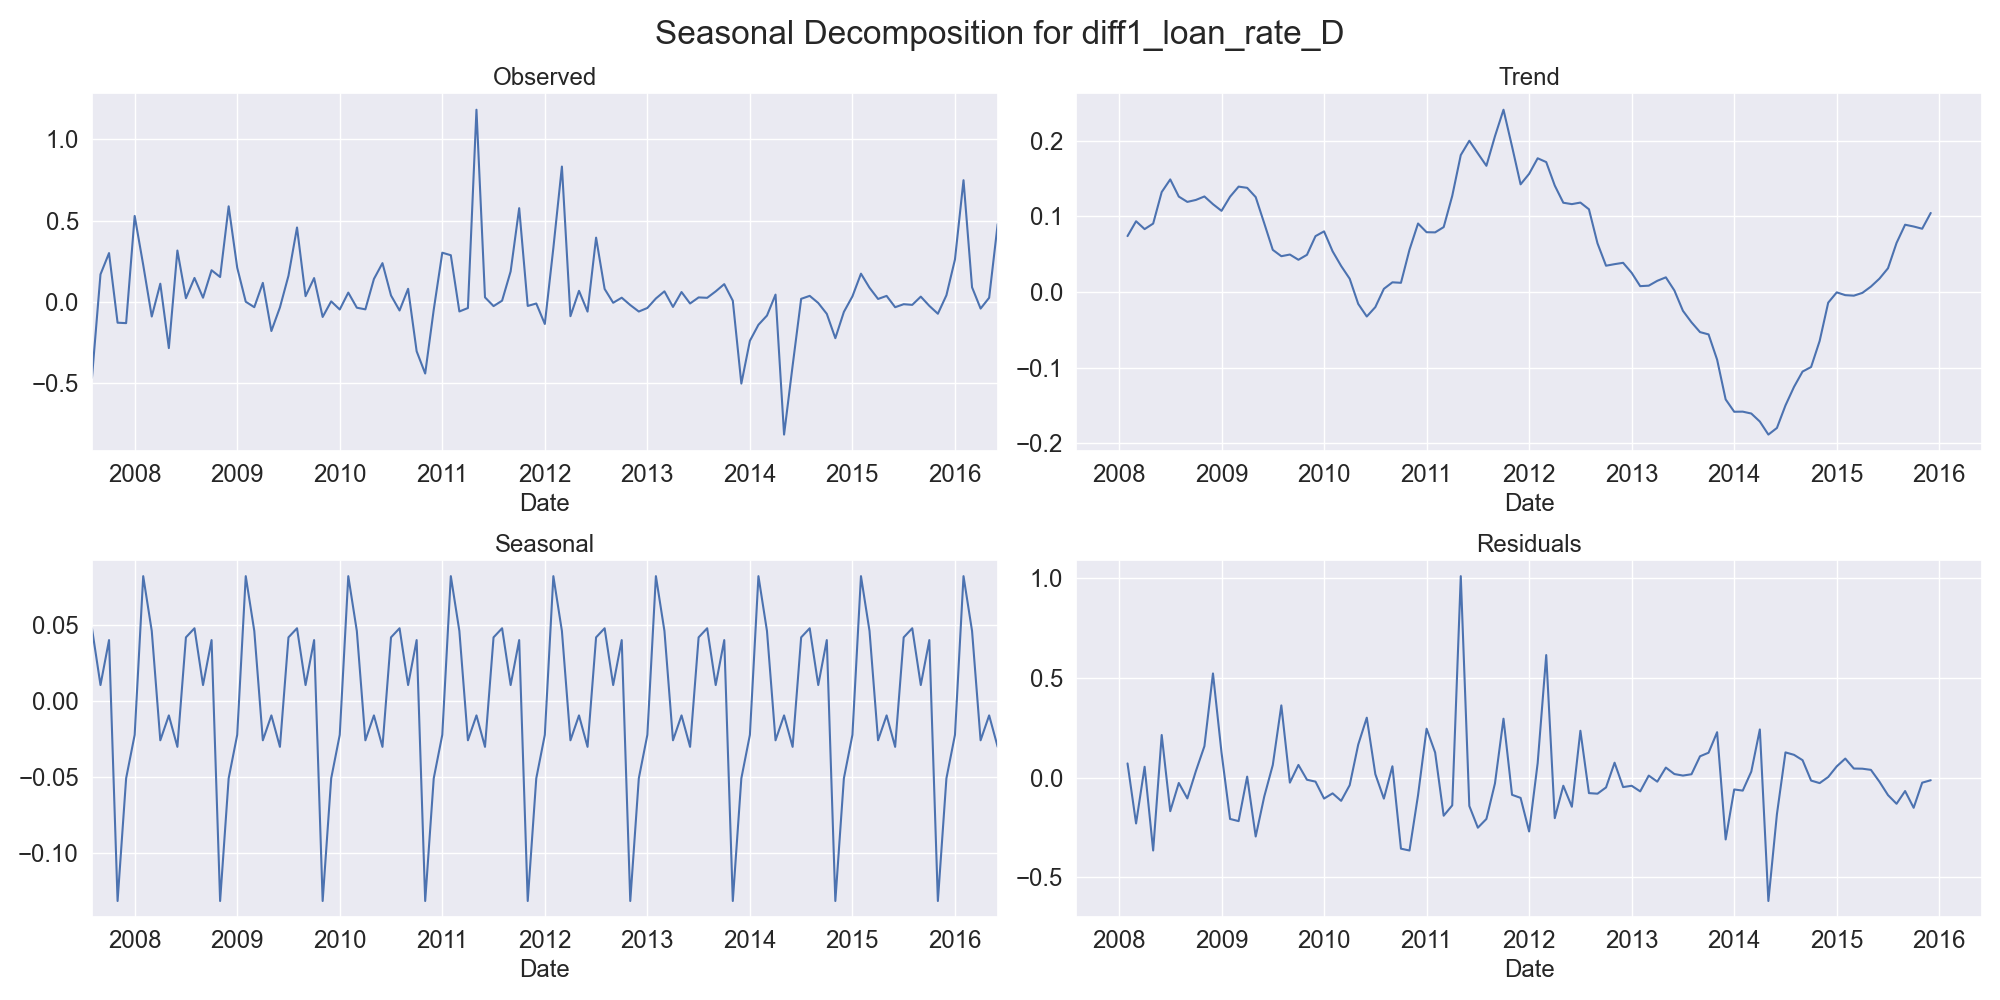
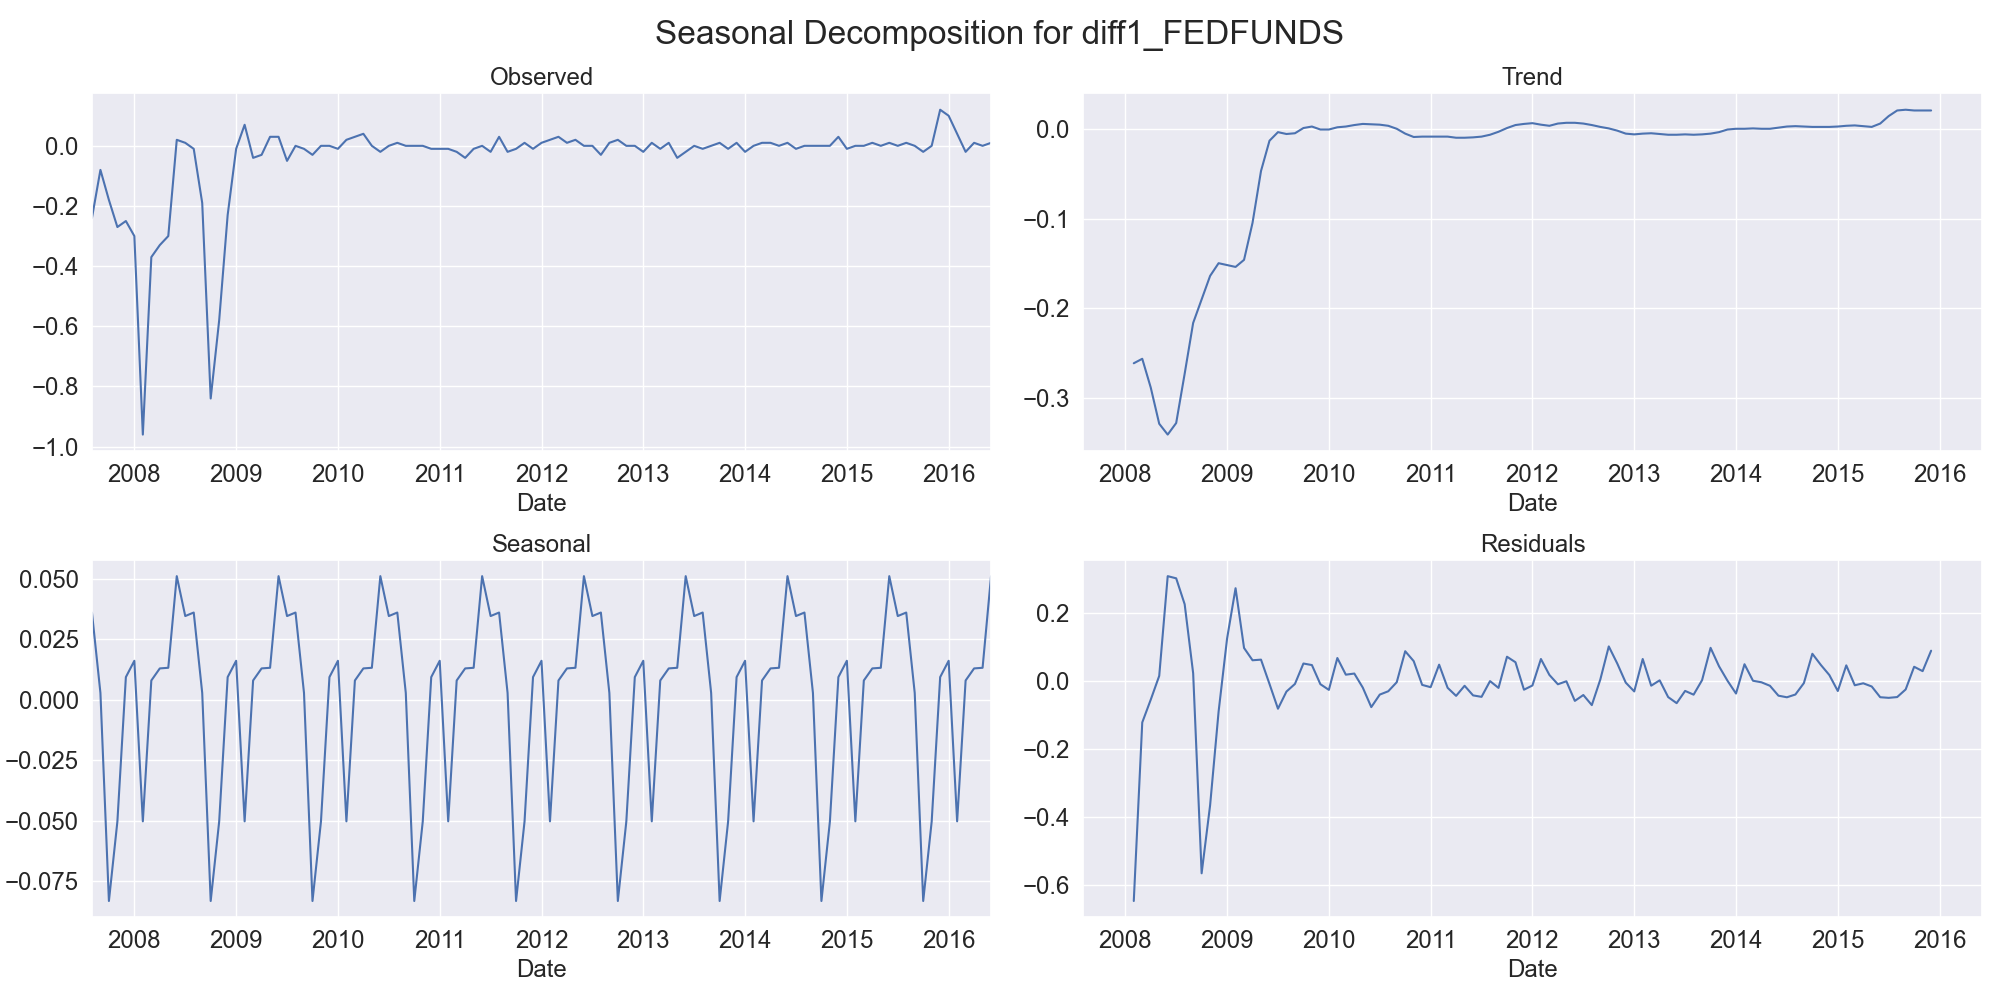
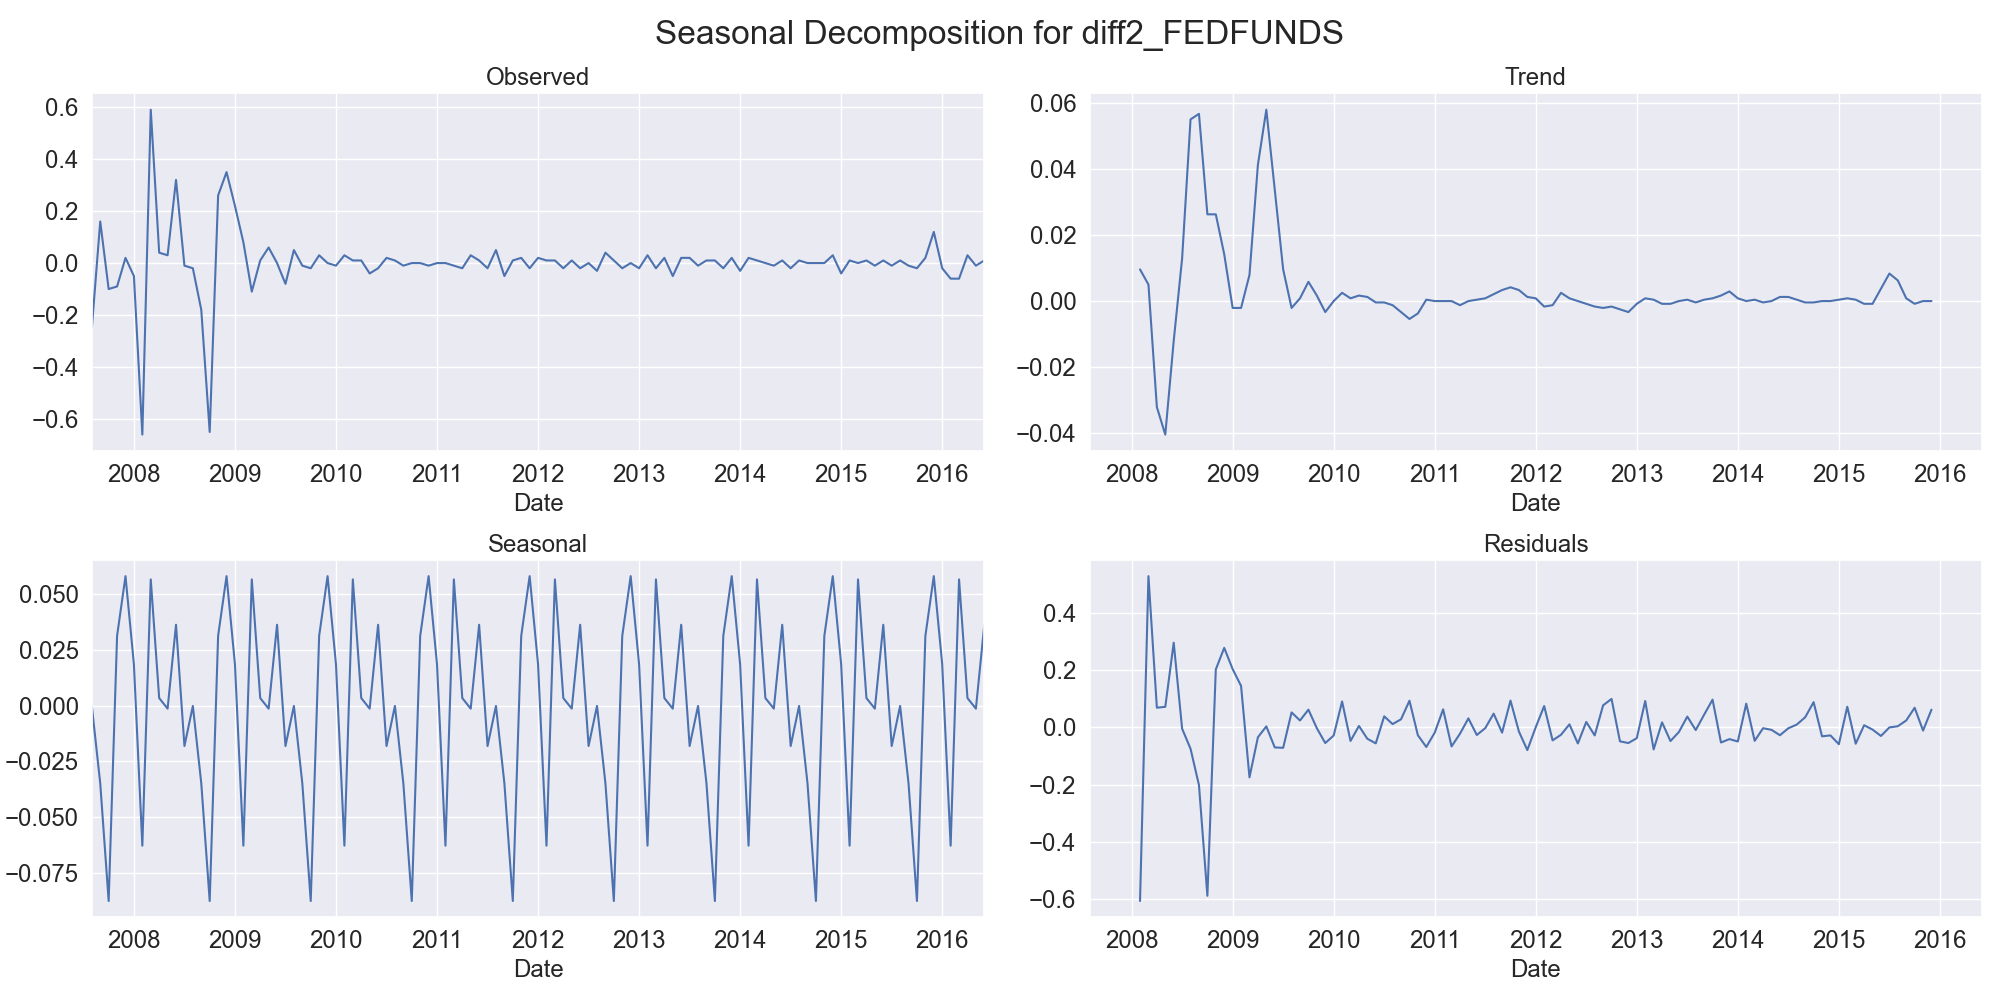
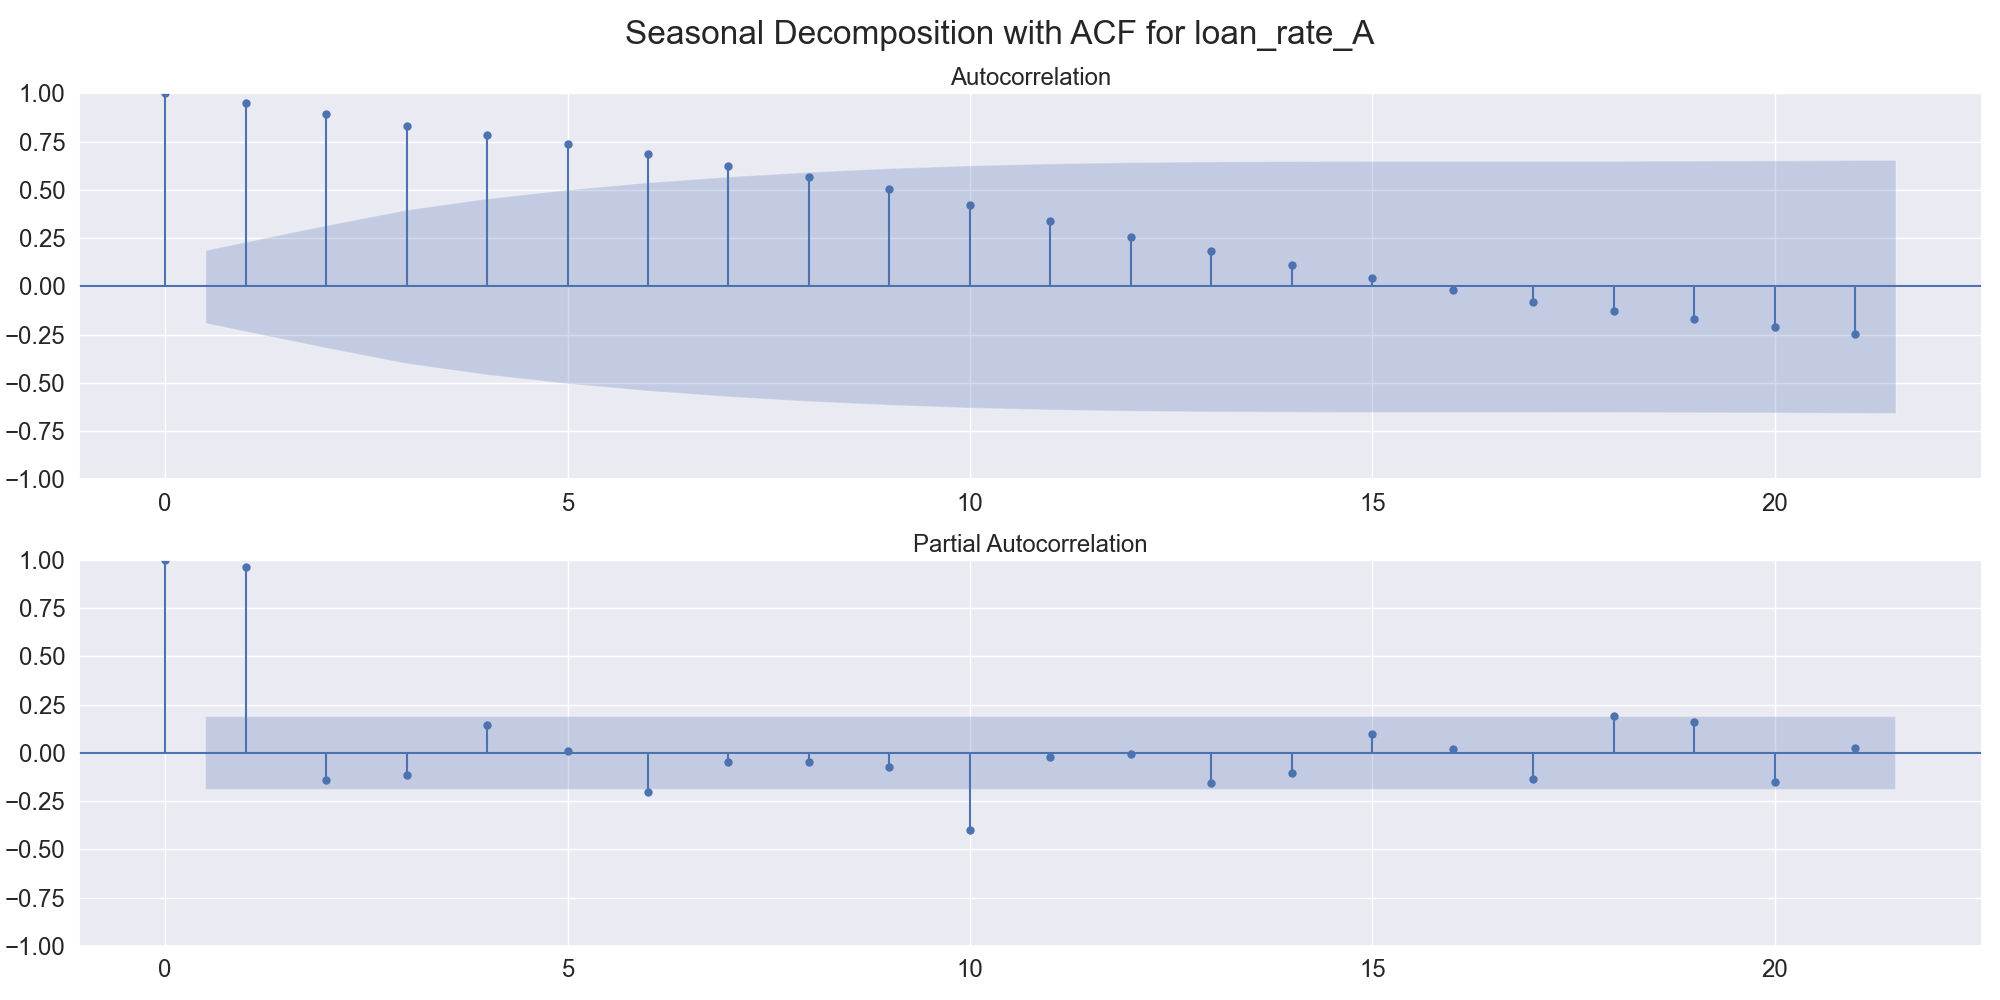
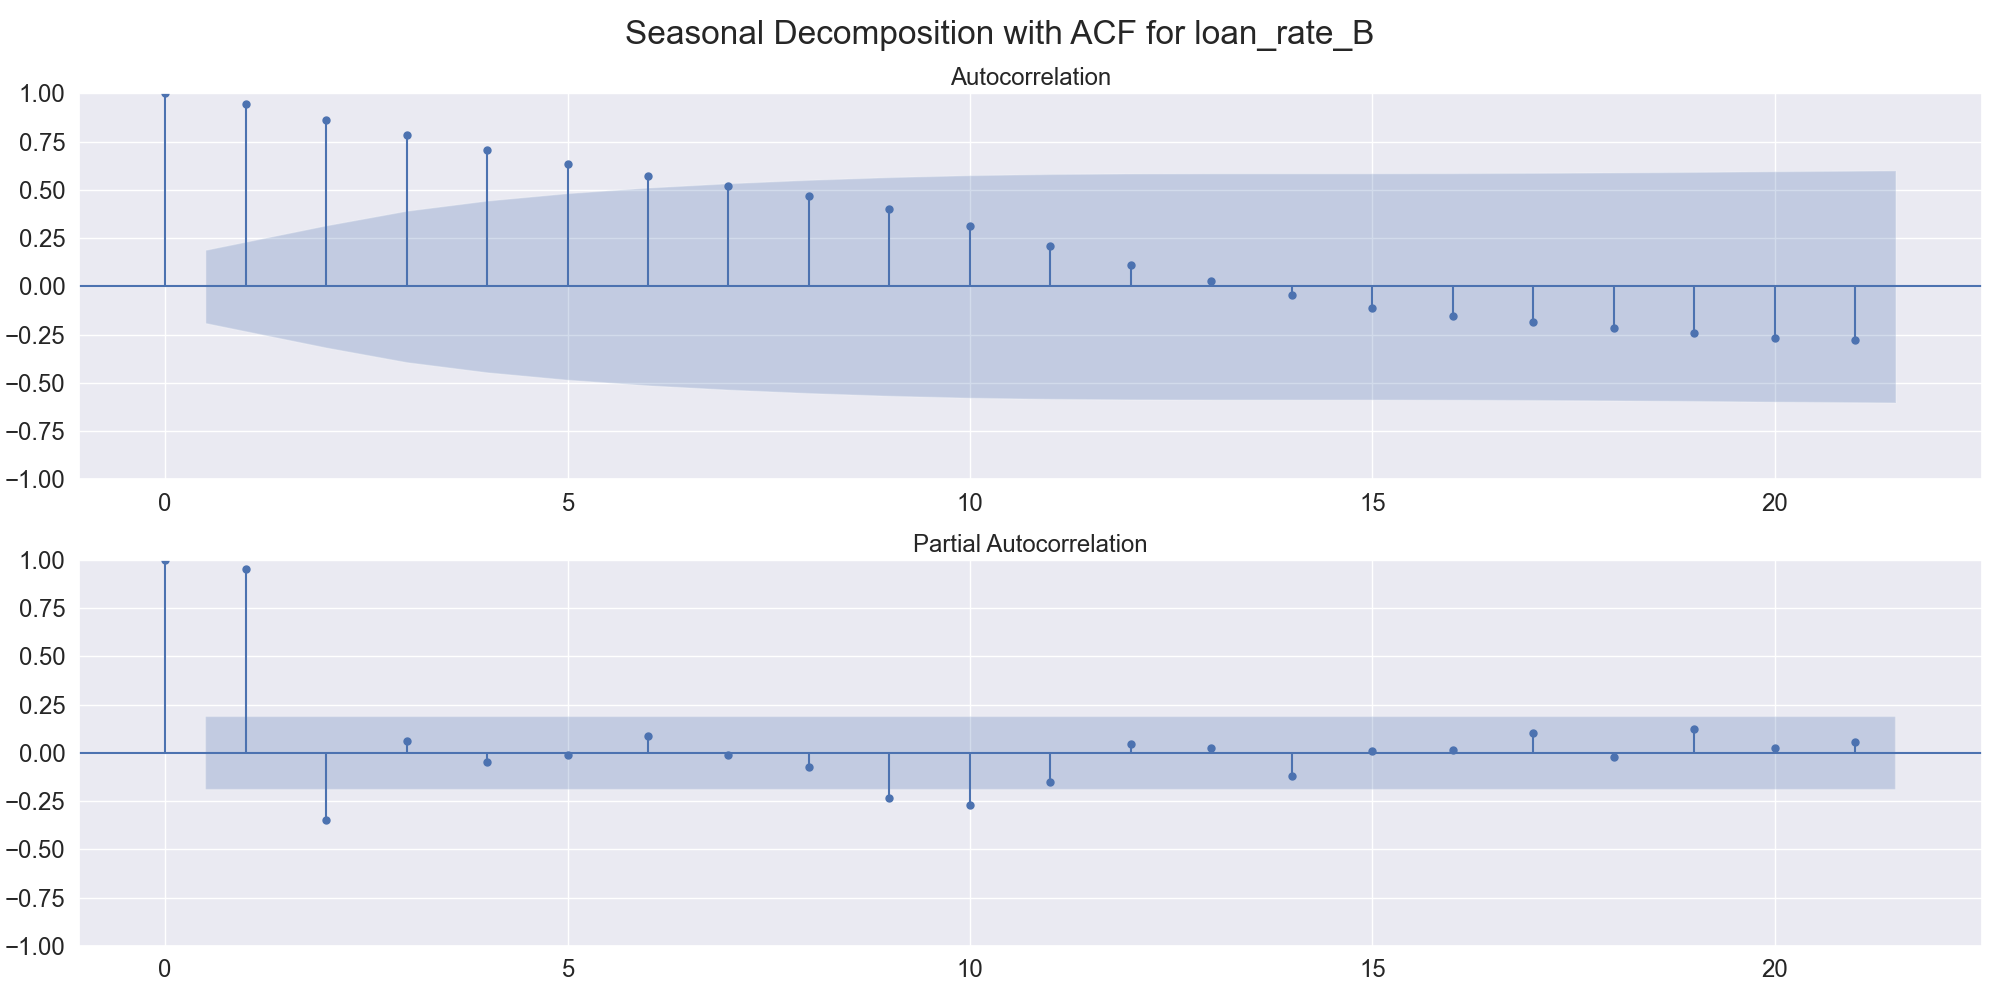
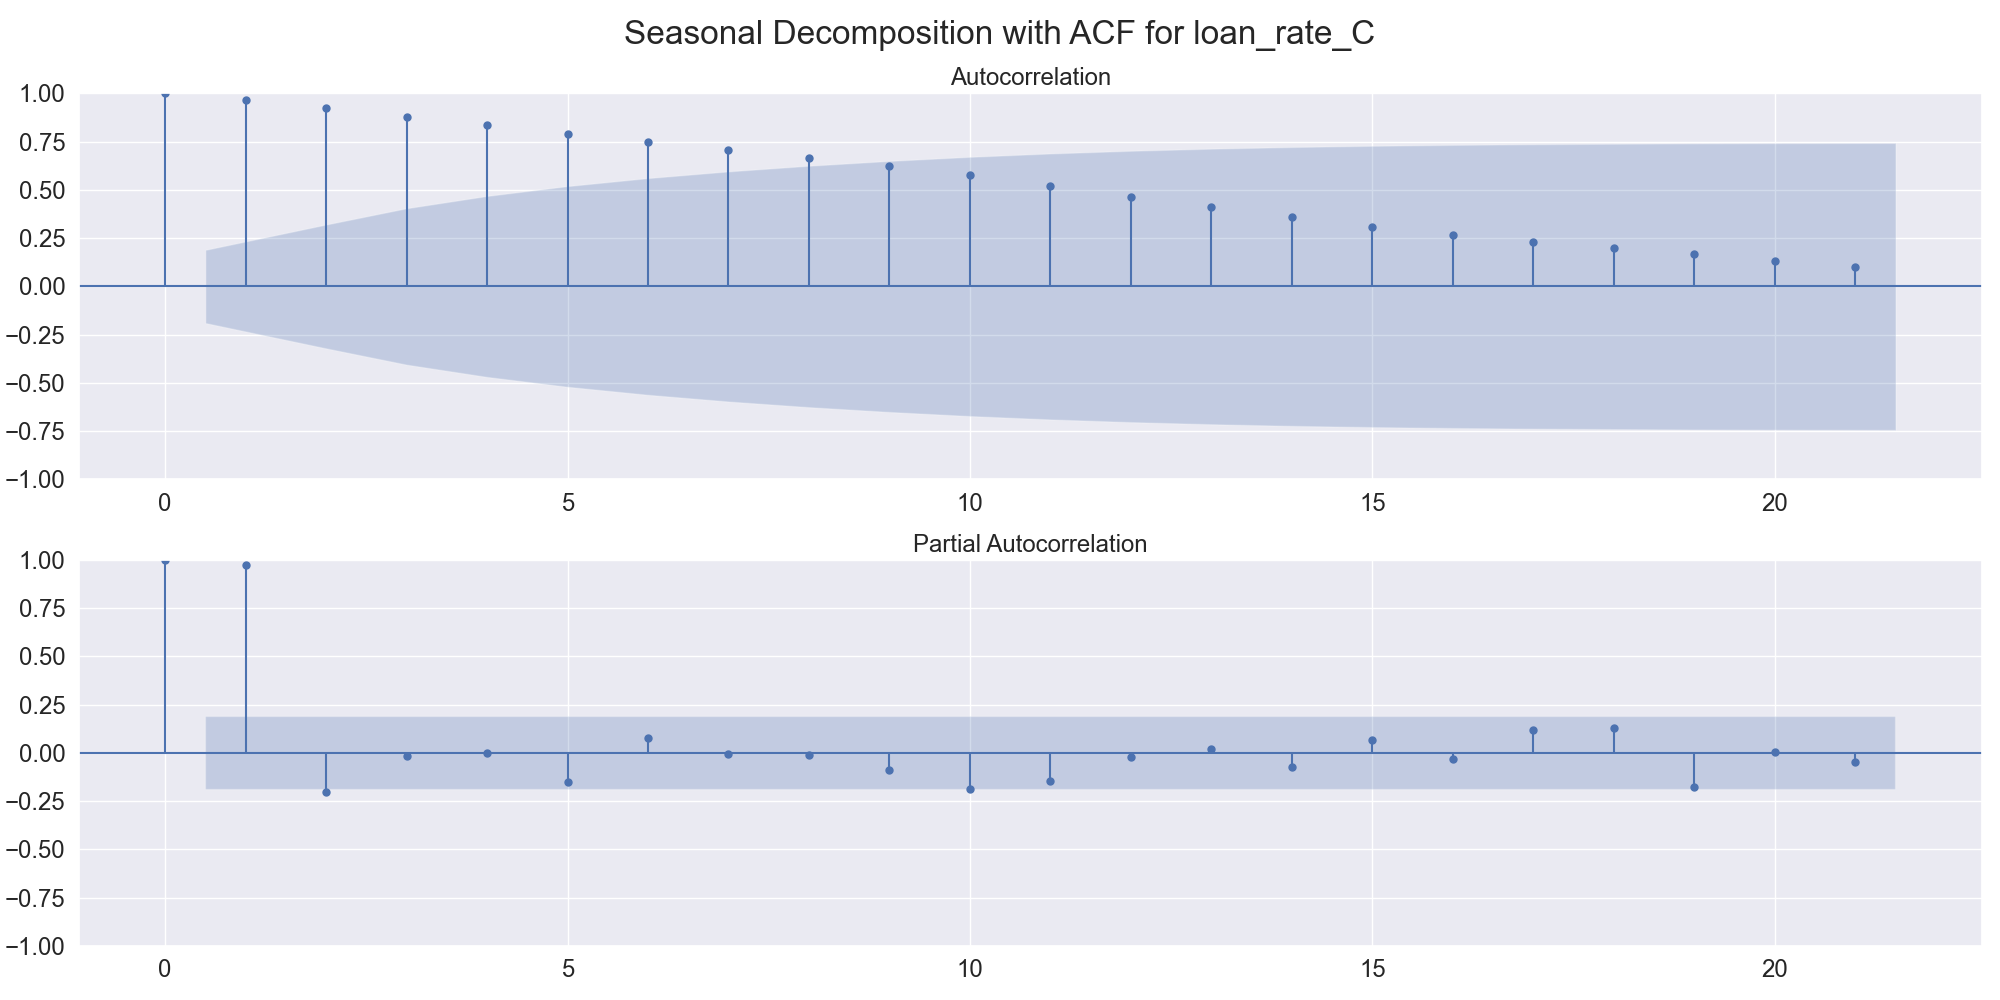
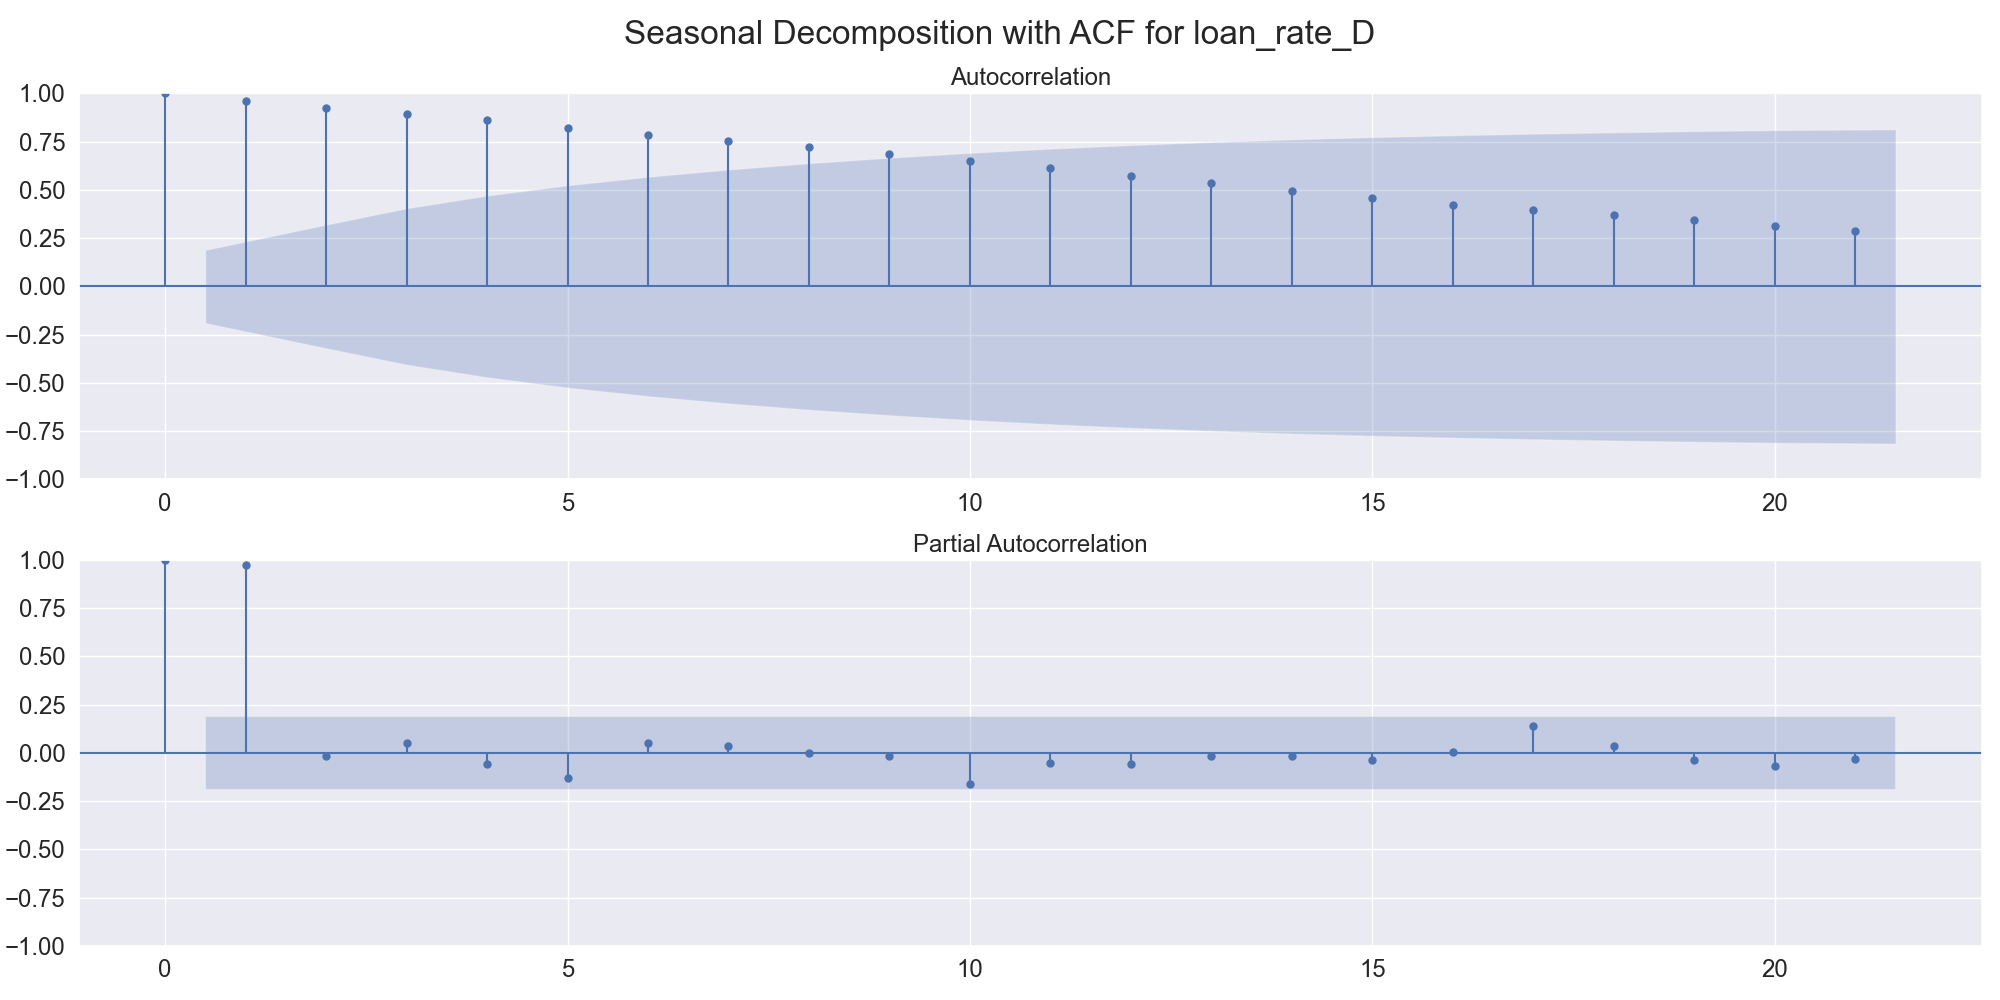
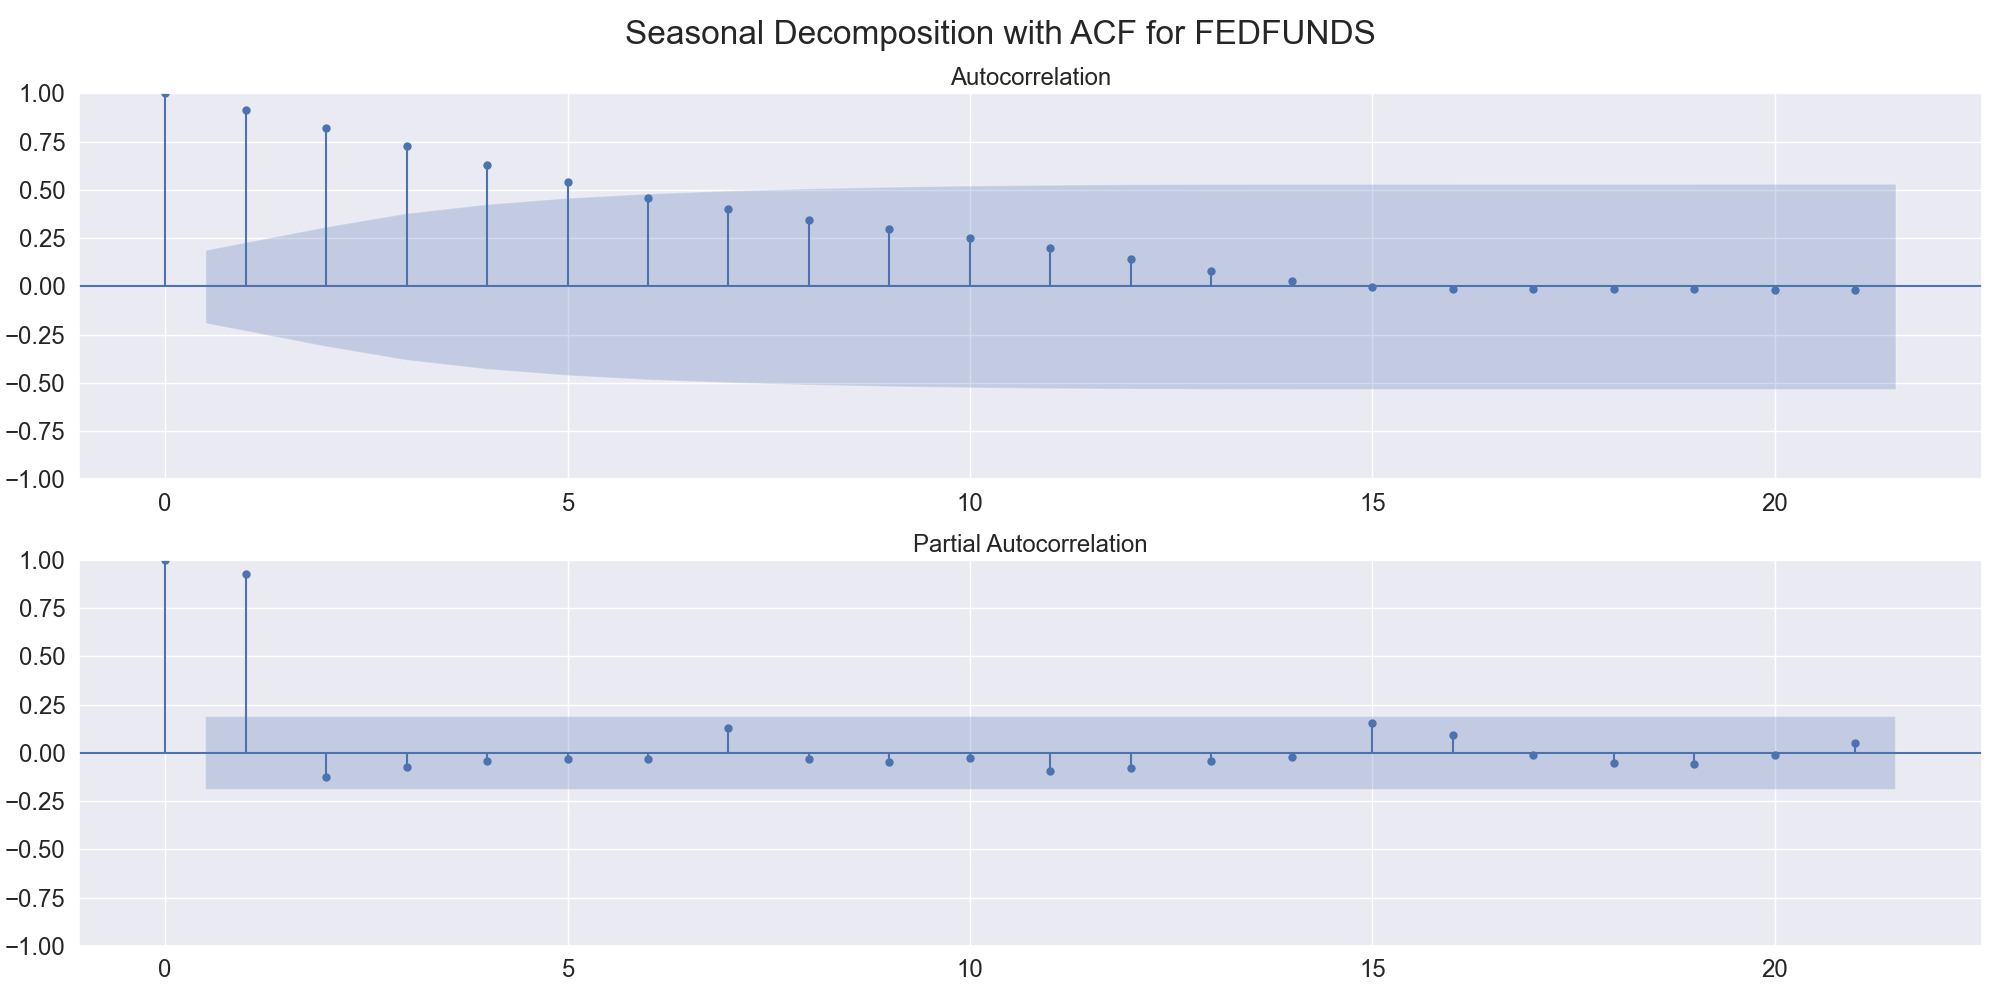
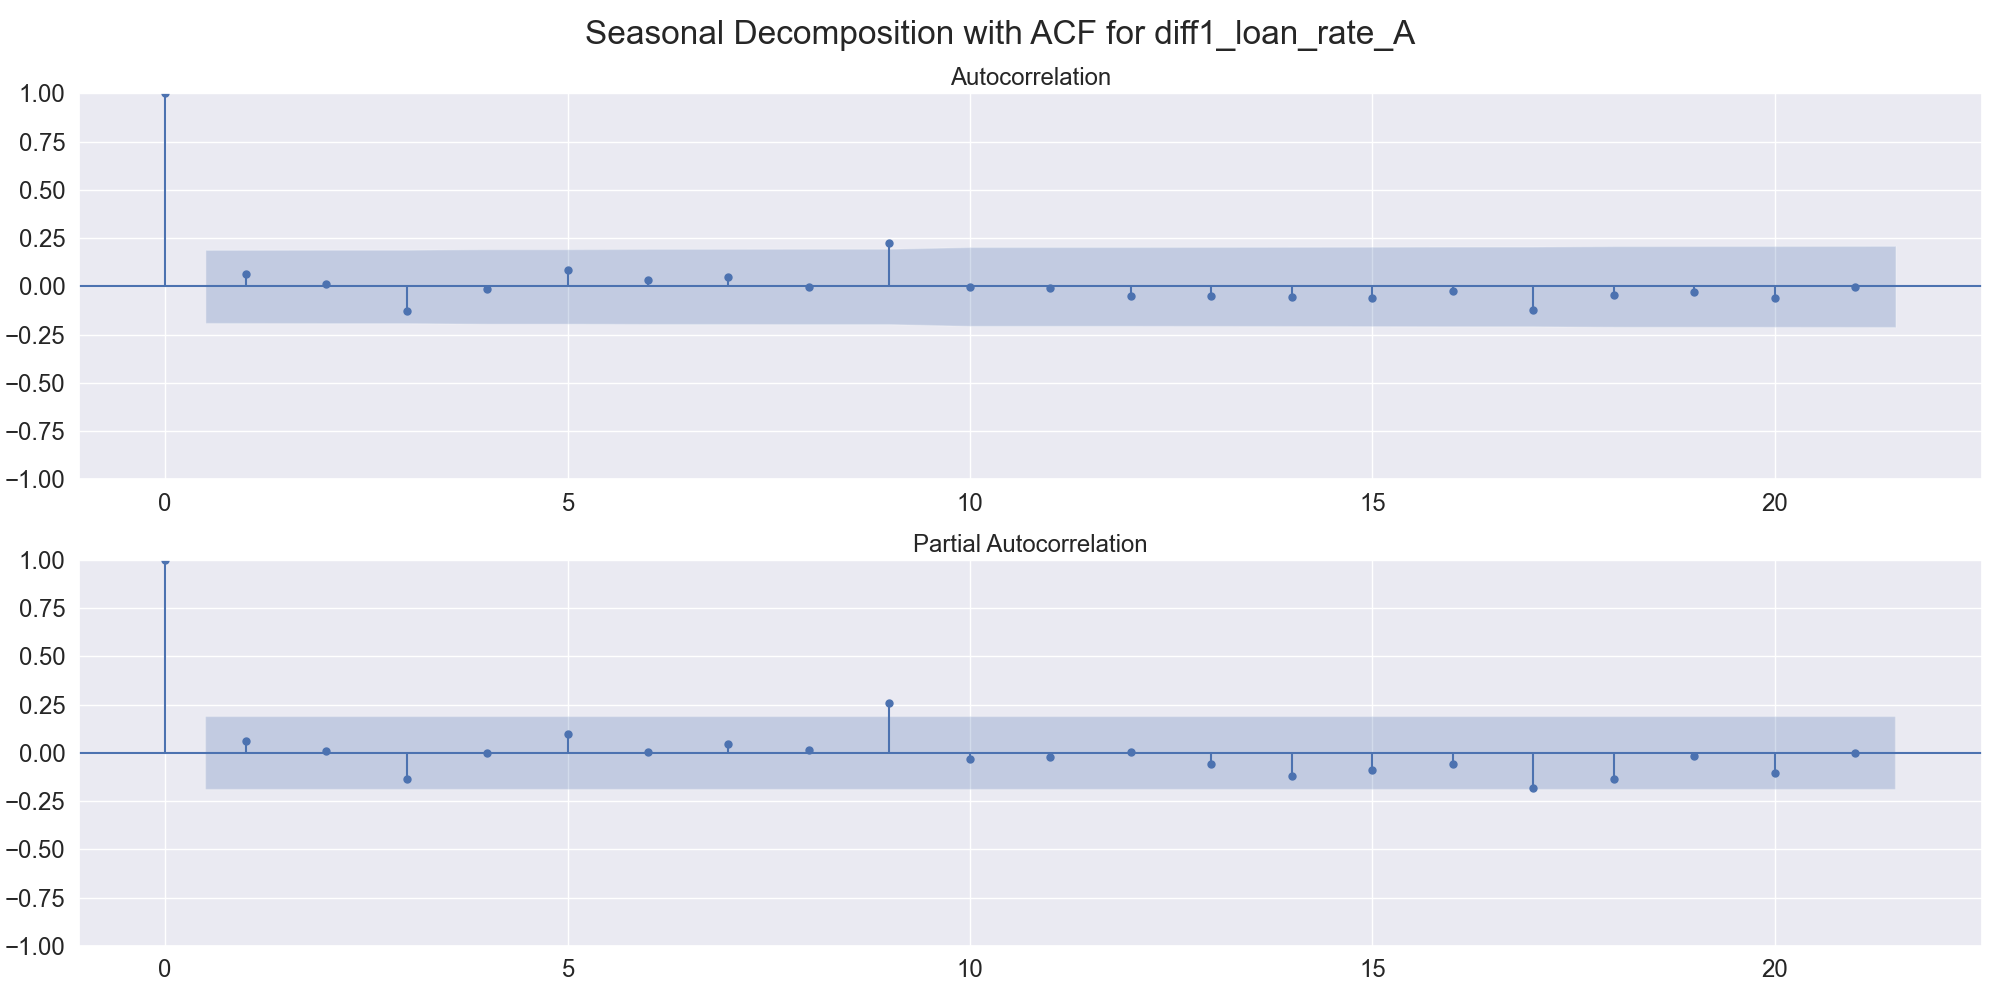
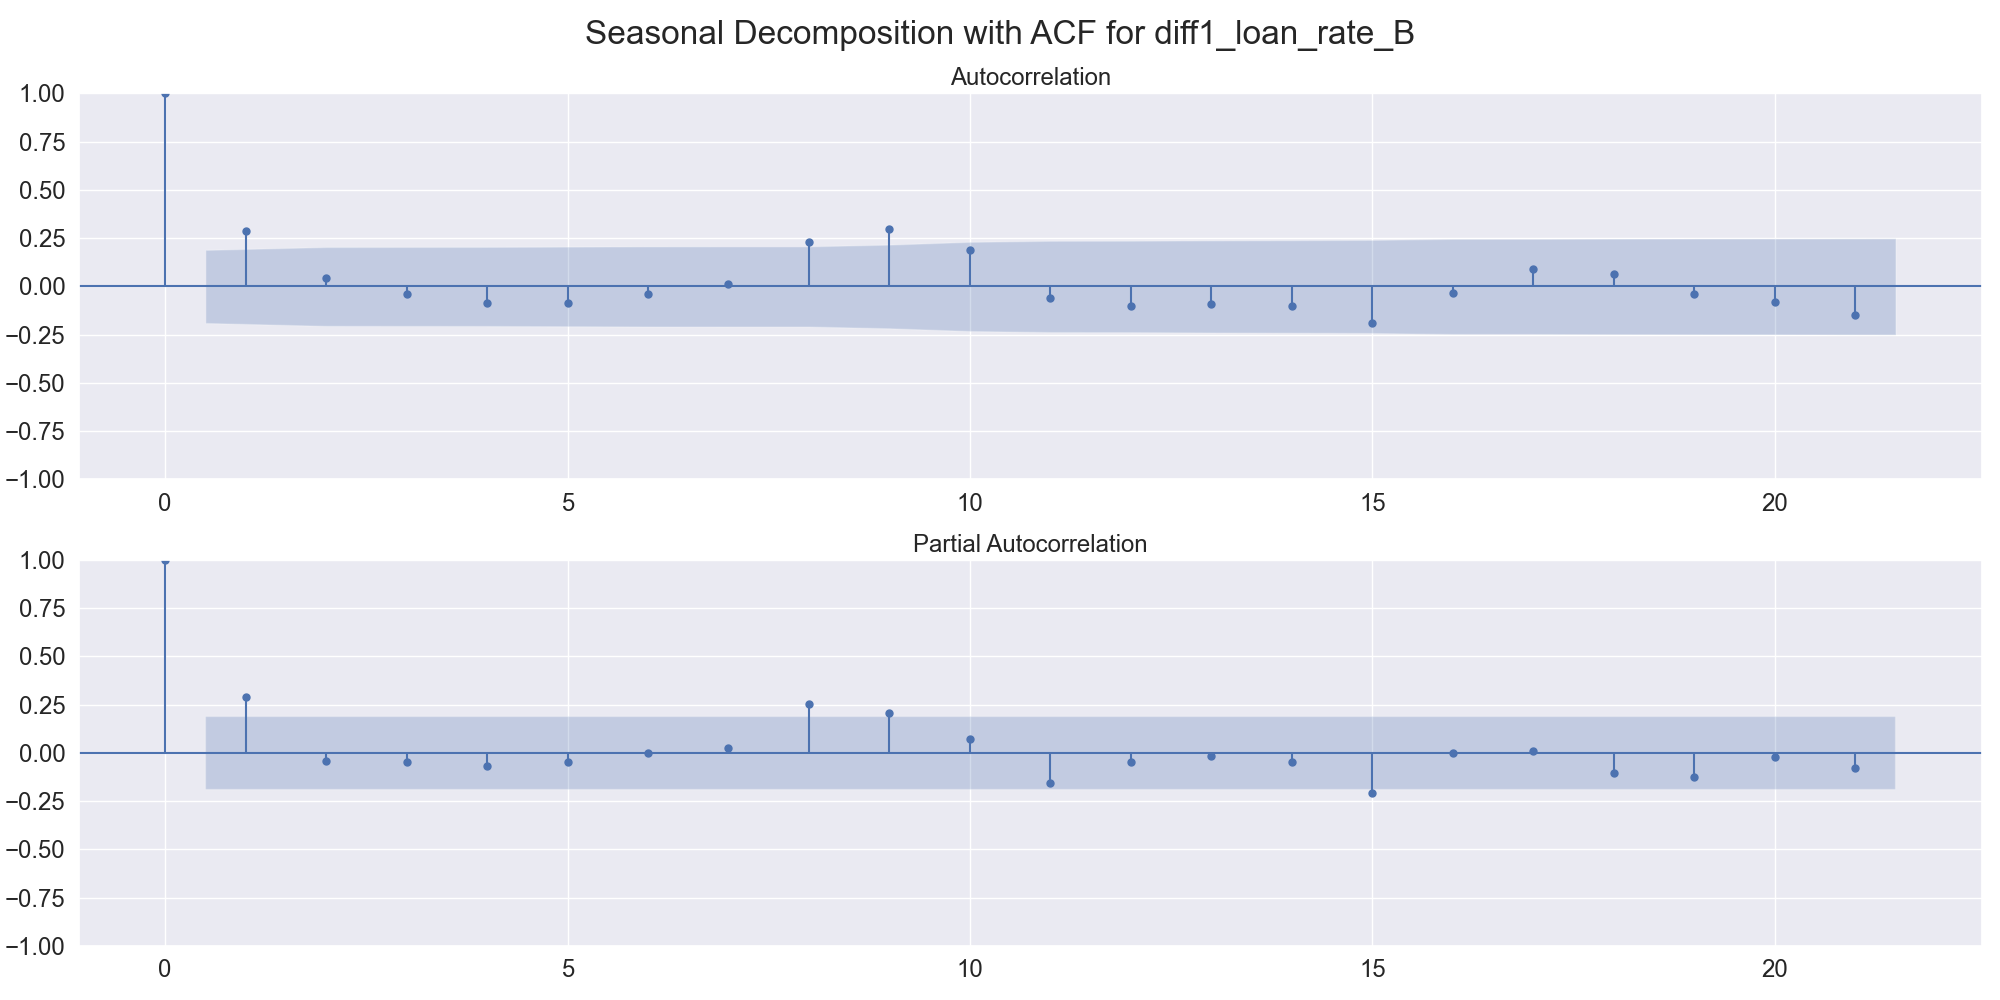
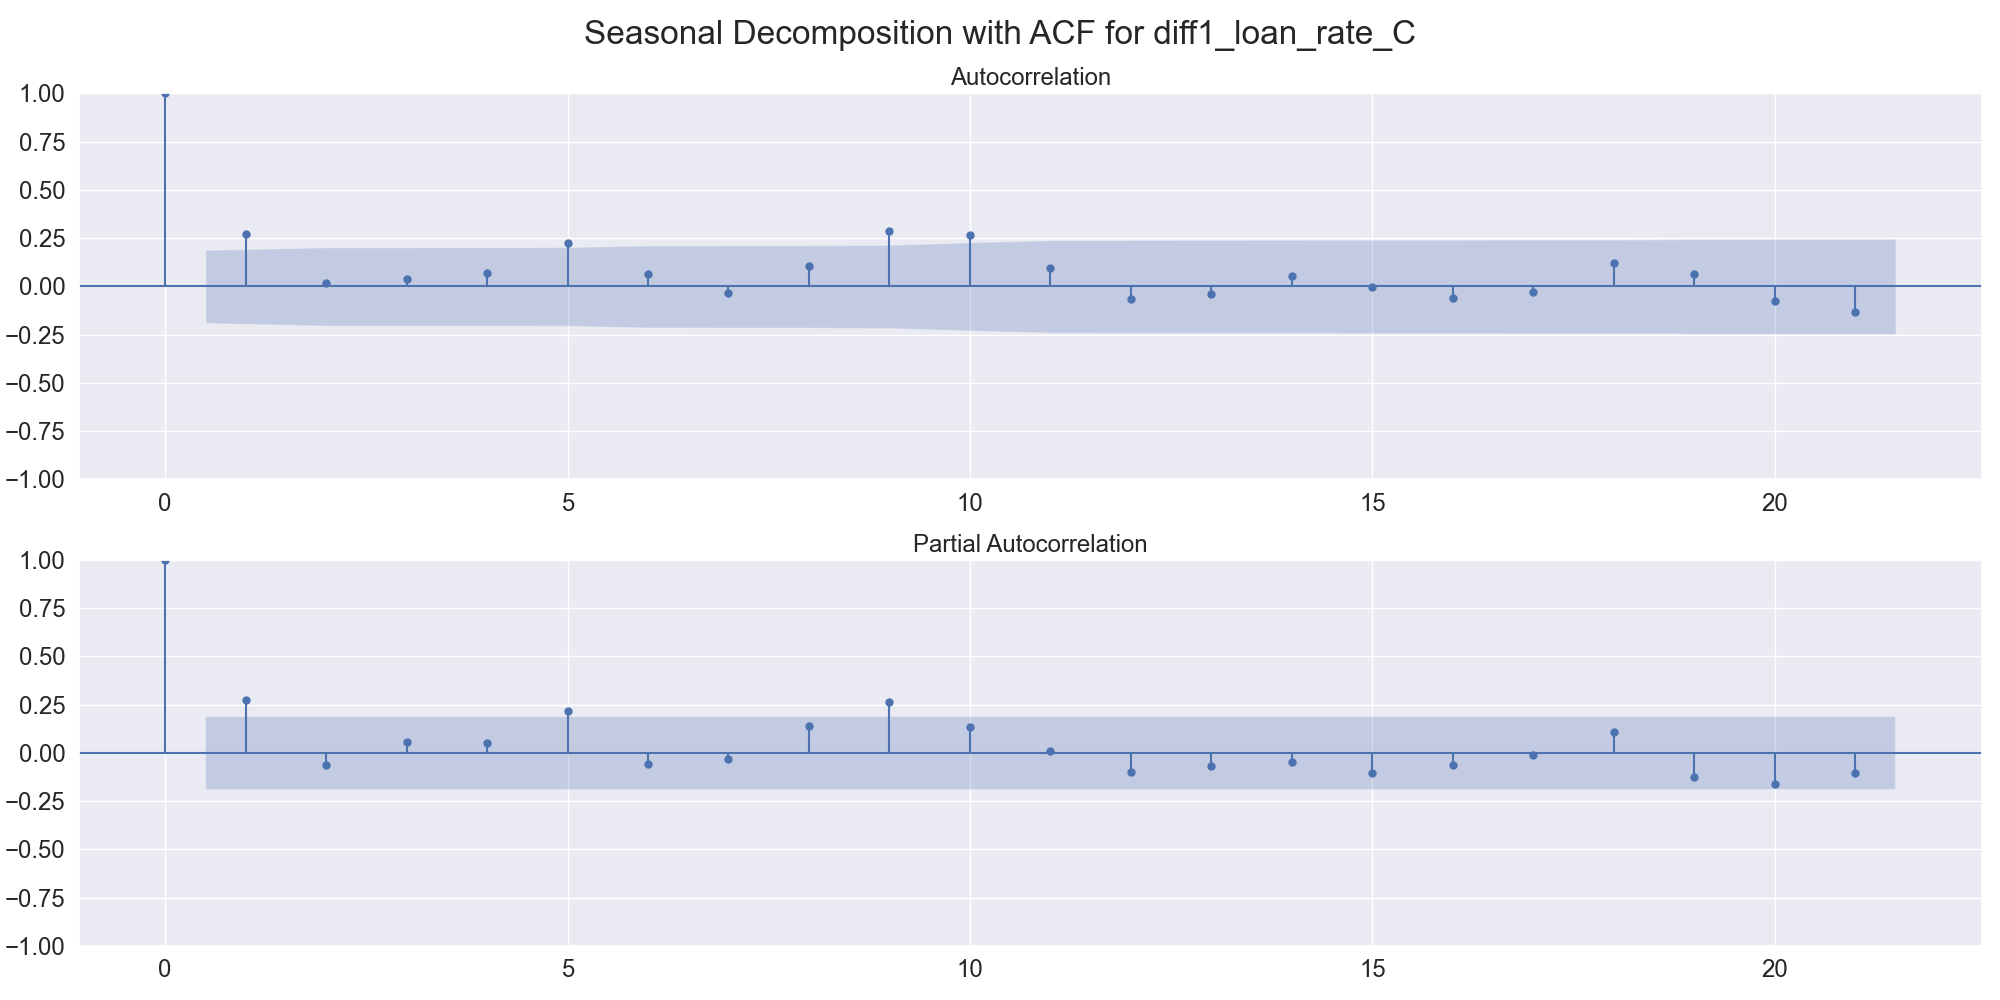
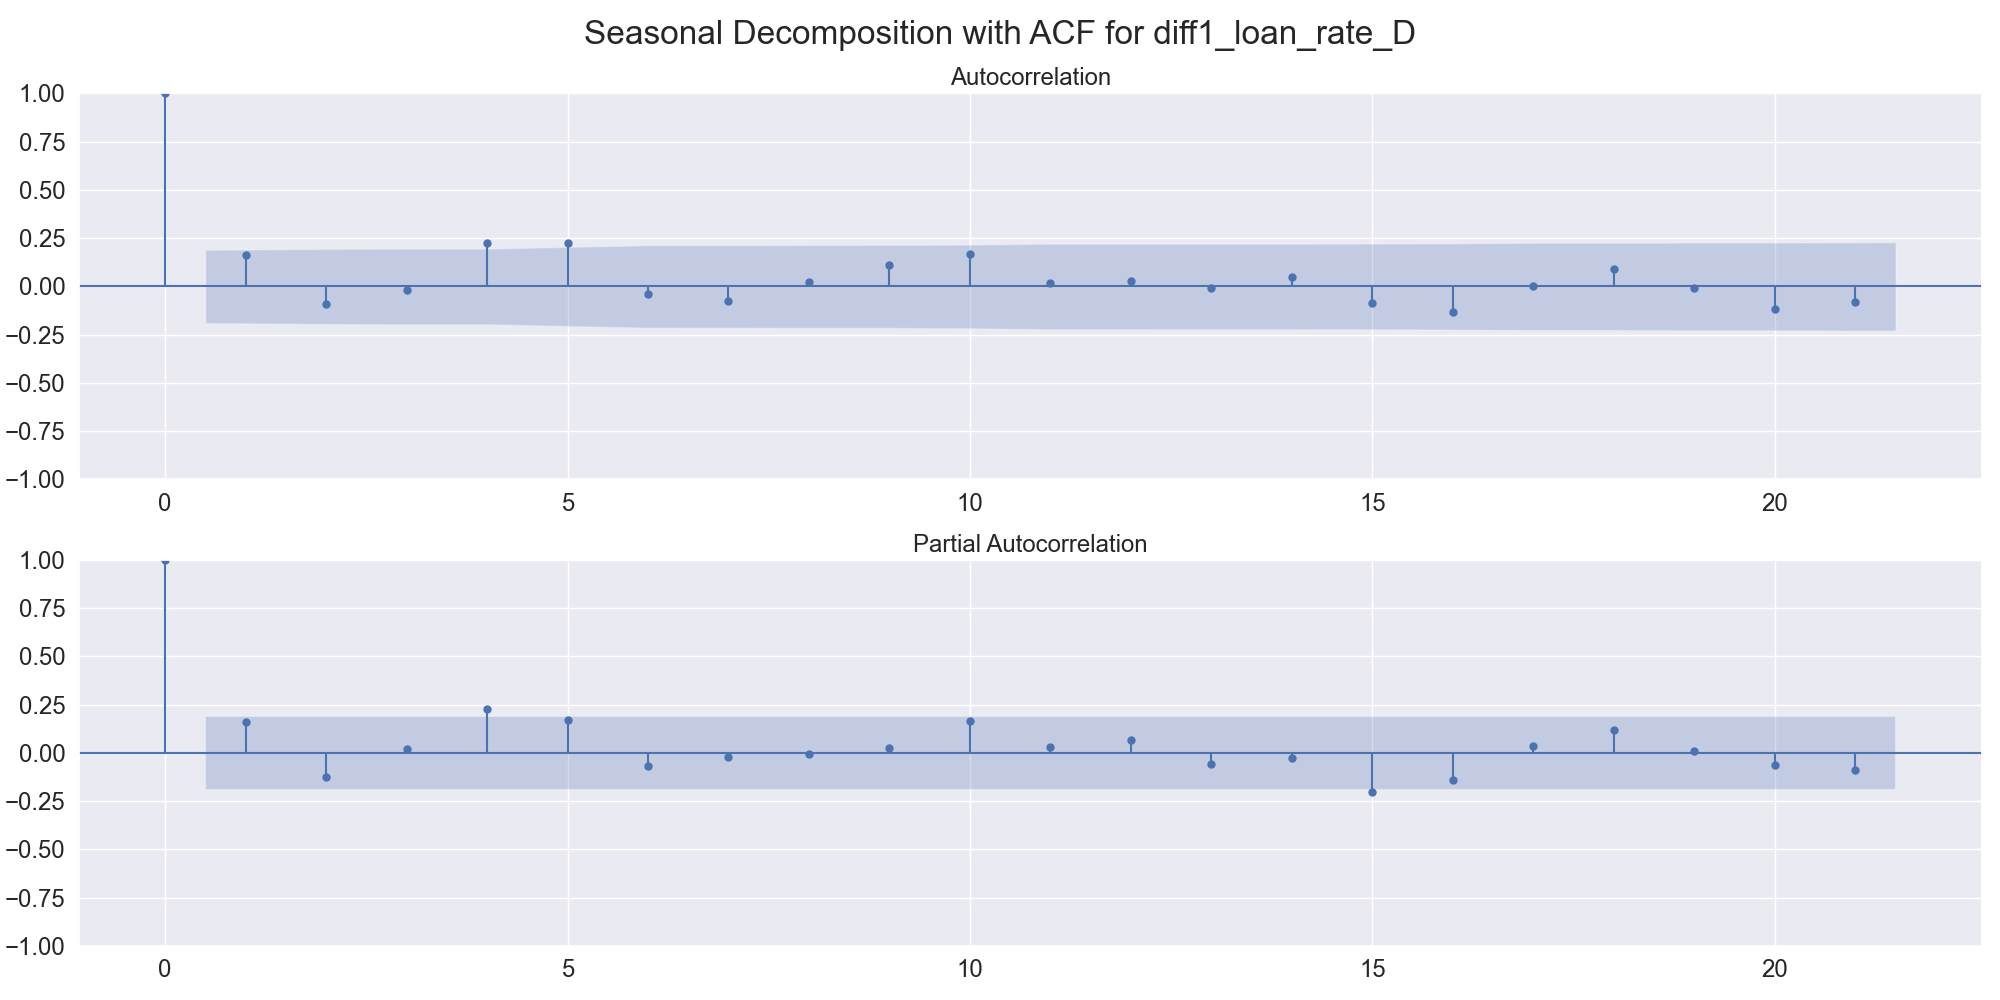
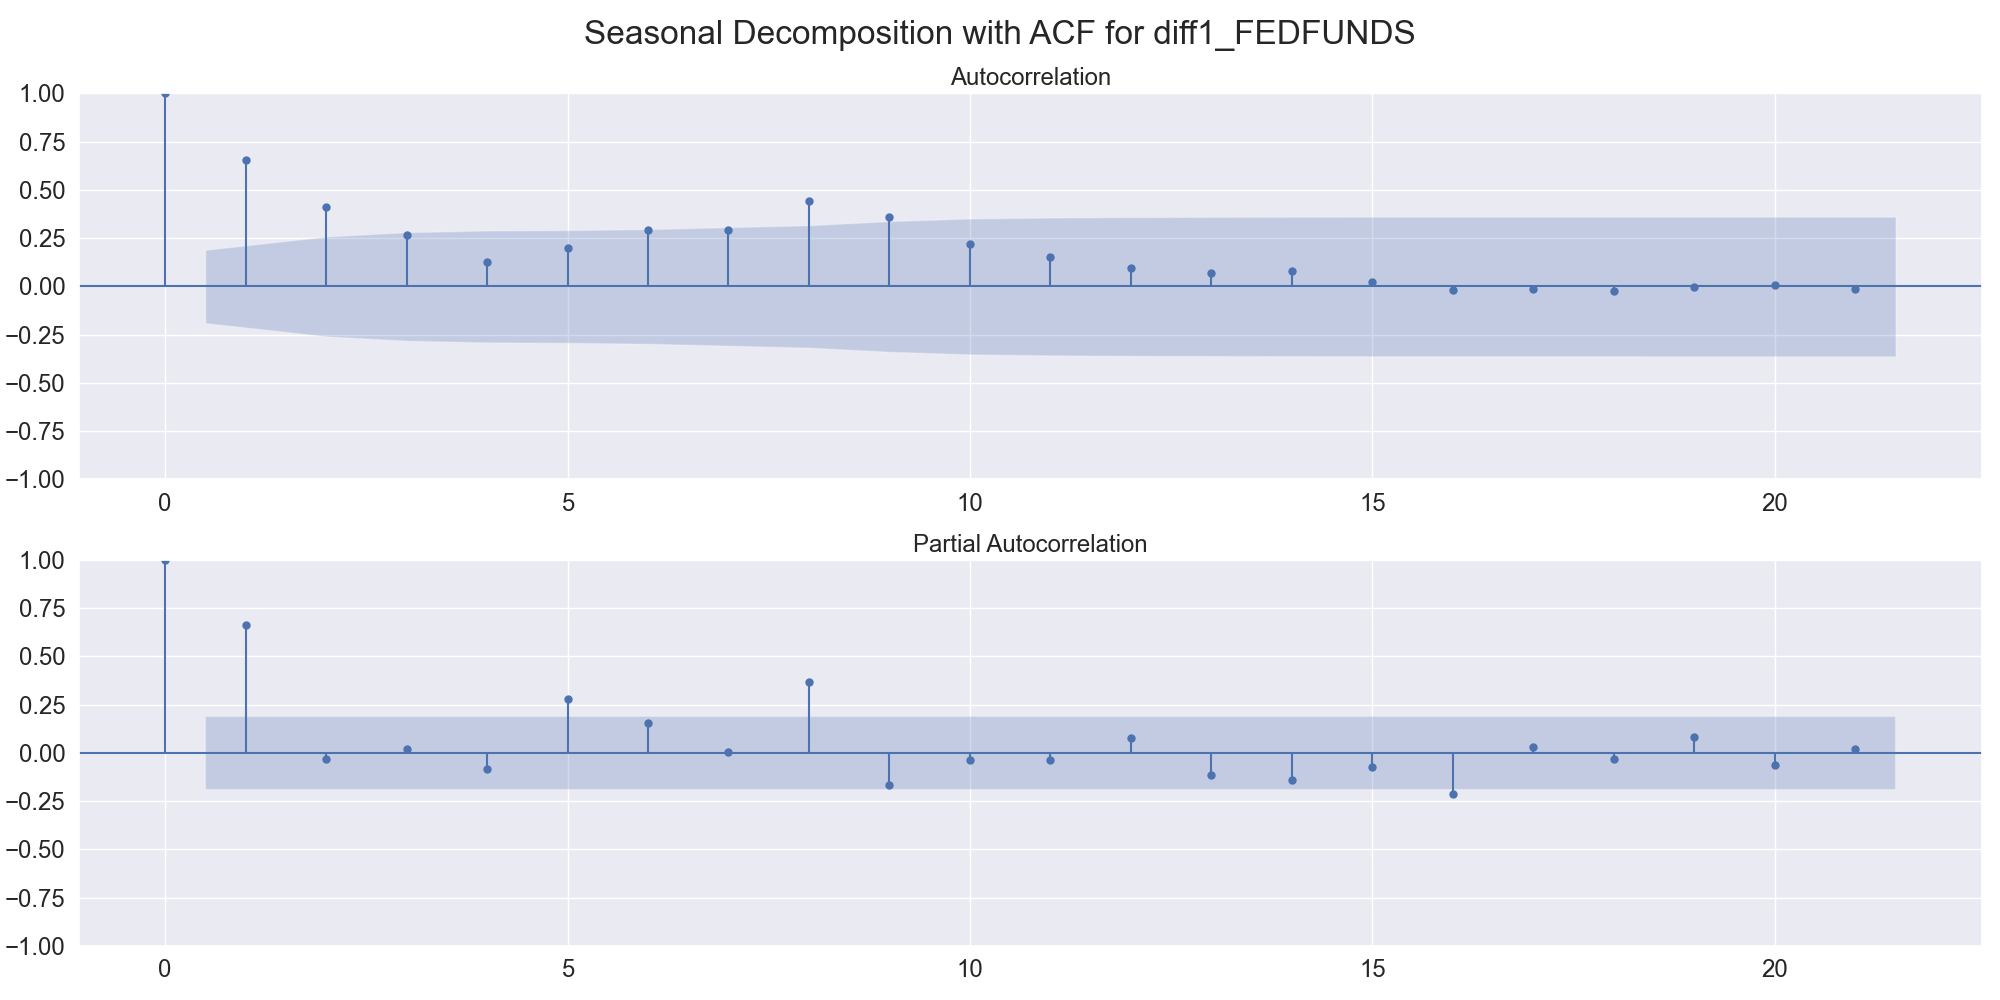
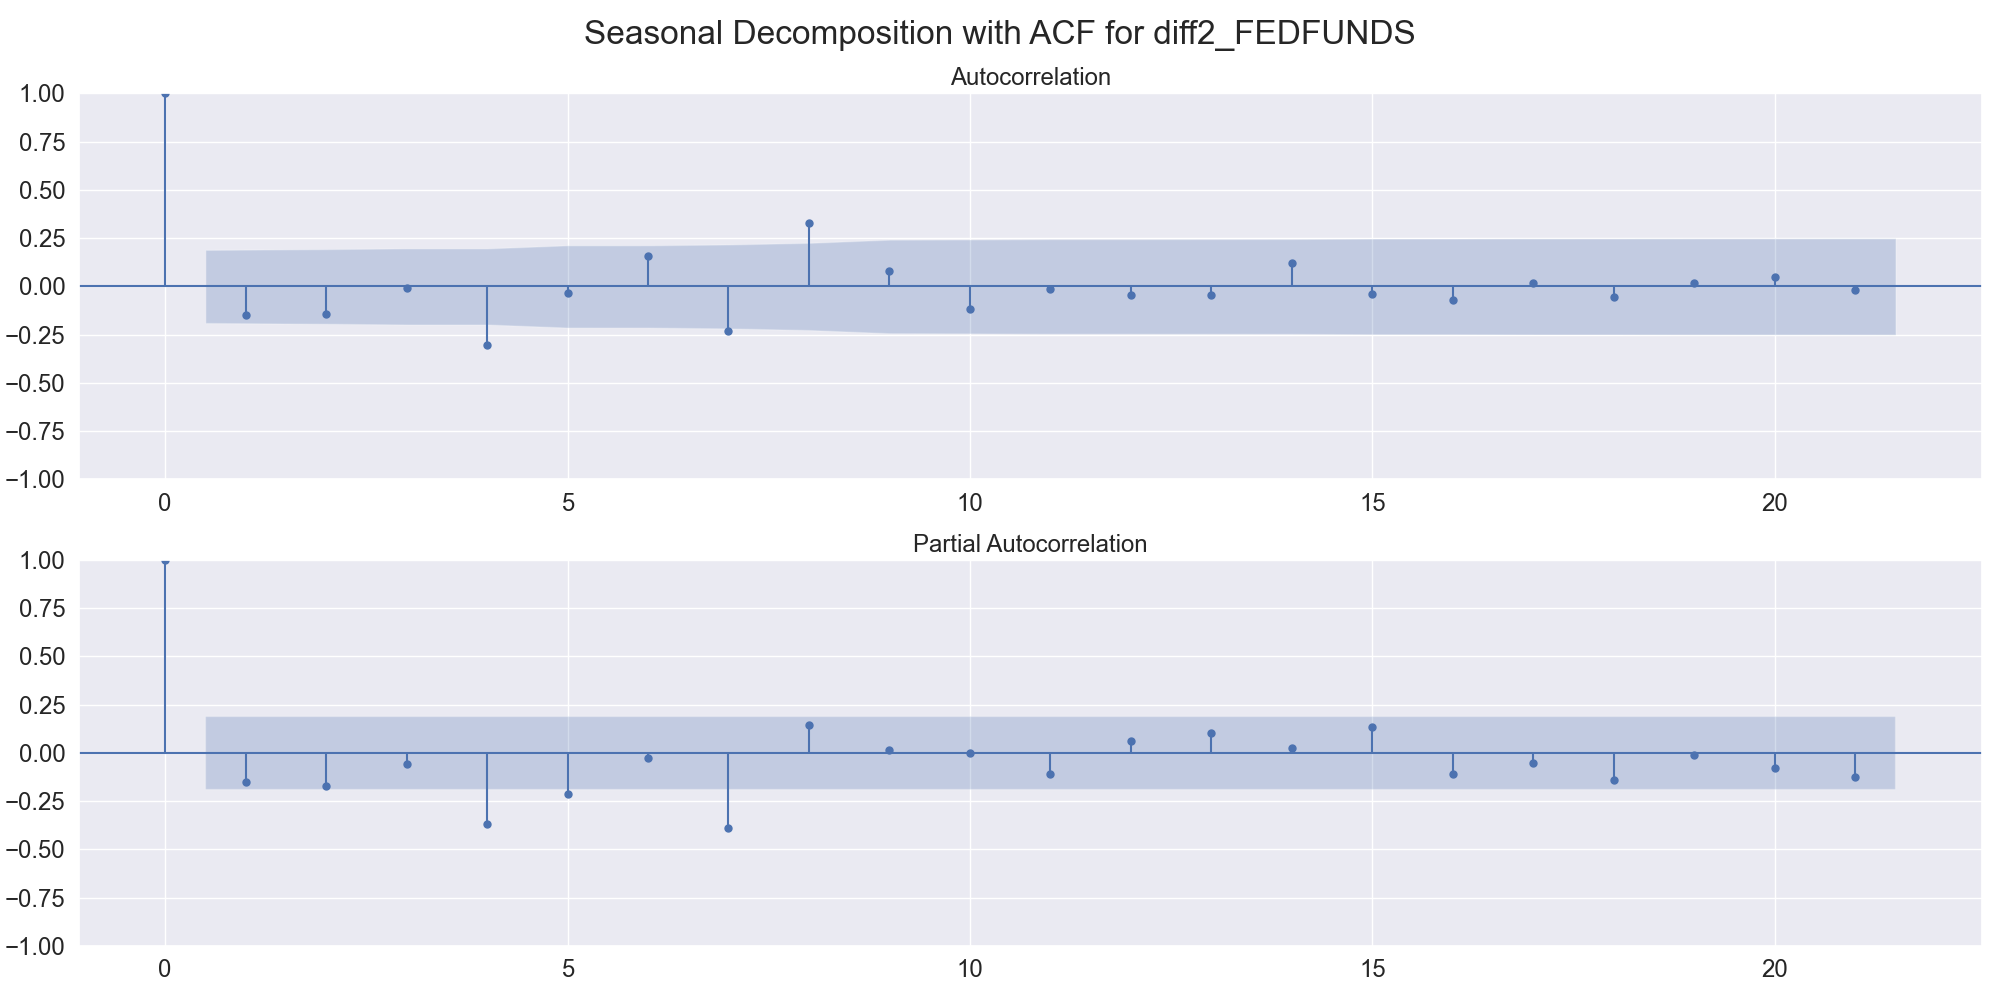

Running Metric: kpss:  20%|██        | 1/5 [00:00<00:00, 46.83it/s]                   The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

The test statistic is outside of the range o

In [19]:
loan_rate_columns = ["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]
diff1_loan_rate_columns = ["diff1_loan_rate_A", "diff1_loan_rate_B", "diff1_loan_rate_C", "diff1_loan_rate_D"]

test_plan_config = {
    "time_series_univariate_inspection_raw": {
        "columns": loan_rate_columns + diff1_loan_rate_columns
    },
    "time_series_univariate_inspection_histogram": {
        "columns": loan_rate_columns + diff1_loan_rate_columns
    }
}

vm.run_test_plan(
    "timeseries_test_plan",
    config=test_plan_config,    
    test_ds=vm_test_ds,
    train_ds=vm_train_ds,
    dataset=vm_train_ds,
)